### Project Implementation Introduction

<p>
    Introductory Paragraph
</p>

In [30]:
# Python libraries used retrieve dataset path information and time module to estimate model running time
import os
import time
import warnings

# Turn off warnings completely for the Notebook
warnings.filterwarnings('ignore')

# Python libraries used import dataset as a dataframe into the IDE, perform array manipulations
# and data visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Python libraries used to preprocess dataset i.e. split the dataset into training set and testing set and also
# to standardize the dataset (optimize the dataset)
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV 
from sklearn.preprocessing import MinMaxScaler

# Supervised Learning models (Classifiers) used to implement the models
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier

# Evaluation Metrics used to analyze the performance of the implemented models
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from imblearn.metrics import geometric_mean_score

# SMOTE technique used to eliminate the imbalance in the dataset
from imblearn.over_sampling import SMOTE

# tensorflow keras Library used to implement the Artificial Neural Network (ANN)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from keras.wrappers.scikit_learn import KerasClassifier
# from scikeras.wrappers import KerasClassifier
# import kerastunner as kt

# Evaluation Metrics used to analyze the performance of the ANN
from tensorflow.keras.metrics import *

from IPython.core.interactiveshell import InteractiveShell
from IPython.core.display import HTML as Center

Center(""" 
    <style>
        .output_png {
            display: table-cell;
            text-align: center;
            vertical-align: middle;
        }
    </style> 
""")

#### Variable Delaration

In [31]:
# setting to enable IDE and pandas to display up 200 records at a time for data records less than 200 records
InteractiveShell.ast_node_interactivity = "all"
pd.options.display.max_seq_items = 200
pd.options.display.max_rows = 200

# the processed dataset for analysis will be store in this dictionary
analysis_df_dict = dict()

# All result from the analysis will be store in this dictionary 
analysis_results = dict()

# The dependent variable attribute is store in this variable
target_variable = 'traffic_type'

# Implemented model name keys
NBC = "NBC"
SVM = "SVM"
DTC = "DTC"
RFC = "RFC"
ANN = "ANN"

# dataset label keys
kddcup99 = "kddcup99"
unswnb15 = "unswnb15"

# Analysis dataset name dictionary
dataset_label_dict = {
    kddcup99: "KDD CUPP 99",
    unswnb15: "UNSW NB15"
}

# Implemented model name dictionary
model_label_dict = {
    NBC: "NAIVE BAYES CLASSIFIER",
    SVM: "SUPPORT VECTOR MACHINE",
    DTC: "DECISION TREE CLASSIFIER",
    RFC: "RANDOM FOREST CLASSIFIER",
    ANN: "ARTIFICIAL NEURAL NETWORK",
}

# Evaluation Metrics labels
AUC = "AUC"
GMEAN = "G-MEAN"

# these are the key for starting the training and test dataset in the analysis_df_dict dictionary variable
x_train_key = "x_train"
x_test_key = "x_test"
y_train_key = "y_train"
y_test_key = "y_test"


### Implemented Objects Declaration

In [32]:
# This class is used to create an instance of artificial neural network (ANN). it uses tensorflow keras Sequential modules to build
# the model and uses tensorflow keras layer Dense Module to create the input layer, the hidden layer and the output layer.
# The KerasClassifier module is the wrapper that allow the use of sklearn GridSearchCV module to perform hyper-parameter 
# tuning

class ArtificailNeuralNetworkClassifier:
    __loss = None
    __optimizer = None
    __metrics = list()
    __epochs = None
    __batch_size  = None
    __input_dim = None
    __relu = "relu"
    __sigmoid="sigmoid"
    __softmax="softmax"
    __kernel_initializer="random_uniform"
    
    # Constructor function
    def __init__(self, input_dim, loss, optimizer, metrics, epochs = 10, batch_size=100):
        self.__loss = loss
        self.__optimizer = optimizer
        self.__metrics = metrics
        self.__epochs = epochs
        self.__batch_size = batch_size
        self.__input_dim = input_dim
    
    # neural network model build function
    def build_model(self):
        model = Sequential()
        model.add(Dense(self.__input_dim, input_dim=self.__input_dim, activation=self.__relu, kernel_initializer=self.__kernel_initializer))
        model.add(Dense(1,activation=self.__sigmoid,kernel_initializer=self.__kernel_initializer))
        model.add(Dense(2,activation=self.__softmax))    
        model.compile(
            loss = self.__loss,
            optimizer = self.__optimizer,
            metrics = self.__metrics
        )
        model.summary()
        return model
    
    # build and compile the ANN model and wrapped using KerasClassifier module
    def get_model(self):
        return KerasClassifier(lambda: self.build_model(), epochs=self.__epochs, batch_size=self.__batch_size)

#### Reusable Function Declaration

In [33]:
# This function is used to plot pie charting showing the class distribution by class in percentage(%) 
# in the dependent variable

def show_pie_chart_target_variable(df, labels, colors, title):
    class_counts = [df[target_variable].value_counts()[0], df[target_variable].value_counts()[1]]
    count = df[target_variable].value_counts().to_frame().sort_index()
    plt.pie(class_counts, labels=labels, autopct='%1.1f%%', colors=[colors[c] for c in count.index])
    plt.suptitle(title)
    plt.show()
    
    

In [34]:
# This function is used to plot bar charting showing the class distribution by class  using frequency count 
# in the dependent variable

def show_bar_chart_target_variable(df, target, labels, colors, title):
    ax = sns.countplot(x=target, data=df, palette=colors)
    ax.bar_label(container=ax.containers[0], labels=labels)
    ax.set(title=title)
    
    

In [35]:
# This is used to remove punctuation mark in the found to have been appended to the dataset dependent variable
# values

def remove_punctuation_from_value(x):
    return x.split('.')[0]



In [36]:
# This function is used to split the features as categorical variable and continuous variables. The concept here is that
# features with pandas' object datatype and integer with less than 10 unique different value were label categorical 
# variables. The rest features that was not in previous category was label are market as continuous variable and this 
# return a tuple

def split_dataframe_into_continuious_categorical_column_names(df):
    
    categorical_column_names = list(set(df.select_dtypes("object").columns))
    numeric_column_names = list(set(df.select_dtypes("number").columns))
    
    categorical_column_names = categorical_column_names if isinstance(categorical_column_names, list) else []
    continuous_column_names = list()
    
    for column_name in numeric_column_names:
        value_count = df[column_name].nunique()
        if value_count < 10:
            categorical_column_names.append(column_name)
        else:
            continuous_column_names.append(column_name)
        
    return categorical_column_names, continuous_column_names


In [37]:
# This function is used to retrieve the features names of column whose datatype is of the object(string) datatype

def get_object_data_type_column_names(df):
    categorical_cols = df.select_dtypes("object").columns
    return categorical_cols



In [38]:
# This function is used to retrieve the features names of column whose datatype is of the float64 datatype

def get_continuous_feature(df, feature_column_list):
    features = list()
    for feature in feature_column_list:
        if df[feature].dtype == 'float64':
            features.append(feature)
            
    return features


In [39]:
# This function is used to show bar charts for all categorical variables. The function also show the summary for the count of 
# the different unique values in the varaible

def show_bar_plots_for_all_categorical_plots(df, feature_column_list):
    
    fig, axes = plt.subplots(len(feature_column_list), 1,tight_layout=False)
    
    print()
    print()
    print()
    for ax, feature in zip(axes, feature_column_list):
        print("Summary for {} feature value counts".format(feature.upper()))
        print()
        print(df[feature].value_counts())
        print()
        print()
        print()
        title = "This is title for {} bar chart".format(feature.upper())
        plt.figure(figsize=(25,10))
        ax = df[feature].value_counts().plot(kind="bar")
        ax.set(title=title)
        
    plt.show()    
    

In [40]:
# This function is used to show histogram chart for all continuous variables.

def show_histogram_plots_for_all_continuous_plots(df, feature_column_list):
    
    feature_columns = get_continuous_feature(df, feature_column_list)
    fig, axes = plt.subplots(len(feature_columns), 1,tight_layout=False)
    
    for ax, feature in zip(axes, feature_columns):
        title = "This is title for {} histogram chart".format(feature.upper())
        plt.figure(figsize=(25,10))
        ax = df[feature].value_counts().plot(kind="hist")
        ax.set(title=title)
        
    plt.show()
    

In [41]:
# This function is used to perform feature mapping which help convert string datatype or pandas object datatype to integer
# datastype for columns having the object datatype. This function also invokes the generate_pmap_values() function to
# map the string values to integer values

def process_feature_mapping(df):
    object_column_names = get_object_data_type_column_names(df)
    
    print()
    print()
    print()
    print("FEATURE MAPPING FOR OBJECT DATA STRUCTURE IN DATAFRAME")
    print()
    for column_name in object_column_names:
        print("Processing feature mapping for {} feature".format(column_name))
        unique_values = df[column_name].unique()
        pmap_values = generate_pmap_values(unique_values)
        df[column_name] = df[column_name].map(pmap_values)
        print()
        print()
        
    return df


In [42]:
# This function is used generate key value pair dictionary data structure, assigning a value incremented by 1 to the list 
# of string values using a for loop. The initial value for the first item of the list is 0

def generate_pmap_values(unique_values):
    pmap = {}
    initial_value = 0
    
    for val in unique_values:
        pmap[val] = initial_value
        initial_value += 1
    
    return pmap


In [43]:
# This function is used to perform model analysis for the Naive Bayes supervised learning algorithm for experiment one.
# The function create an instance of the GaussianNB module and proceed to call the perform_model_analysis function to 
# train and make prediction using Naive Bayes model.

def perform_NaiveBayes_model_analysis(analysis_df_dict, analysis_results, experiment_type):
    for key in analysis_df_dict.keys():
        model = None
        model_name = NBC
        model = GaussianNB()
        analysis_result = perform_model_analysis(model, analysis_df_dict, key, model_name)
        
        if not key in list(analysis_results.keys()):
            analysis_results[key] = dict()

        if not experiment_type in list(analysis_results[key].keys()):
            analysis_results[key][experiment_type] = dict()

        analysis_results[key][experiment_type][model_name] = analysis_result
    

In [44]:
# This function is used to perform model analysis for the Support Vector Machine (SVM) supervised learning algorithm 
# for experiment one. The function create an instance of the SVC module and proceed to call the perform_model_analysis  
# function to train and make prediction using SVM model.

def perform_SVM_model_analysis(analysis_df_dict, analysis_results, experiment_type):
    for key in analysis_df_dict.keys():
        model = None
        model_name = SVM
        model = svm.SVC(gamma = 'scale')
        analysis_result = perform_model_analysis(model, analysis_df_dict, key, model_name)
        
        if not key in list(analysis_results.keys()):
            analysis_results[key] = dict()

        if not experiment_type in list(analysis_results[key].keys()):
            analysis_results[key][experiment_type] = dict()

        analysis_results[key][experiment_type][model_name] = analysis_result
    

In [45]:
# This function is used to perform model analysis for the Decision Tree supervised learning algorithm 
# for experiment one. The function create an instance of the DecisionTreeClassifier module and proceed to call the  
# perform_model_analysis function to train and make prediction using Decision Tree model.

def perform_DecisionTree_model_analysis(analysis_df_dict, analysis_results, experiment_type):
    for key in analysis_df_dict.keys():
        model = None
        model_name = DTC
        model = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
        analysis_result = perform_model_analysis(model, analysis_df_dict, key, model_name)
        
        if not key in list(analysis_results.keys()):
            analysis_results[key] = dict()

        if not experiment_type in list(analysis_results[key].keys()):
            analysis_results[key][experiment_type] = dict()

        analysis_results[key][experiment_type][model_name] = analysis_result
    

In [46]:
# This function is used to perform model analysis for the Random Forest supervised learning algorithm 
# for experiment one. The function create an instance of the RandomForestClassifier module and proceed to call the  
# perform_model_analysis function to train and make prediction using Random Forest model.

def perform_RFC_model_analysis(analysis_df_dict, analysis_results, experiment_type):
    for key in analysis_df_dict.keys():
        model = None
        model_name = RFC
        model = RandomForestClassifier(n_estimators=30)
        analysis_result = perform_model_analysis(model, analysis_df_dict, key, model_name)
        
        if not key in list(analysis_results.keys()):
            analysis_results[key] = dict()

        if not experiment_type in list(analysis_results[key].keys()):
            analysis_results[key][experiment_type] = dict()

        analysis_results[key][experiment_type][model_name] = analysis_result

In [47]:
# This function is used to perform model analysis for the Artificial Neural Network (ANN) which is a deep learning 
# algorithm for experiment one. The function create an instance of the ArtificailNeuralNetworkClassifier that we created and proceed  
# to call the perform_model_analysis function to train and make prediction using ANN model.


def perform_ANN_model_analysis(analysis_df_dict, analysis_results, experiment_type):
    for key in analysis_df_dict.keys():
        model = None
        model_name = ANN
        input_size = analysis_df_dict[key][x_train_key].shape[1]
        ann = ArtificailNeuralNetworkClassifier(input_size, 'categorical_crossentropy', 'adam', ['accuracy'])
        model = ann.get_model()
        analysis_result = perform_model_analysis(model, analysis_df_dict, key, model_name)
        
        if not key in list(analysis_results.keys()):
            analysis_results[key] = dict()

        if not experiment_type in list(analysis_results[key].keys()):
            analysis_results[key][experiment_type] = dict()

        analysis_results[key][experiment_type][model_name] = analysis_result

In [48]:
# This function is use to perform model analysis and show summary for the model analysis and the function is invoked by all
# model analysing function created above. This function help to train the model by calling the fit method on the model 
# instance, then use the trained model to make predictions which is then used to analyse and display the summary of the
# model performance

def perform_model_analysis(model, analysis_df_dict, dataset_key, model_name):
    training_start_time = time.time()
    model.fit(analysis_df_dict[dataset_key][x_train_key], analysis_df_dict[dataset_key][y_train_key].values.ravel())
    training_end_time = time.time() 
        
    testing_start_time = time.time()
    model_preditions = model.predict(analysis_df_dict[dataset_key][x_test_key])
    testing_end_time = time.time()
    
    print()
    print()
    print("ANALYSIS SUMMARY FOR {} MODEL FOR {} DATASET".format(model_label_dict[model_name], dataset_label_dict[dataset_key]))
    print()
    print()
    
    print()
    print()
    print()
    print("TRAINING TIME")
    print("=========================================================")
    print()
    print("{:.2f}".format(training_end_time - training_start_time))
    print()
    print()
    print()
    
    
    print()
    print()
    print()
    print("TESTING TIME")
    print("=========================================================")
    print()
    print("{:.2f}".format(testing_end_time - testing_start_time))
    print()
    print()
    print()
    
    print("CLASSIFICTION REPORT")
    print("=========================================================")
    print()
    print(classification_report(model_preditions, analysis_df_dict[dataset_key][y_test_key], target_names=["Normal", "Attack"]))
    
    
    print()
    print()
    print()
    print("CONFUSION MATRIX")
    print("=========================================================")
    print()
    conf_mat = confusion_matrix(analysis_df_dict[dataset_key][y_test_key], model_preditions)
    plt.figure(figsize=(5,5))
    ax_plot = sns.heatmap(conf_mat, annot=True)
    ax_plot.set_title("Seaborn Confusion Matrix Plot")
    ax_plot.set_xlabel('Predicted Values')
    ax_plot.set_ylabel('Actual Values')
    ax_plot.xaxis.set_ticklabels(["FALSE", "TRUE"])
    ax_plot.yaxis.set_ticklabels(["NEGATIVE", "POSITVE"])
    plt.show()
    
    
    print()
    print()
    print()
    print("MODEL PERFORMANCE EVALUATION")
    print("=========================================================")
    print()
    auc_score = roc_auc_score(analysis_df_dict[dataset_key][y_test_key], model_preditions)
    gmean_score = geometric_mean_score(analysis_df_dict[dataset_key][y_test_key], model_preditions)
    print("AUC SCORE:  {:.4f}".format(auc_score))
    print("GEOMETRIC MEAN SCORE:  {:.4f}".format(gmean_score))
    print()
    print()
    print()
    print()
    print()
    print()
    print()
    print()
    
    result = {
        AUC: auc_score,
        GMEAN: gmean_score
    }
    
    return result
    

In [49]:
# This function is used to plot the correlation  heatmap for a selected group of features from the dataset

def show_correlation_heatmap_chart(df, title):
    df = df[[col for col in df if df[col].nunique() > 1]]
    corr = df.corr()
    plt.figure(figsize=(18,20))
    mask = np.triu(np.ones_like(corr))
    sns.heatmap(corr, cmap=plt.cm.Reds, annot=True, mask=mask, linewidths=0.5, annot_kws={ "size": 10 })
    sns.set_style("white")
    plt.suptitle(title)
    plt.show()

In [50]:
# This function estimate the correlation between features the in a given dataset and select feature with high correlation.
# The correlation is said to be high if it is greater than the threshold argument given function. The function print out
# features with high correlation and the estimated value while returning a list of features name that has been marked 
# high

def estimate_correlation_to_select_highly_correlated_features(df, threshold):
    column_names = set()
    highly_corr_feature = dict()
    correlation_matrix = df.corr()
    
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            computed_corr = correlation_matrix.iloc[i,j]
            if computed_corr > threshold:
                column_name = correlation_matrix.columns[i]
                column_names.add(column_name)
                highly_corr_feature[column_name] = computed_corr


    print()
    print()
    print()
    print("FEATURES WITH HIGH CORRELATION VALUES")
    print("===================================================")
    for key in highly_corr_feature.keys():
        print()
        print("{}: {}".format(key, highly_corr_feature[key]))
        print()

    print()
    print()
    print()
    print()
    print()
    print()
    return list(column_names)

In [51]:
def use_RandomizedSearchCV_for_parameter_turning(model, param_grid, cv=None, dataset_name="", model_name=""):
    start_time = time.time()
    
    if cv == None:
        model = RandomizedSearchCV(model, param_grid)
    else:
        model = RandomizedSearchCV(estimator = model, param_distributions = param_grid, cv = 5, n_jobs = -1)
    
    end_time = time.time()
    print()
    print()
    print("HYPER PARAMETER TUNING FOR {} TO ANALYZE {} DATASET USING RandomizedSearchCV. TIME TAKEN TO SELECT PARAMETERS IS {:.3f} SECONDS".format(model_label_dict[model_name], dataset_label_dict[dataset_name], end_time-start_time))
    print()
    print()
    print()
    return model


In [52]:
def use_GridSearchCV_for_parameter_turning(model, param_grid, cv=None, dataset_name="", model_name=""):
    start_time = time.time()
    
    if cv == None:
        model = GridSearchCV(model, param_grid)
    else:
        model = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1)
        
    end_time = time.time()
    print()
    print()
    print("HYPER PARAMETER TUNING FOR {} TO ANALYZE {} DATASET USING GridSearchCV. TIME TAKEN TO SELECT PARAMETERS IS {:.3f} SECONDS".format(model_label_dict[model_name], dataset_label_dict[dataset_name], end_time-start_time))
    print()
    print()
    print()
    return model
    

In [53]:
def hyper_parameter_tuned_NaiveBayes_model_analysis(analysis_df_dict, analysis_results, experiment_type):
    for key in analysis_df_dict.keys():
        model = None
        model_name = NBC
        param_grid = {
            "var_smoothing": np.logspace(0,-9, num=100)
        }
        model = GaussianNB()
        # model = use_GridSearchCV_for_parameter_turning(model, param_grid, cv=5, dataset_name=key, model_name=model_name)
        model = use_RandomizedSearchCV_for_parameter_turning(model, param_grid, cv=5, dataset_name=key, model_name=model_name)
        analysis_result = perform_model_analysis(model, analysis_df_dict, key, model_name)

        if not key in list(analysis_results.keys()):
            analysis_results[key] = dict()

        if not experiment_type in list(analysis_results[key].keys()):
            analysis_results[key][experiment_type] = dict()

        analysis_results[key][experiment_type][model_name] = analysis_result

In [54]:
def hyper_parameter_tuned_SVM_model_analysis(analysis_df_dict, analysis_results, experiment_type):
    for key in analysis_df_dict.keys():
        model = None
        model_name = SVM
        tuned_parameters = {'kernel': ['linear', 'rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 50]}
        model = svm.SVC()
        # model = use_GridSearchCV_for_parameter_turning(model, tuned_parameters, cv=None, dataset_name=key, model_name=model_name)
        model = use_RandomizedSearchCV_for_parameter_turning(model, tuned_parameters, cv=None, dataset_name=key, model_name=model_name)
        analysis_result = perform_model_analysis(model, analysis_df_dict, key, model_name)
        
        if not key in list(analysis_results.keys()):
            analysis_results[key] = dict()

        if not experiment_type in list(analysis_results[key].keys()):
            analysis_results[key][experiment_type] = dict()

        analysis_results[key][experiment_type][model_name] = analysis_result

In [55]:
def hyper_parameter_tuned_DecisionTree_model_analysis(analysis_df_dict, analysis_results, experiment_type):
    for key in analysis_df_dict.keys():
        model = None
        model_name = DTC
        param_grid = {
            "criterion": ["gini", "entropy"],
            "max_depth": range(1, 10),
            "min_samples_split": range(1, 10),
            "min_samples_leaf": range(1, 5)
        }
        model = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
        # model = use_GridSearchCV_for_parameter_turning(model, param_grid, cv=5, dataset_name=key, model_name=model_name)
        model = use_RandomizedSearchCV_for_parameter_turning(model, param_grid, cv=5, dataset_name=key, model_name=model_name)
        analysis_result = perform_model_analysis(model, analysis_df_dict, key, model_name)
        
        if not key in list(analysis_results.keys()):
            analysis_results[key] = dict()

        if not experiment_type in list(analysis_results[key].keys()):
            analysis_results[key][experiment_type] = dict()

        analysis_results[key][experiment_type][model_name] = analysis_result

In [56]:
def hyper_parameter_tuned_RFC_model_analysis(analysis_df_dict, analysis_results, experiment_type):
    for key in analysis_df_dict.keys():
        model = None
        model_name = RFC
        param_grid = { 
            'n_estimators': [20, 50, 100],
            'max_features': ['auto', 'sqrt', 'log2'],
            'max_depth' : [80, 90, 100],
            'criterion' :['gini', 'entropy'],
            'bootstrap': [True],
        }
        model = RandomForestClassifier(n_estimators=30)
        # model = use_GridSearchCV_for_parameter_turning(model, param_grid, cv=5, dataset_name=key, model_name=model_name)
        model = use_RandomizedSearchCV_for_parameter_turning(model, param_grid, cv=5, dataset_name=key, model_name=model_name)
        analysis_result = perform_model_analysis(model, analysis_df_dict, key, model_name)
        
        if not key in list(analysis_results.keys()):
            analysis_results[key] = dict()

        if not experiment_type in list(analysis_results[key].keys()):
            analysis_results[key][experiment_type] = dict()

        analysis_results[key][experiment_type][model_name] = analysis_result

In [57]:
def hyper_parameter_tuned_ANN_model_analysis(analysis_df_dict, analysis_results, experiment_type):
    for key in analysis_df_dict.keys():
        model = None
        model_name = ANN
        batch_size = [20, 50, 100]
        epochs = [10, 50, 100]
        param_grid = dict(batch_size=batch_size, epochs=epochs)
        input_size = analysis_df_dict[key][x_train_key].shape[1]
        ann = ArtificailNeuralNetworkClassifier(input_size, 'categorical_crossentropy', 'adam', [ "accuracy" ])
        model = ann.get_model()
        # model = use_GridSearchCV_for_parameter_turning(model, param_grid, cv=5, dataset_name=key, model_name=model_name)
        model = use_RandomizedSearchCV_for_parameter_turning(model, param_grid, cv=5, dataset_name=key, model_name=model_name)
        analysis_result = perform_model_analysis(model, analysis_df_dict, key, model_name)
        
        if not key in list(analysis_results.keys()):
            analysis_results[key] = dict()

        if not experiment_type in list(analysis_results[key].keys()):
            analysis_results[key][experiment_type] = dict()

        analysis_results[key][experiment_type][model_name] = analysis_result

#### Import Dataset into IDE

In [58]:
dataset_directory_path = "/data/project/"
kdd_cup_filename = "kddcup.data.corrected"

unsw_nb15_filename1 = "UNSW_NB15_training-set.csv"
unsw_nb15_filename2 = "UNSW_NB15_testing-set.csv"


kdd_cup_df = None
unsw_nb15_df = None

kdd_cup_column_header =(['duration','protocol_type','service','flag','src_bytes','dst_bytes',
                         'land','wrong_fragment','urgent','hot','num_failed_logins','logged_in',
                         'num_compromised','root_shell','su_attempted','num_root','num_file_creations',
                         'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login',
                         'count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate',
                         'same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count',
                         'dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate',
                         'dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
                         'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate',target_variable])

try:
    # Load dataset into IDE from file
    kdd_cup_df = pd.read_csv(os.getcwd() + dataset_directory_path + kdd_cup_filename)
    
    # Attach column header to dataframe
    kdd_cup_df.columns = kdd_cup_column_header
    
    unsw_nb15_df1 = pd.read_csv(os.getcwd() + dataset_directory_path + unsw_nb15_filename1)
    unsw_nb15_df2 = pd.read_csv(os.getcwd() + dataset_directory_path + unsw_nb15_filename2)
    
    unsw_nb15_df = pd.concat([unsw_nb15_df1, unsw_nb15_df2], ignore_index=True)
    unsw_nb15_df.rename(columns={"label": target_variable}, inplace = True)
    
    kdd_cup_df = kdd_cup_df.sample(n=50000)
    unsw_nb15_df = unsw_nb15_df.sample(n=50000)
except NameError:
    kdd_cup_df = None
    unsw_nb15_df = None
    print("FATAL ERROR:  Dataset records could not be read into the IDE.")
    print("Error Response")
    print(NameError)
    exit()

#### Preprocesing and Dataset Cleaning

In [59]:
kdd_cup_df.head(100)

duration protocol_type   service flag  src_bytes  dst_bytes  land  \
4809851         0           udp  domain_u   SF         44        110     0   
3032556         0          icmp     ecr_i   SF       1032          0     0   
1295695         0          icmp     ecr_i   SF       1032          0     0   
848990          1           tcp      smtp   SF       1647        333     0   
2178455         0          icmp     ecr_i   SF       1032          0     0   
4222243         0          icmp     ecr_i   SF        520          0     0   
910647          0          icmp     ecr_i   SF       1032          0     0   
4146462         0          icmp     ecr_i   SF        520          0     0   
2020331         0          icmp     ecr_i   SF       1032          0     0   
1841787         0          icmp     ecr_i   SF       1032          0     0   
467809          0          icmp     ecr_i   SF       1032          0     0   
3940874         0          icmp     ecr_i   SF        520          0     0   
4115137         0          icmp     ecr_i   SF        520          0     0   
2071583         0          icmp     ecr_i   SF       1032          0     0   
1369477         0           tcp      http   SF        302        169     0   
4758436         0           tcp   private  REJ          0          0     0   
393579          3           tcp      smtp   SF       4909        333     0   
147403          0           tcp      http   SF        287        749     0   
246716          0           tcp      http   SF        346        397     0   
755048          0           tcp      http   SF        216       1651     0   
2990301         0          icmp     ecr_i   SF       1032          0     0   
113557          0          icmp     ecr_i   SF       1032          0     0   
2709641         0          icmp     ecr_i   SF       1032          0     0   
2412247         0          icmp     ecr_i   SF       1032          0     0   
2814948         0          icmp     ecr_i   SF       1032          0     0   
224844          1           tcp      smtp   SF       1667        332     0   
481726          0          icmp     ecr_i   SF       1032          0     0   
3797630         0           tcp   private   S0          0          0     0   
1358406         0           tcp      http   SF        208        799     0   
4214919         0          icmp     ecr_i   SF        520          0     0   
1354020         0           tcp      http   SF        233       1808     0   
4442718         0          icmp     ecr_i   SF        520          0     0   
3460372         0           tcp   private   S0          0          0     0   
2505811         0          icmp     ecr_i   SF       1032          0     0   
2347263         0          icmp     ecr_i   SF       1032          0     0   
3545512         0           tcp   printer   S0          0          0     0   
1497691         0          icmp     ecr_i   SF       1032          0     0   
4186930         0          icmp     ecr_i   SF        520          0     0   
3520230         0           tcp   private   S0          0          0     0   
687220          0           tcp   private   S0          0          0     0   
1578092         0          icmp     ecr_i   SF       1032          0     0   
4028890         0          icmp     ecr_i   SF        520          0     0   
3235445         0          icmp     ecr_i   SF       1032          0     0   
3453524         0           tcp  ftp_data   SF       1699          0     0   
4346333         0          icmp     ecr_i   SF        520          0     0   
3890778         0           tcp    kshell   S0          0          0     0   
670774          0           tcp   private   S0          0          0     0   
2732020         0          icmp     ecr_i   SF       1032          0     0   
1716327         0          icmp     ecr_i   SF       1032          0     0   
2934153         0          icmp     ecr_i   SF       1032          0     0   
526363          0           tcp

In [60]:
unsw_nb15_df.head(100)

id        dur        proto   service state  spkts  dpkts   sbytes  \
182634  100303   0.816298          tcp         -   FIN     10      8      564   
153438   71107   0.000004         scps         -   INT      2      0      200   
44694    44695   0.593119          tcp      http   FIN     12     22     1384   
252684  170353   0.000007          udp       dns   INT      2      0      114   
98207    15876   0.001005          udp       dns   CON      2      2      130   
1883      1884   0.000003      mfe-nsp         -   INT      2      0      200   
194420  112089   0.000009         unas         -   INT      2      0      200   
211194  128863   0.000022          udp         -   INT      2      0      168   
87425     5094   0.000957          udp       dns   CON      2      2      146   
93653    11322   0.020943          tcp         -   FIN     16     18     1540   
43352    43353   0.737881          tcp         -   FIN     10      6     1612   
174711   92380   0.000007  compaq-peer         -   INT      2      0      200   
162474   80143   0.732088          tcp      http   FIN     10      8      820   
2777      2778   0.283832          tcp         -   FIN     10      6     1326   
121416   39085   0.061869          tcp         -   FIN     66     68     3926   
19508    19509   0.000005          udp       dns   INT      2      0      114   
100925   18594   0.209737          tcp         -   FIN     84     86     4862   
37326    37327   0.340072          tcp         -   FIN    214    396    12346   
238320  155989   0.000009          udp       dns   INT      2      0      114   
142619   60288   0.983627          tcp  ftp-data   FIN      8      6      364   
70030    70031   0.487258          tcp         -   CON      6      2     1012   
161030   78699   0.887877          tcp         -   FIN     22     20     2652   
55458    55459   0.000010          udp         -   INT      2      0      104   
131977   49646   0.220081          tcp      http   FIN     10      8      836   
136837   54506   0.586917          tcp  ftp-data   FIN      8     10      364   
91884     9553   0.005735          tcp         -   FIN     22     24     1920   
205198  122867   0.000008          udp       dns   INT      2      0      114   
166145   83814   0.517904          tcp      http   FIN     10      6      810   
156040   73709   0.000006          ttp         -   INT      2      0      200   
91034     8703   0.003920          tcp  ftp-data   FIN      8     12      424   
123258   40927   0.471597          tcp         -   FIN     16     10      900   
87486     5155   0.335957          tcp       ssh   FIN    106    114     9400   
95773    13442   0.001065          udp       dns   CON      2      2      130   
34068    34069   2.343590          tcp       ftp   FIN     52     54     2934   
10342    10343   0.000009          udp         -   INT      2      0      168   
256895  174564   0.000009          udp       dns   INT      2      0      114   
149137   66806   0.621250          tcp         -   FIN     10      6      546   
164906   82575   1.056042          tcp         -   FIN     12      8      994   
91532     9201   0.707798          tcp       ssh   FIN    108    114     9504   
77821    77822   0.206426          tcp         -   FIN     10      6      490   
50666    50667   0.000011          udp       dns   INT      2      0      114   
205139  122808   0.167480          udp         -   CON      2      2      168   
140933   58602   2.075585         ospf         -   INT     42      0     2688   
212143  129812   0.810787          tcp         -   FIN     12      8     1470   
119266   36935   0.250106          udp         -   CON      4      4      528   
207728  125397   0.000003          udp       dns   INT      2      0      114   
167136   84805   0.000010         unas         -   INT      2      0      200   
68896    68897   0.636290          tcp         -   FIN     10      8     2516   
29784    29785   0.041843          tcp     

In [61]:
kdd_cup_df.shape

(50000, 42)

In [62]:
unsw_nb15_df.shape

(50000, 45)

In [63]:
kdd_cup_df.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [64]:
unsw_nb15_df.isnull().sum()

id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat 

In [65]:
kdd_cup_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 4809851 to 1295935
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     50000 non-null  int64  
 1   protocol_type                50000 non-null  object 
 2   service                      50000 non-null  object 
 3   flag                         50000 non-null  object 
 4   src_bytes                    50000 non-null  int64  
 5   dst_bytes                    50000 non-null  int64  
 6   land                         50000 non-null  int64  
 7   wrong_fragment               50000 non-null  int64  
 8   urgent                       50000 non-null  int64  
 9   hot                          50000 non-null  int64  
 10  num_failed_logins            50000 non-null  int64  
 11  logged_in                    50000 non-null  int64  
 12  num_compromised              50000 non-null  int64  
 13  root_she

In [66]:
unsw_nb15_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 182634 to 94209
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 50000 non-null  int64  
 1   dur                50000 non-null  float64
 2   proto              50000 non-null  object 
 3   service            50000 non-null  object 
 4   state              50000 non-null  object 
 5   spkts              50000 non-null  int64  
 6   dpkts              50000 non-null  int64  
 7   sbytes             50000 non-null  int64  
 8   dbytes             50000 non-null  int64  
 9   rate               50000 non-null  float64
 10  sttl               50000 non-null  int64  
 11  dttl               50000 non-null  int64  
 12  sload              50000 non-null  float64
 13  dload              50000 non-null  float64
 14  sloss              50000 non-null  int64  
 15  dloss              50000 non-null  int64  
 16  sinpkt           

In [67]:
# kdd_cup_df = kdd_cup_df.drop(['num_outbound_cmds'], axis=1)
unsw_nb15_df = unsw_nb15_df.drop(['attack_cat'], axis=1)

In [68]:
kdd_cup_df[target_variable] = kdd_cup_df[target_variable].apply(lambda x: remove_punctuation_from_value(x))

#### Exploratory Data Analysis (EDA)

In [69]:
eda_kdd_cup_df = kdd_cup_df
eda_unsw_nb15_df = unsw_nb15_df

eda_kdd_cup_df[target_variable] = eda_kdd_cup_df[target_variable].apply(lambda x: 0 if x.lower()=="normal" else 1)

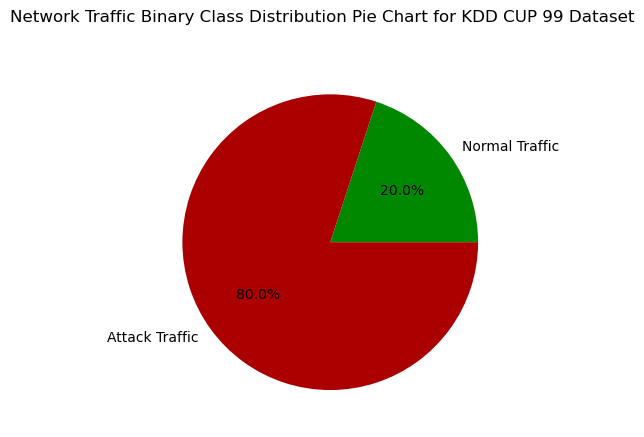

In [70]:
labels = ['Normal Traffic', 'Attack Traffic']
colors = {1: "#AA0000", 0: '#008800'} 

show_pie_chart_target_variable(eda_kdd_cup_df, labels, colors, 'Network Traffic Binary Class Distribution Pie Chart for KDD CUP 99 Dataset')

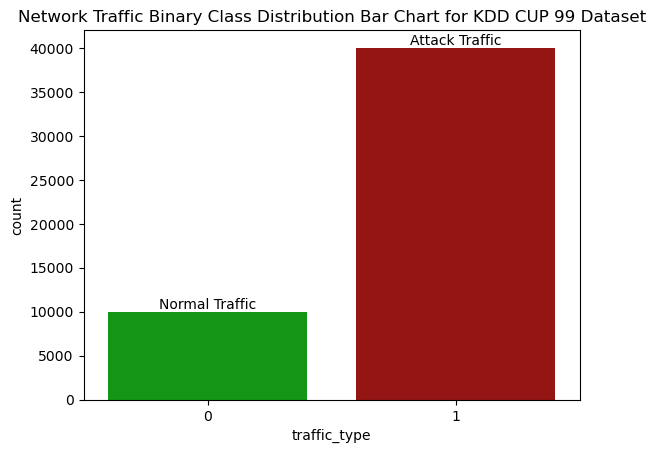

In [71]:
labels = ['Normal Traffic', 'Attack Traffic']
colors = ['#00AA00',"#AA0000"]

show_bar_chart_target_variable(eda_kdd_cup_df, target_variable, labels, colors, 'Network Traffic Binary Class Distribution Bar Chart for KDD CUP 99 Dataset')

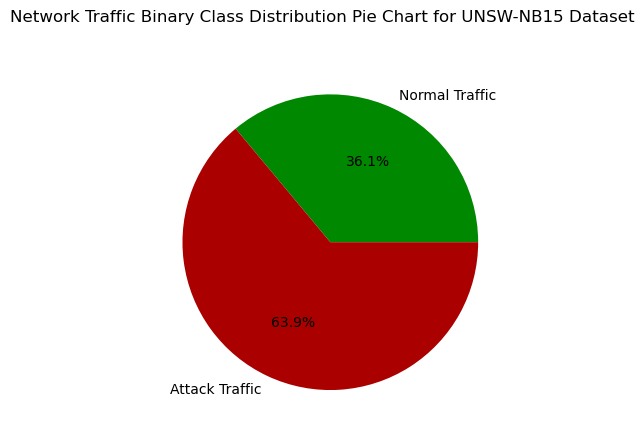

In [72]:
labels = ['Normal Traffic', 'Attack Traffic']
colors = {1: "#AA0000", 0: '#008800'} 

show_pie_chart_target_variable(eda_unsw_nb15_df, labels, colors, 'Network Traffic Binary Class Distribution Pie Chart for UNSW-NB15 Dataset')

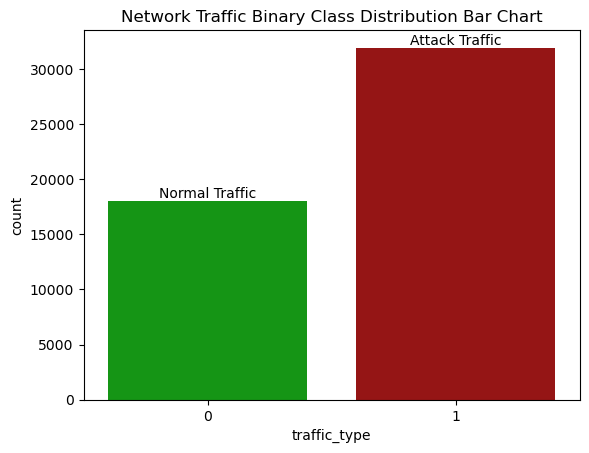

In [73]:
labels = ['Normal Traffic', 'Attack Traffic']
colors = ['#00AA00',"#AA0000"]

show_bar_chart_target_variable(eda_unsw_nb15_df, target_variable, labels, colors, 'Network Traffic Binary Class Distribution Bar Chart')

In [74]:
eda_kdd_cup_df = eda_kdd_cup_df.drop([target_variable], axis=1)
eda_unsw_nb15_df = eda_unsw_nb15_df.drop([target_variable], axis=1)

In [75]:
eda_kdd_cup_99_categorical_features, eda_kdd_cup_99_continuous_features = split_dataframe_into_continuious_categorical_column_names(eda_kdd_cup_df)

In [76]:
eda_unsw_nb15_categorical_features, eda_unsw_nb15_continuous_features = split_dataframe_into_continuious_categorical_column_names(eda_unsw_nb15_df)




Summary for PROTOCOL_TYPE feature value counts

icmp    28765
tcp     19318
udp      1917
Name: protocol_type, dtype: int64



Summary for FLAG feature value counts

SF        38099
S0         9035
REJ        2697
RSTR         94
RSTO         46
S1           12
SH           10
RSTOS0        3
OTH           2
S2            1
S3            1
Name: flag, dtype: int64



Summary for SERVICE feature value counts

ecr_i          28529
private        11345
http            6450
smtp             956
other            717
domain_u         580
ftp_data         452
eco_i            179
finger            69
urp_i             52
ftp               47
telnet            43
ntp_u             36
auth              28
pop_3             22
netbios_ssn       17
nntp              17
time              16
login             16
daytime           16
whois             16
imap4             14
discard           13
netbios_ns        13
rje               13
bgp               12
netstat           12
printer           

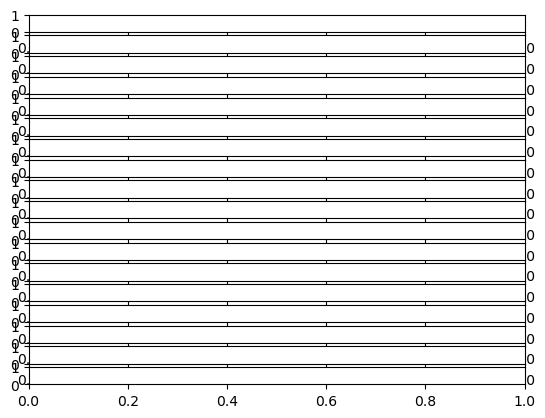

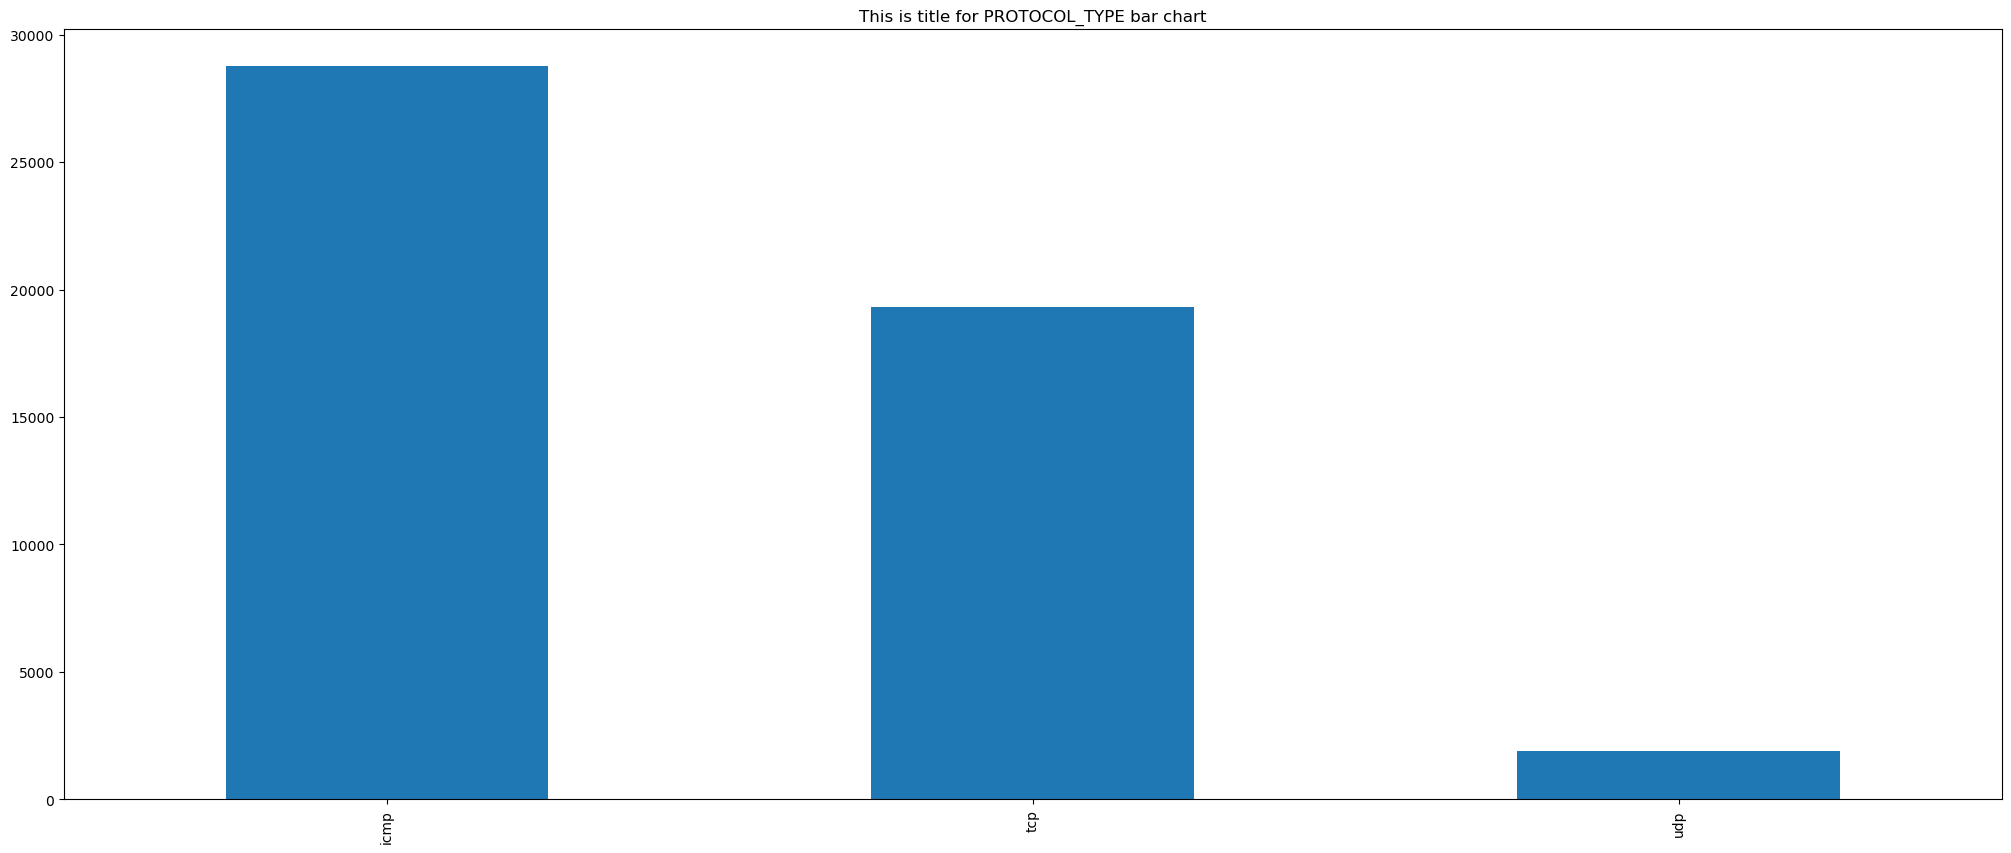

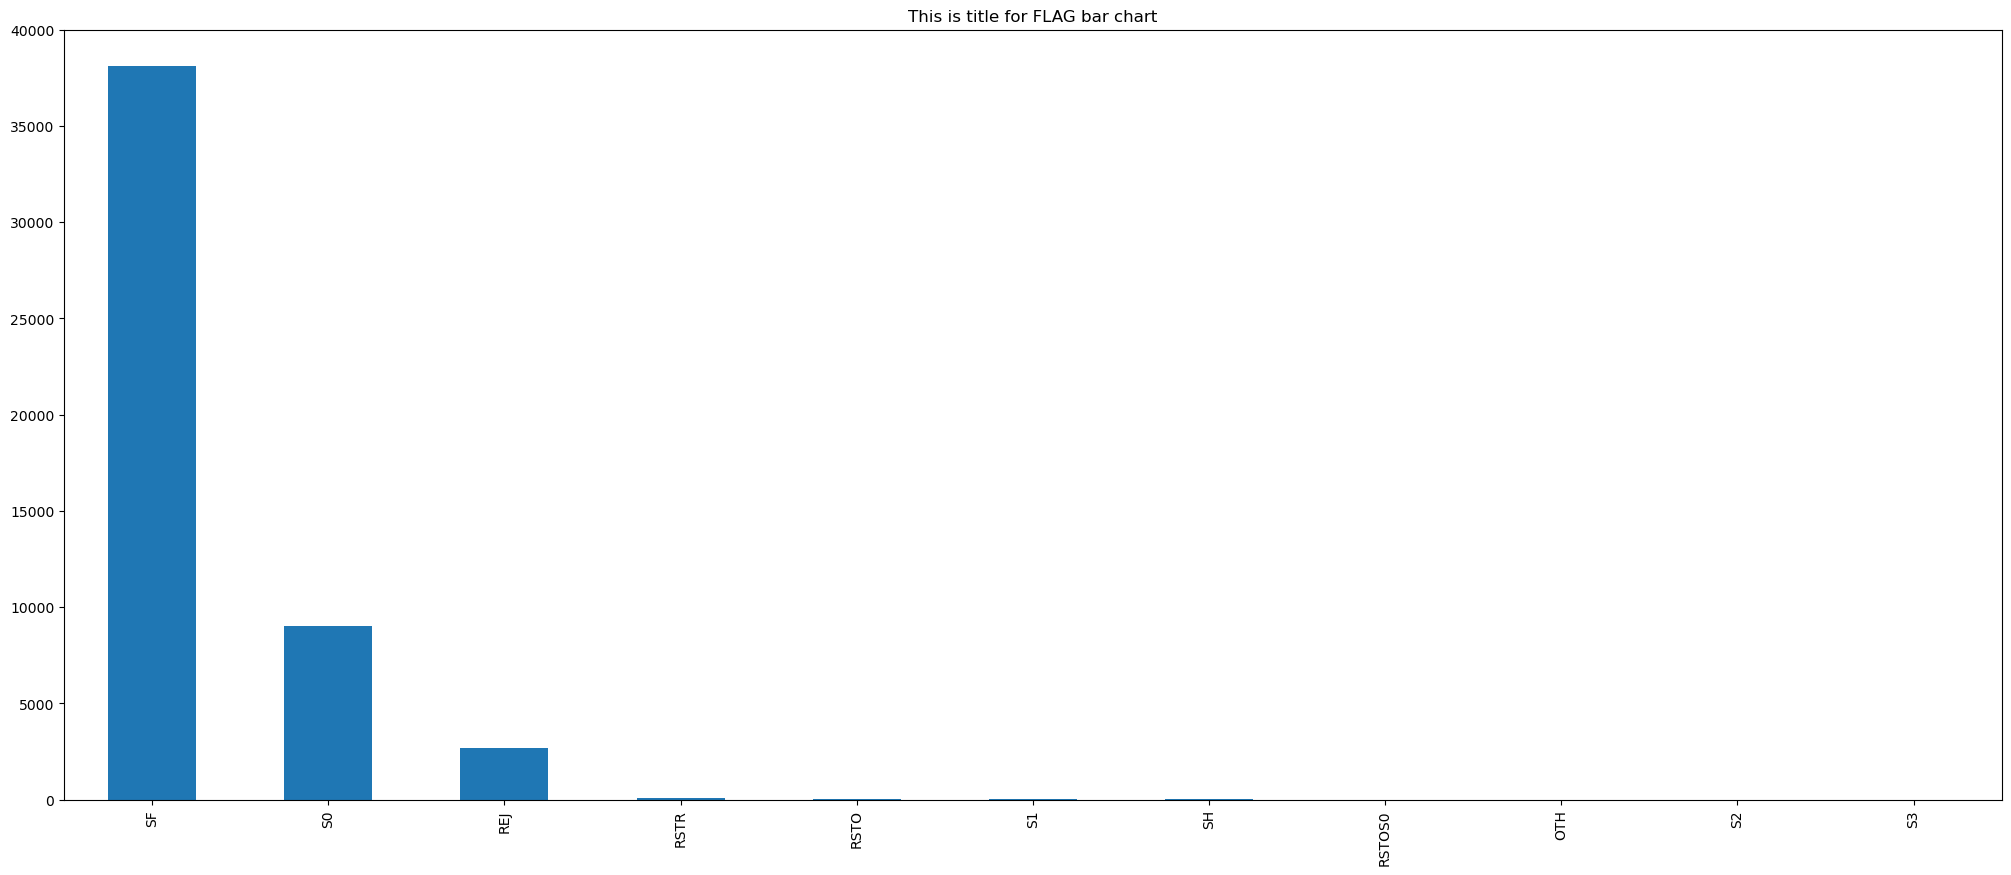

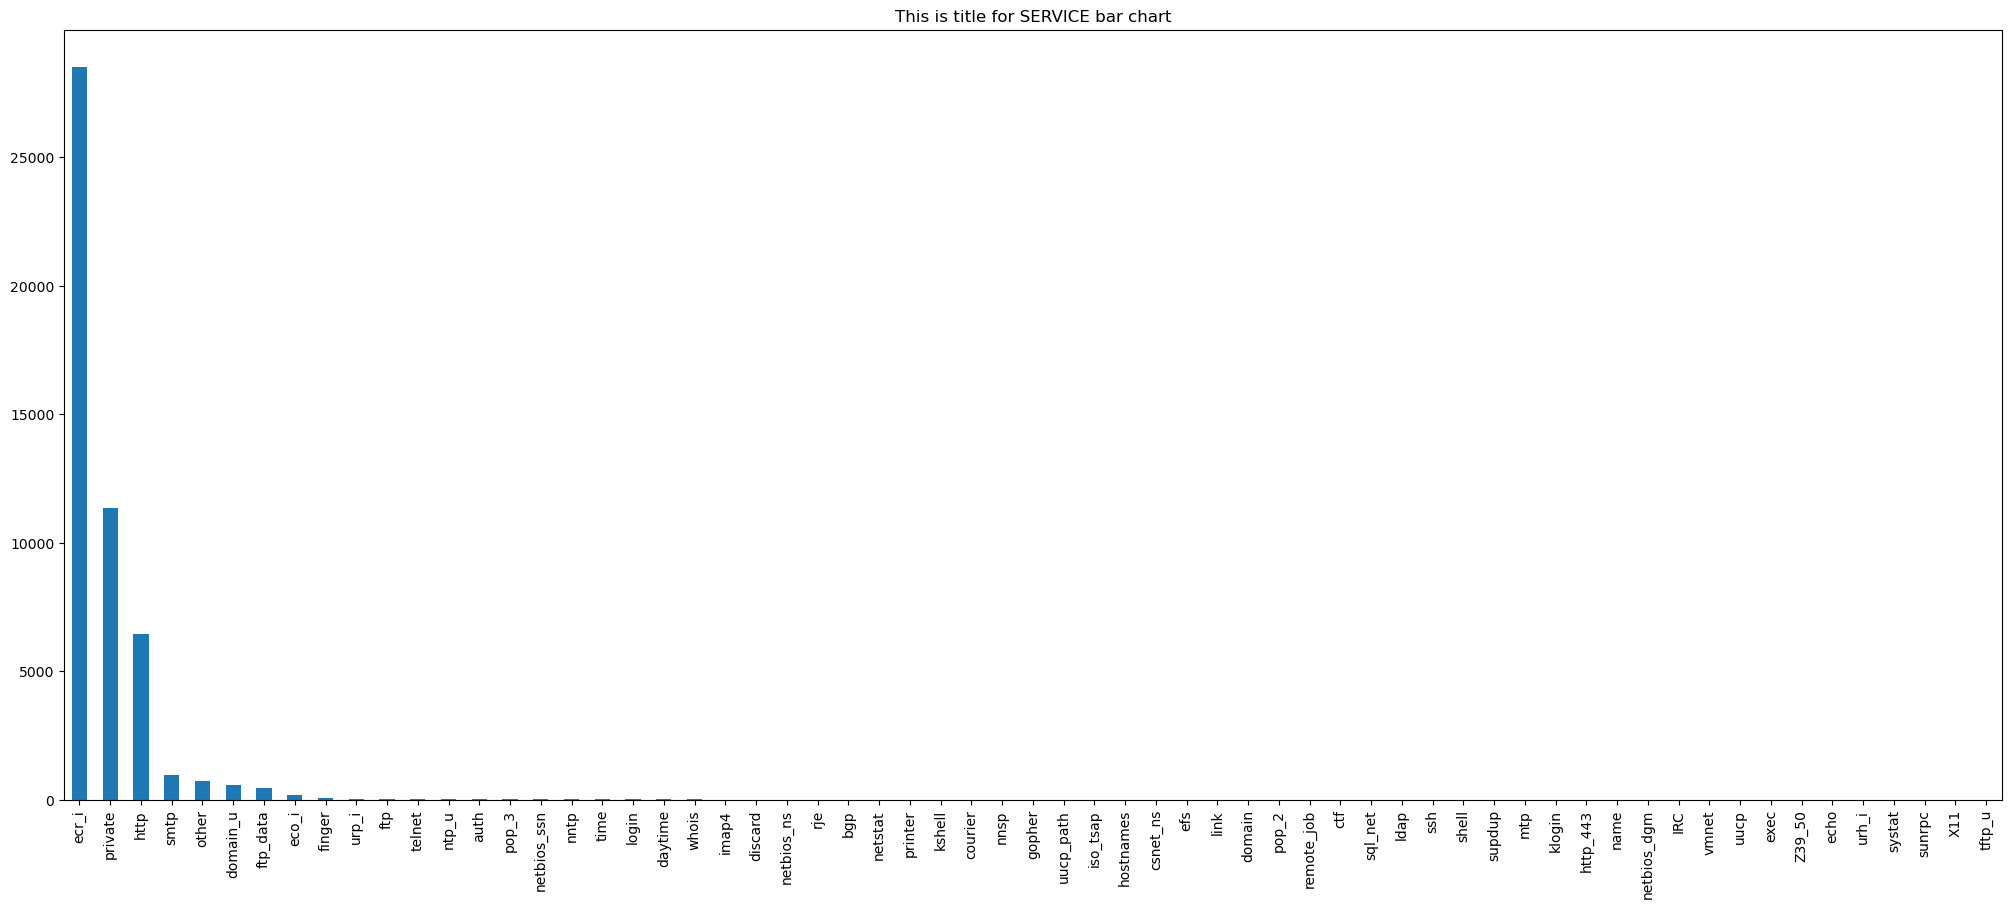

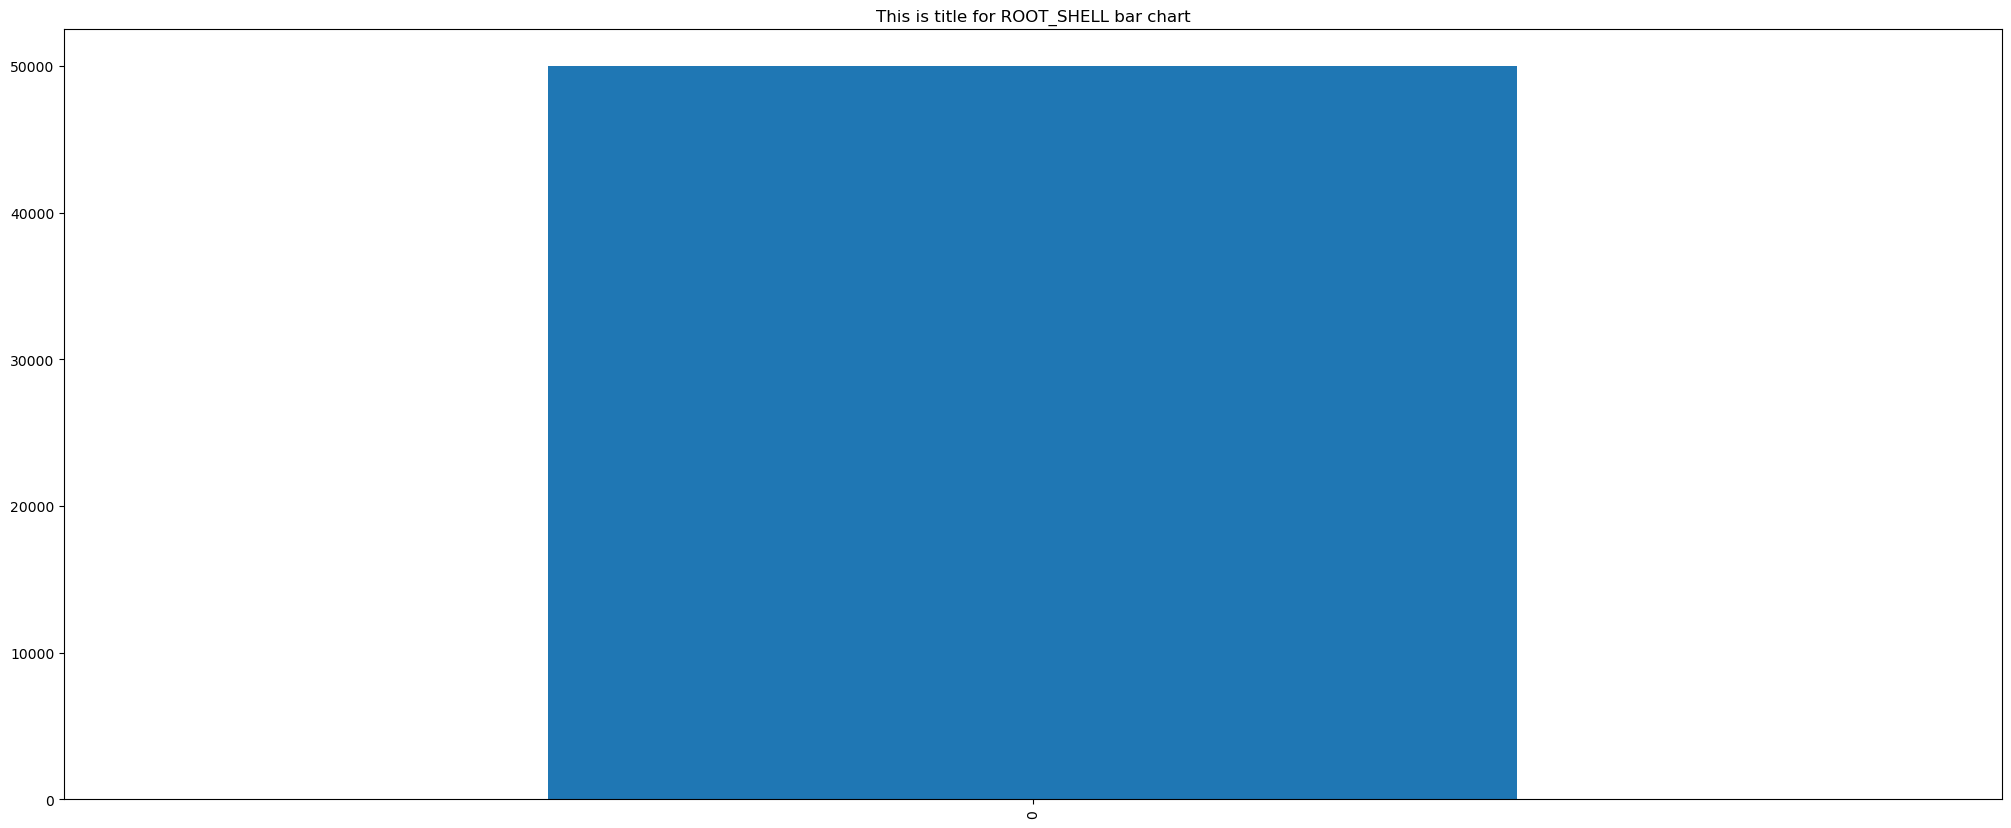

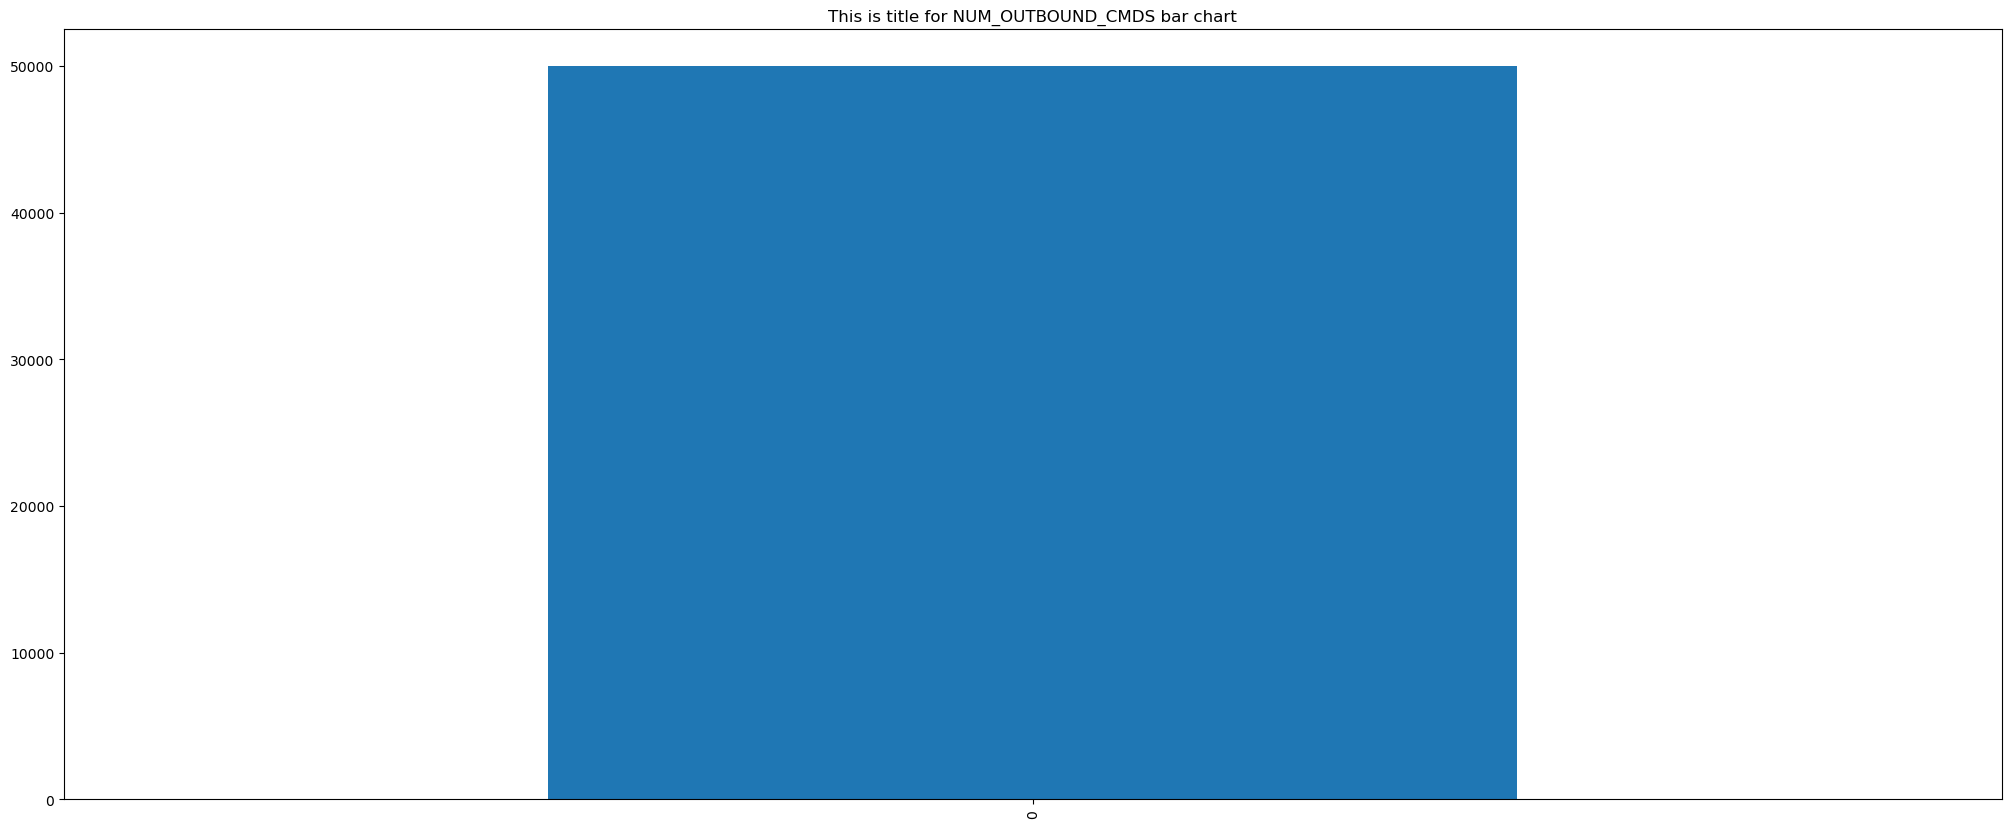

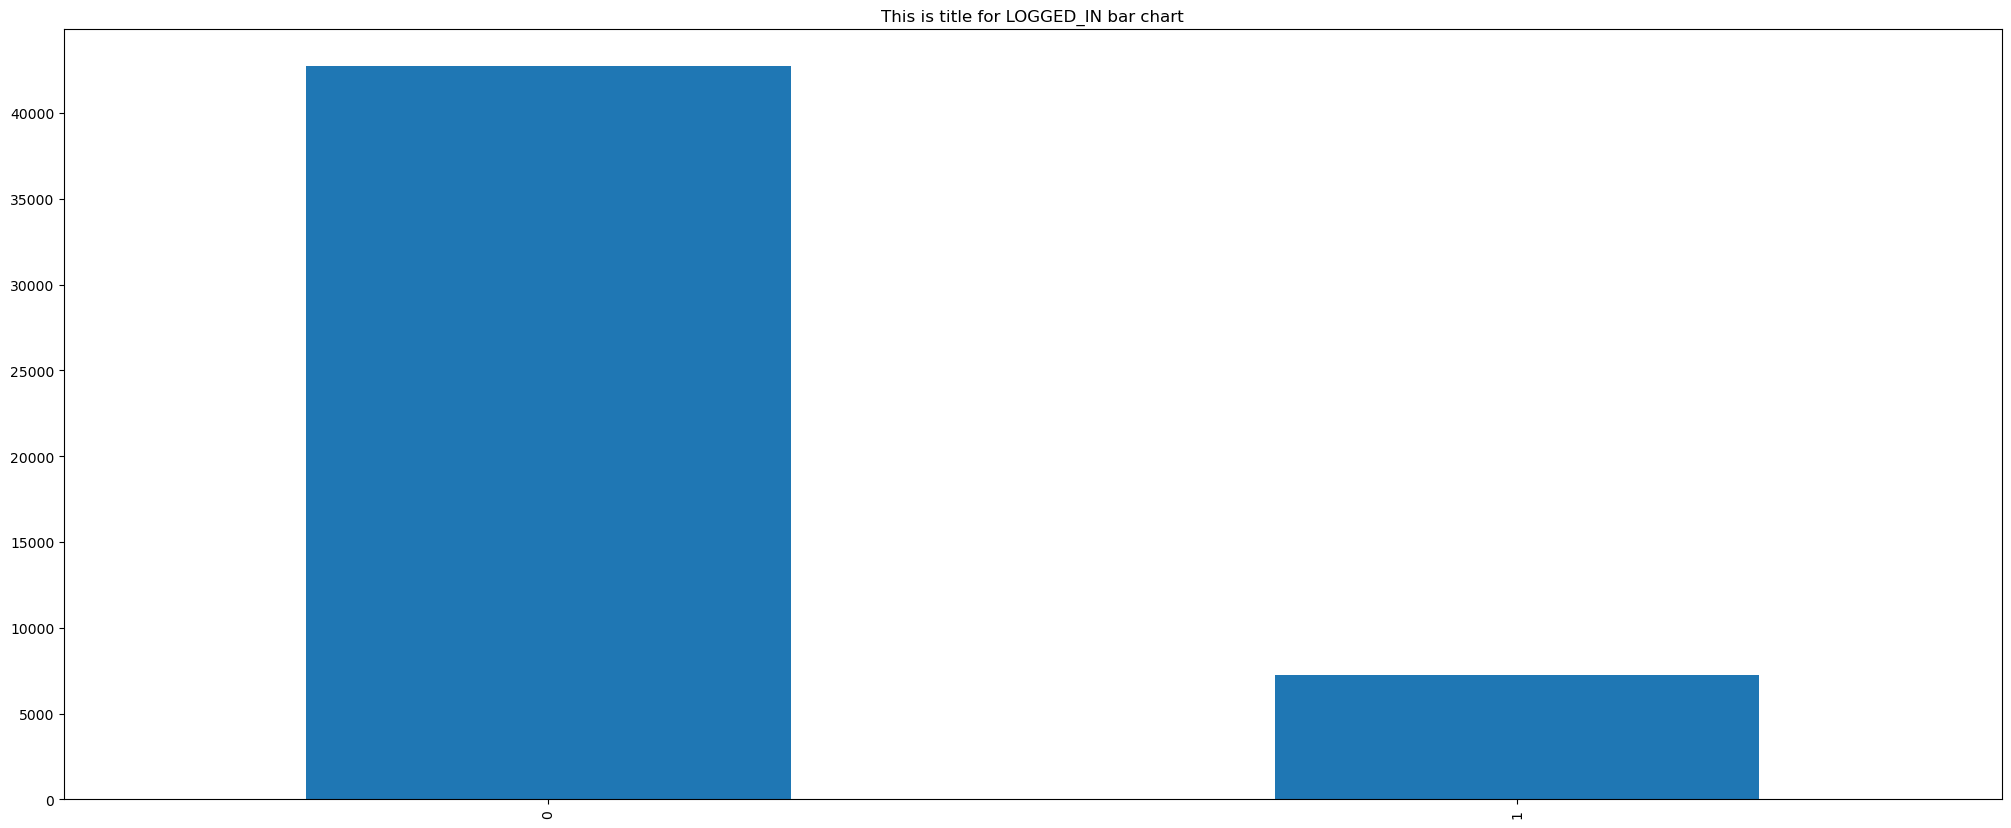

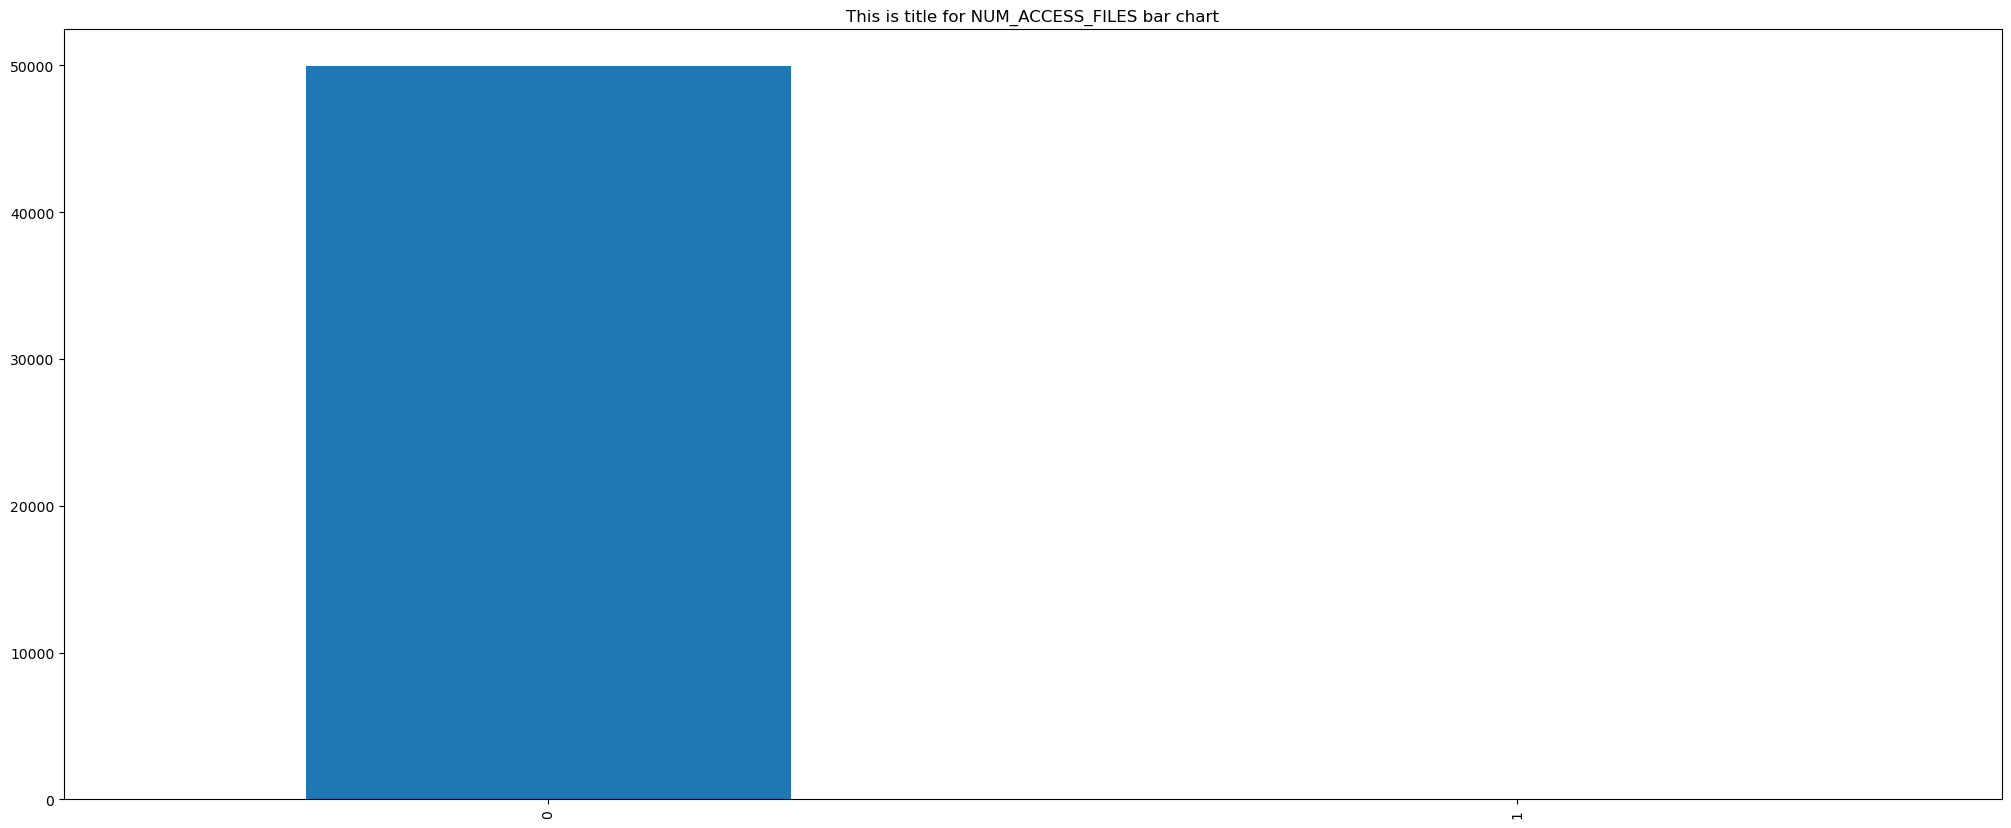

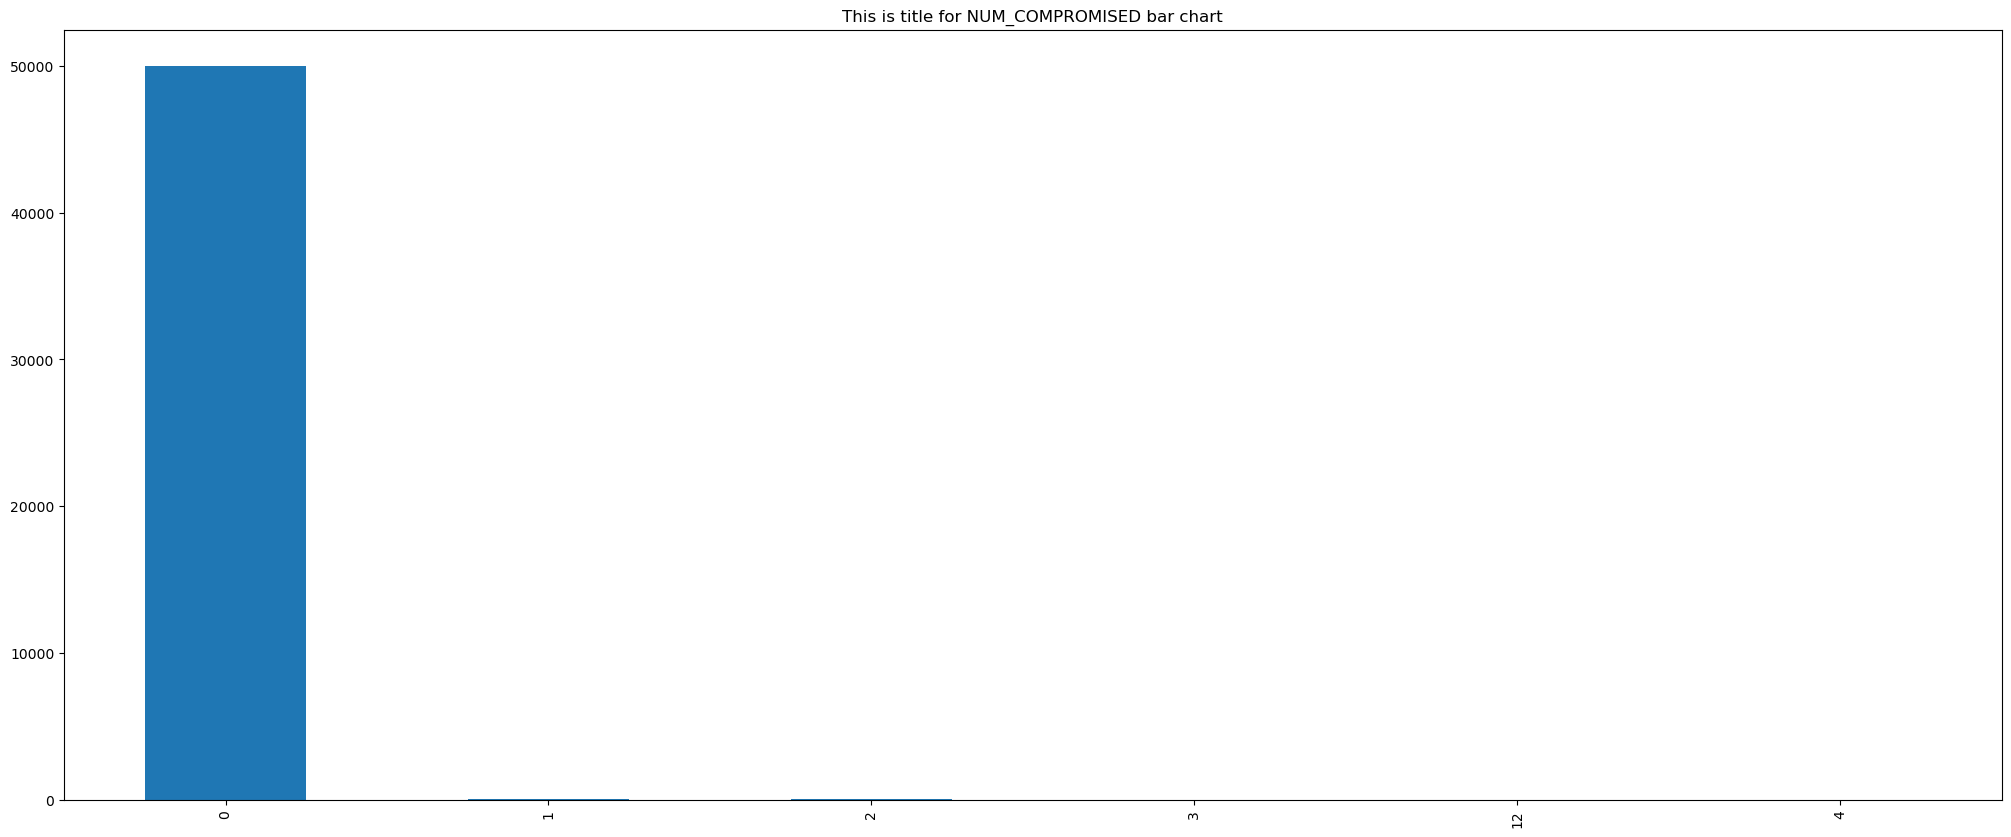

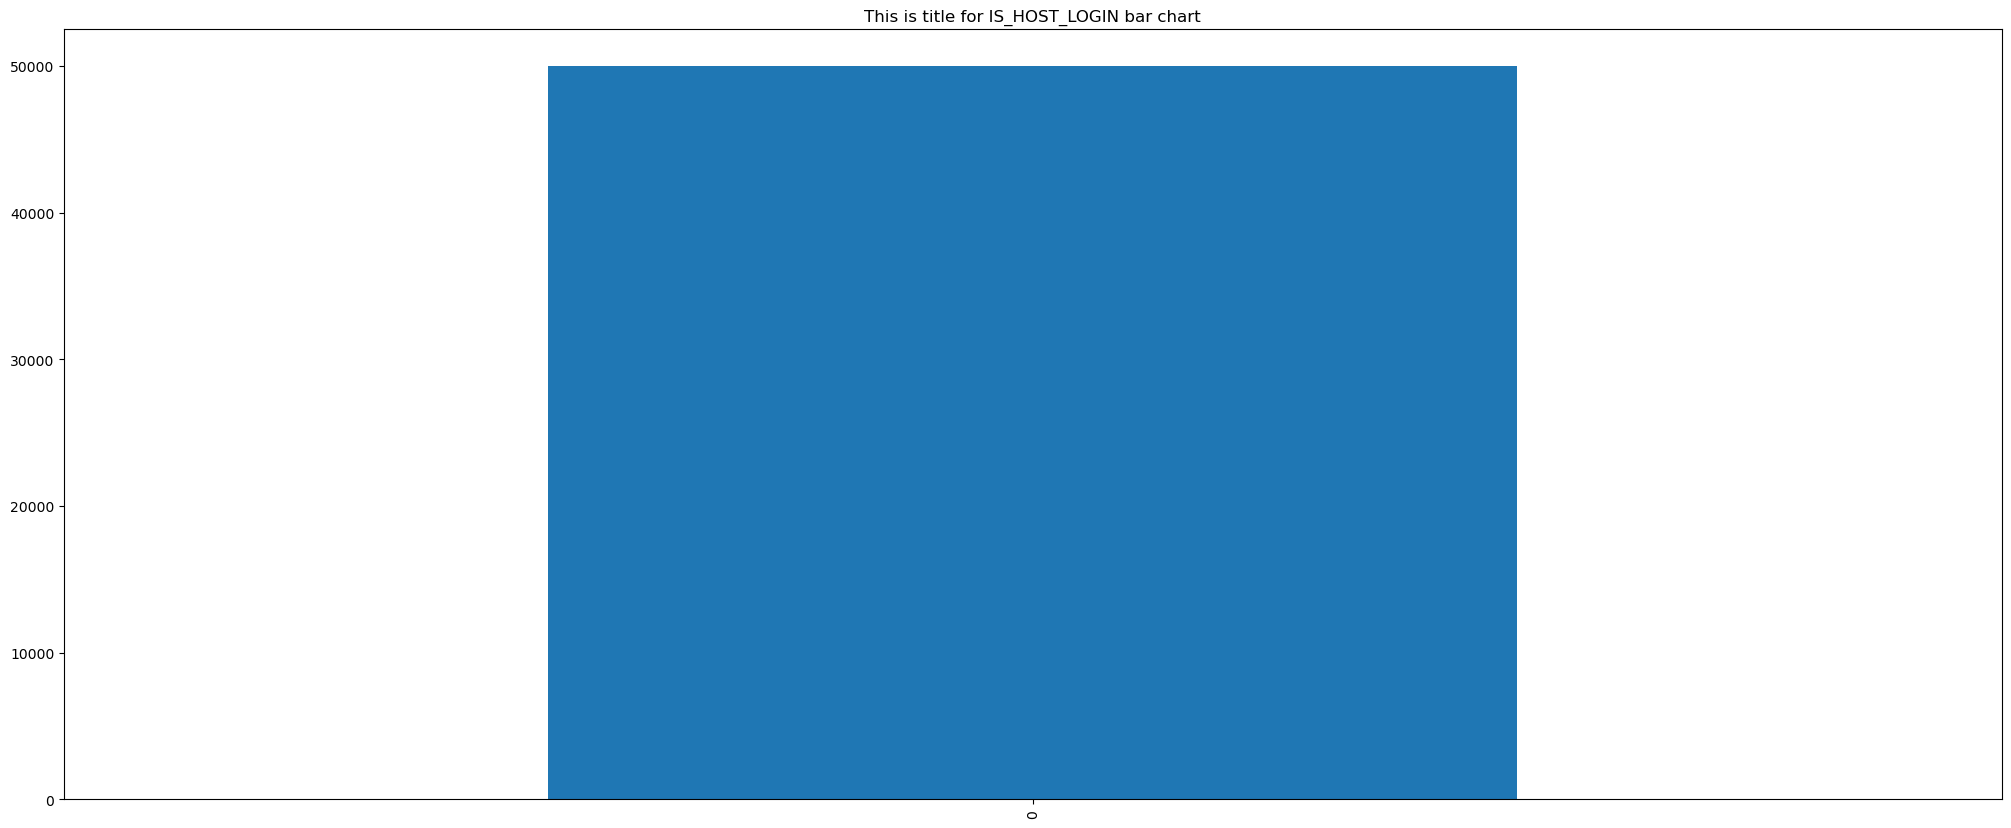

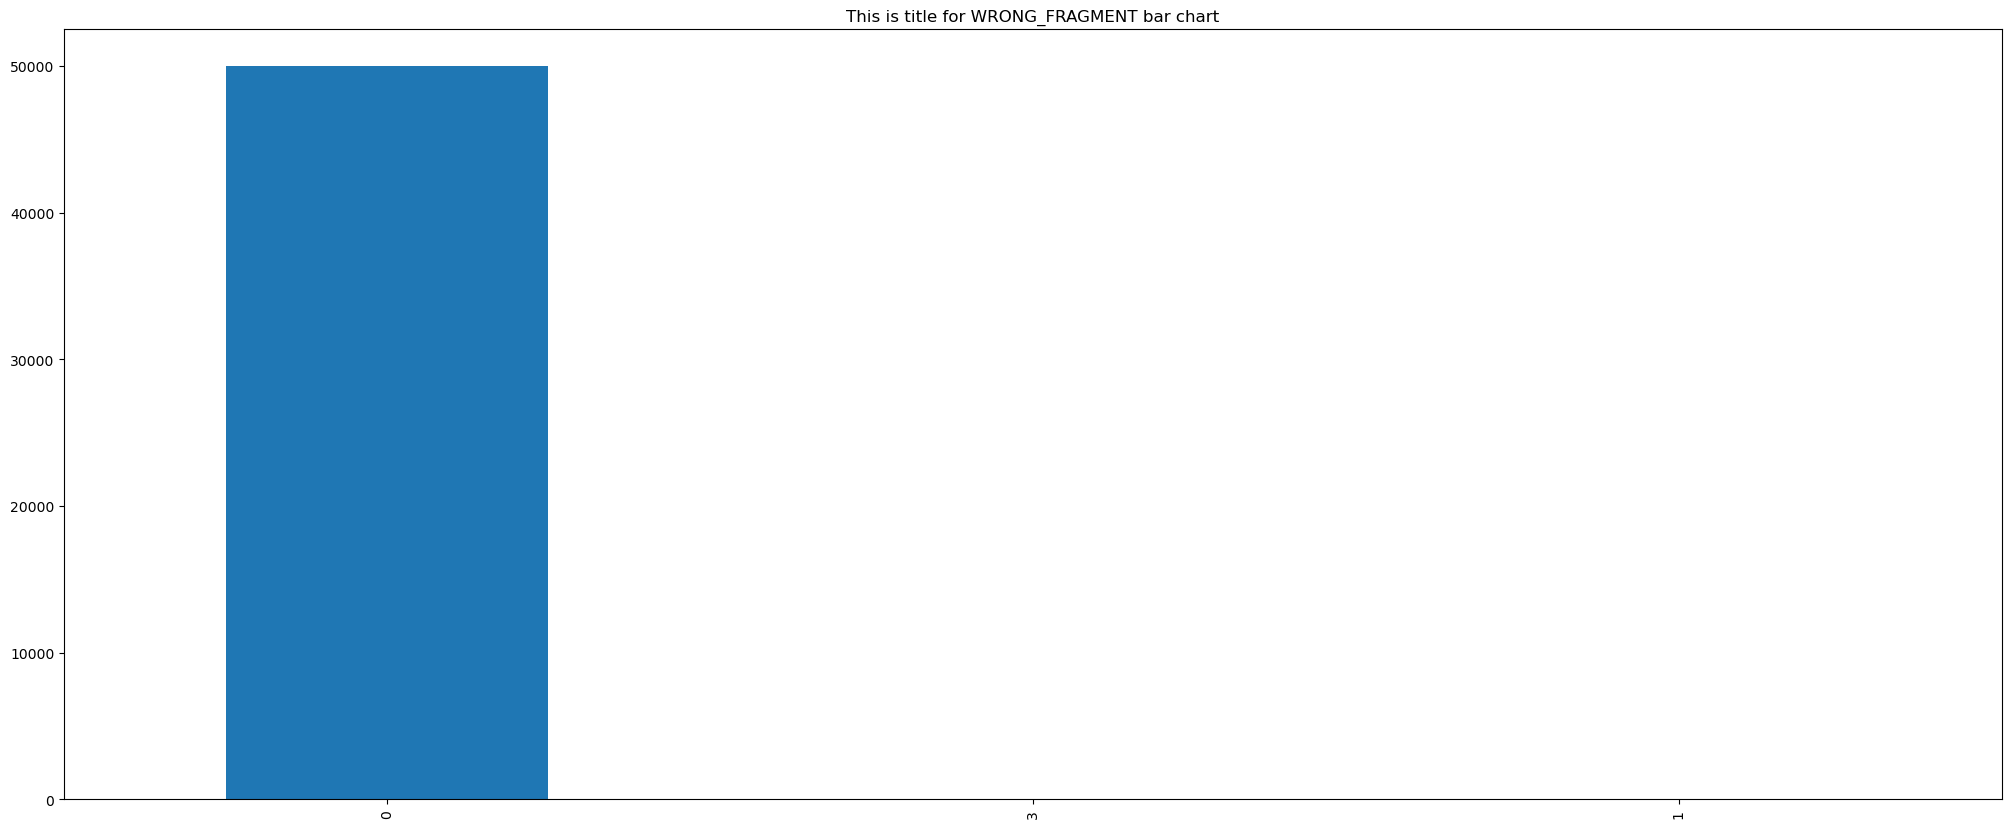

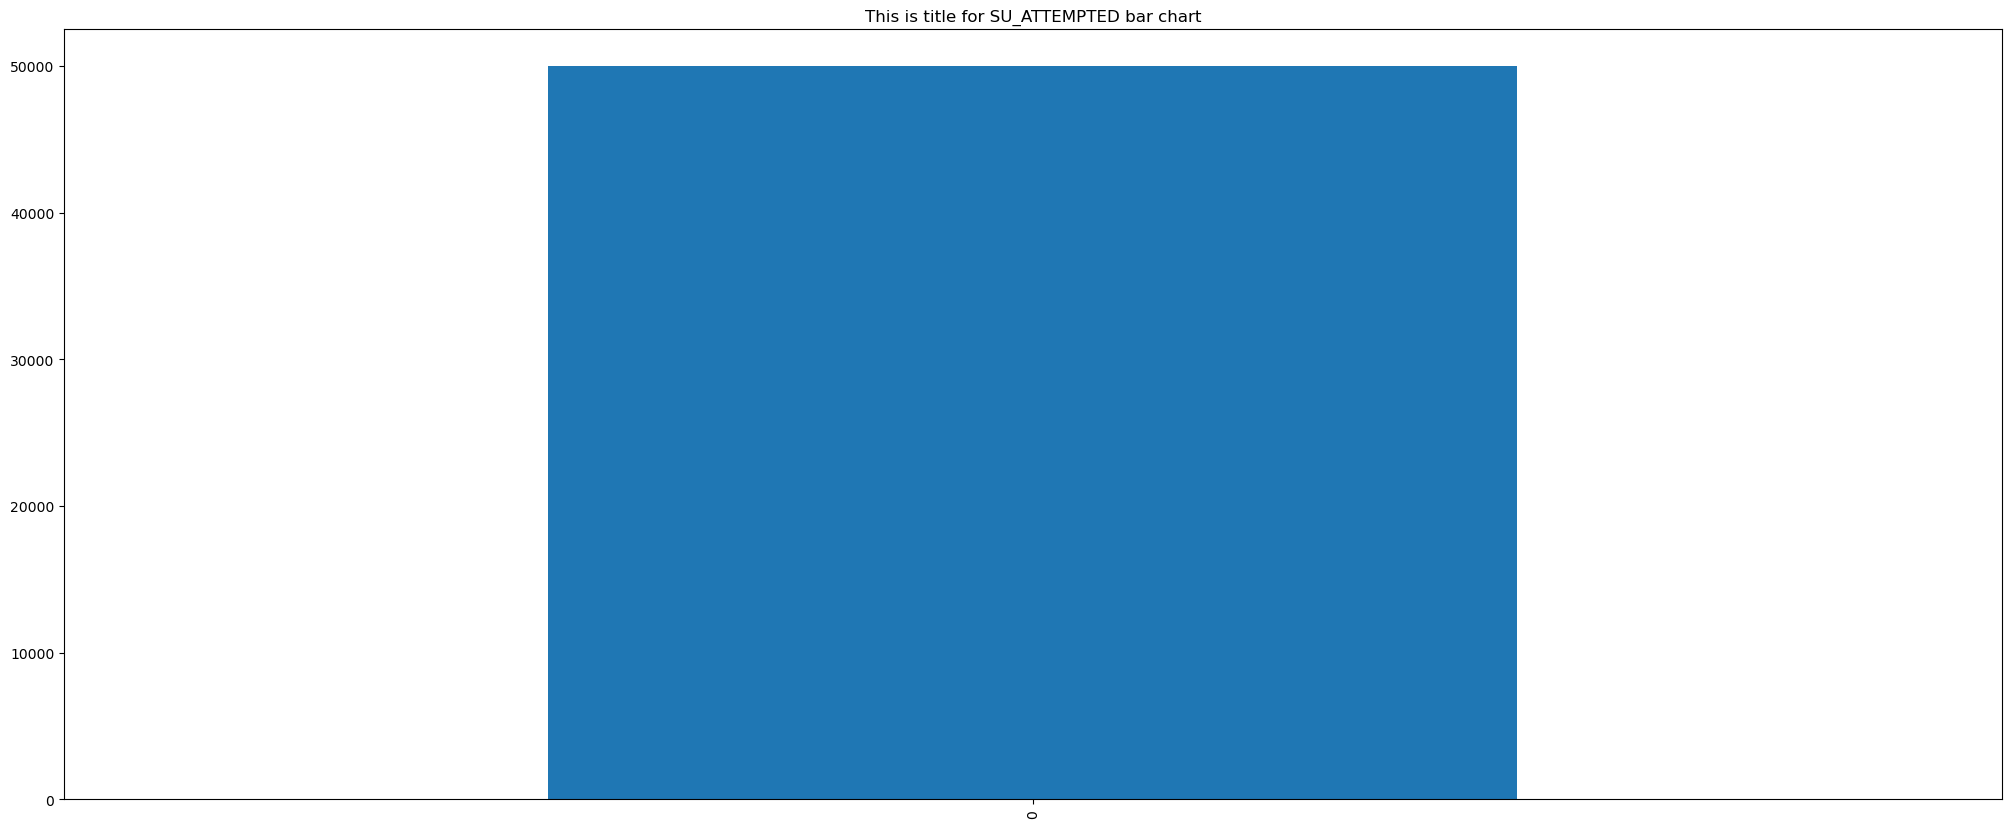

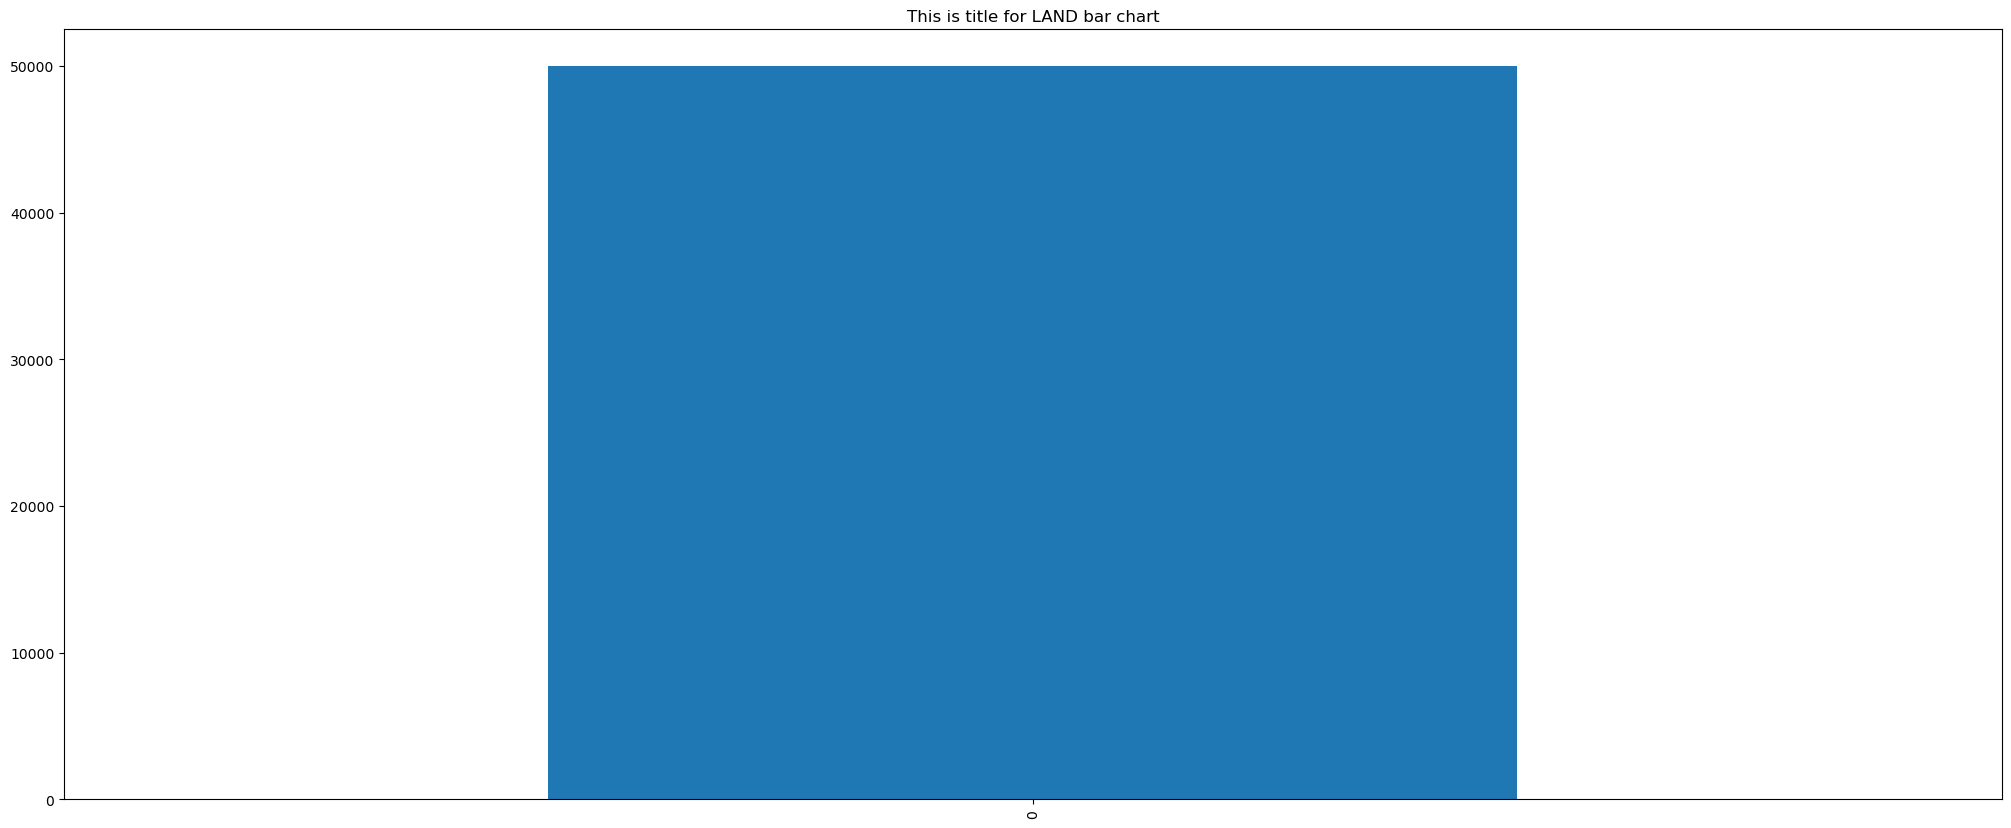

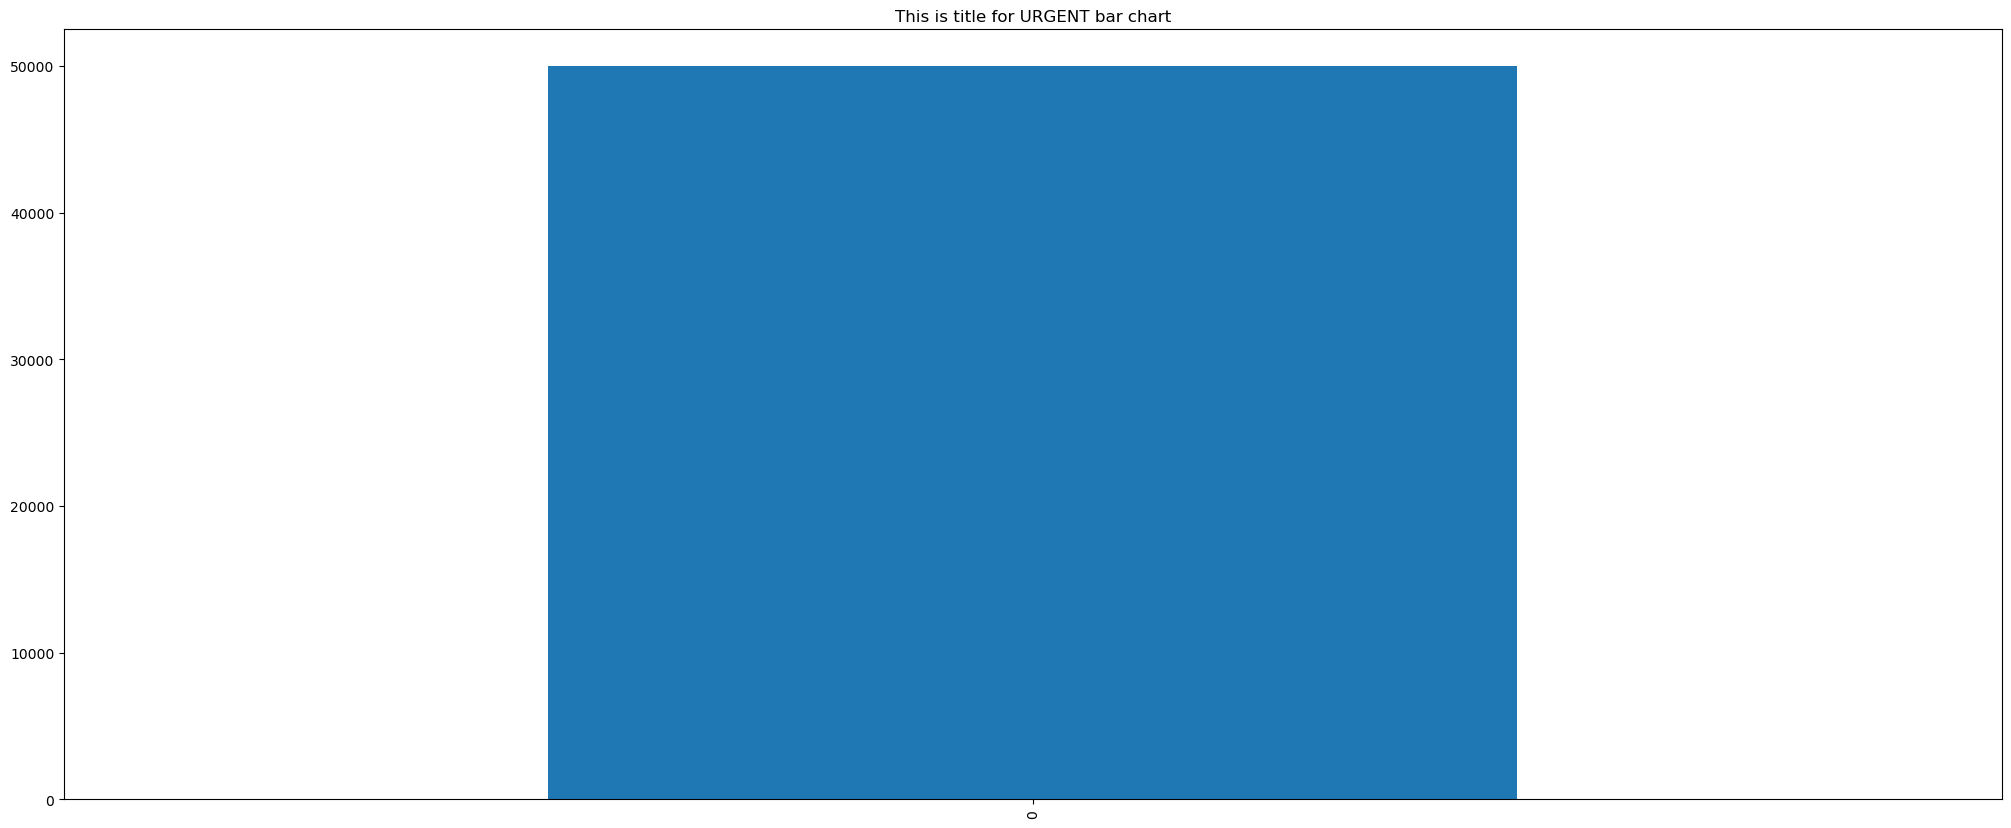

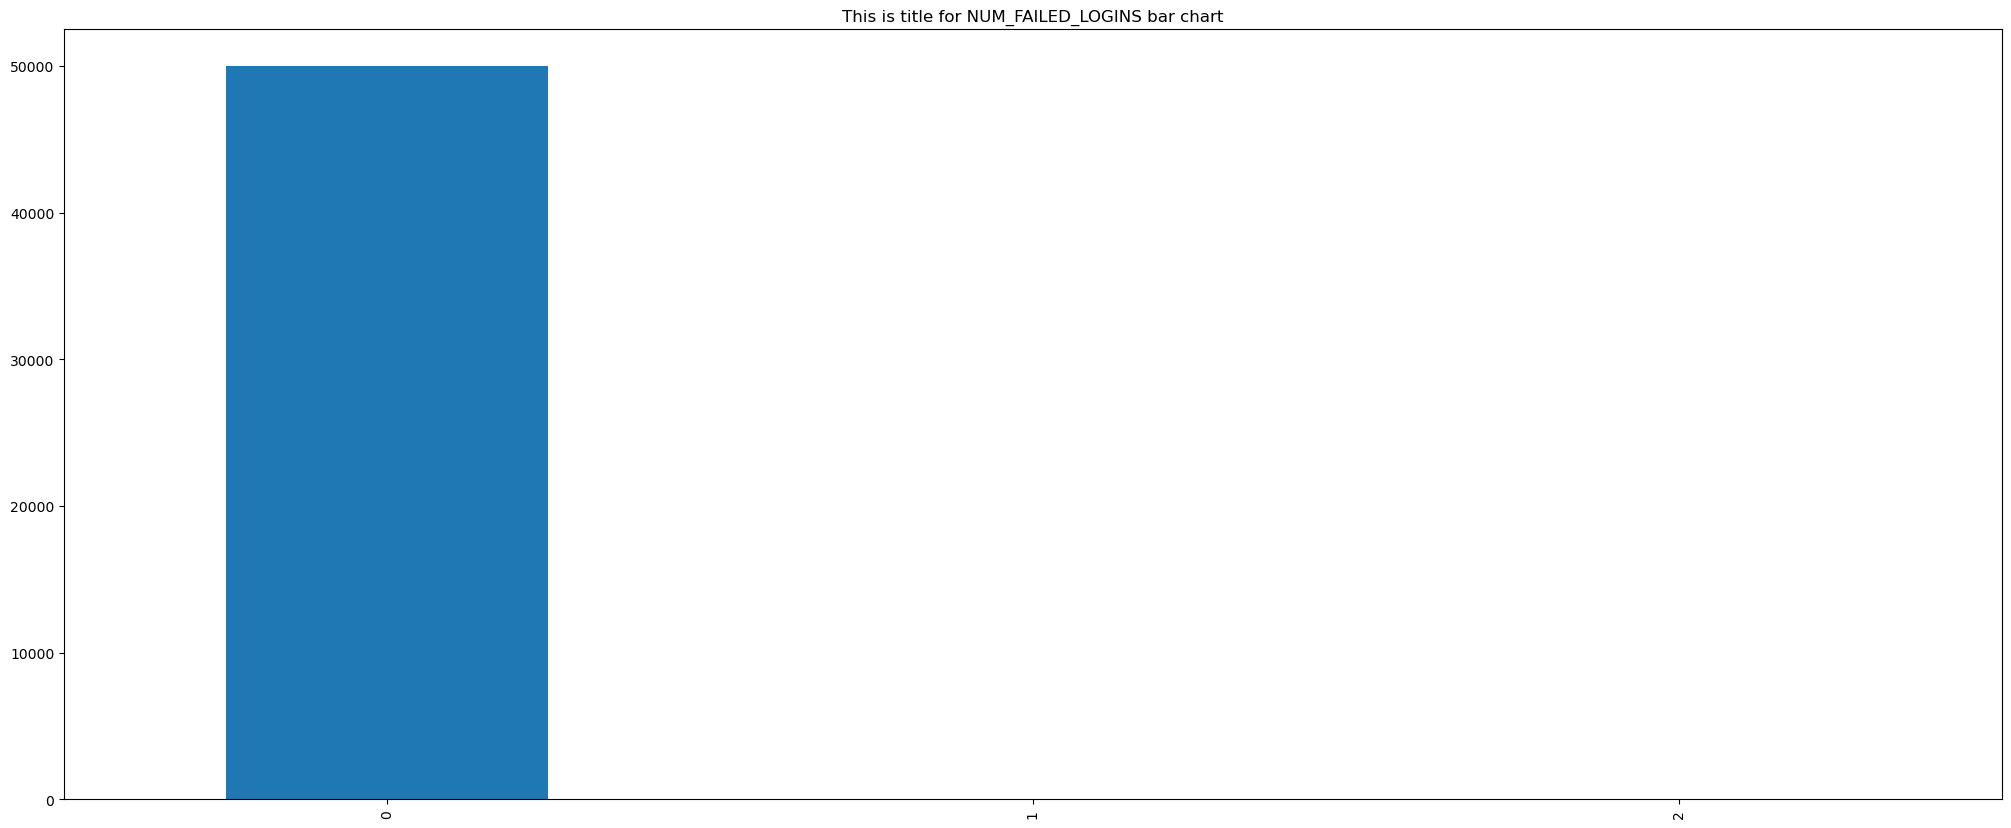

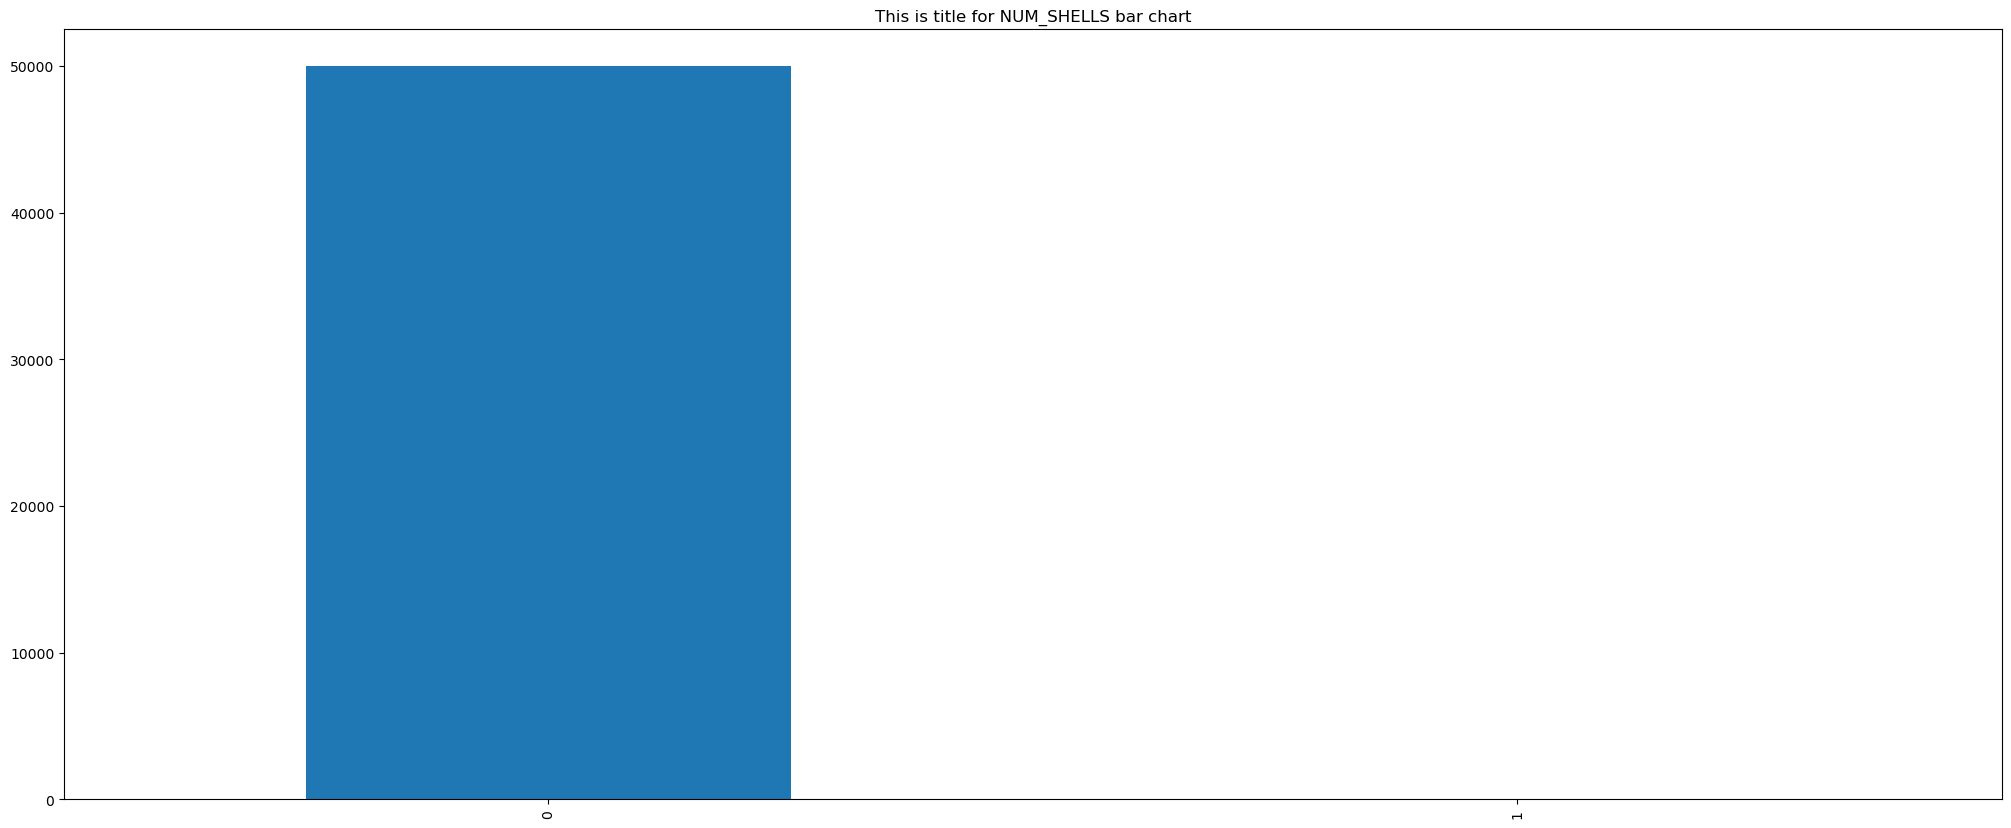

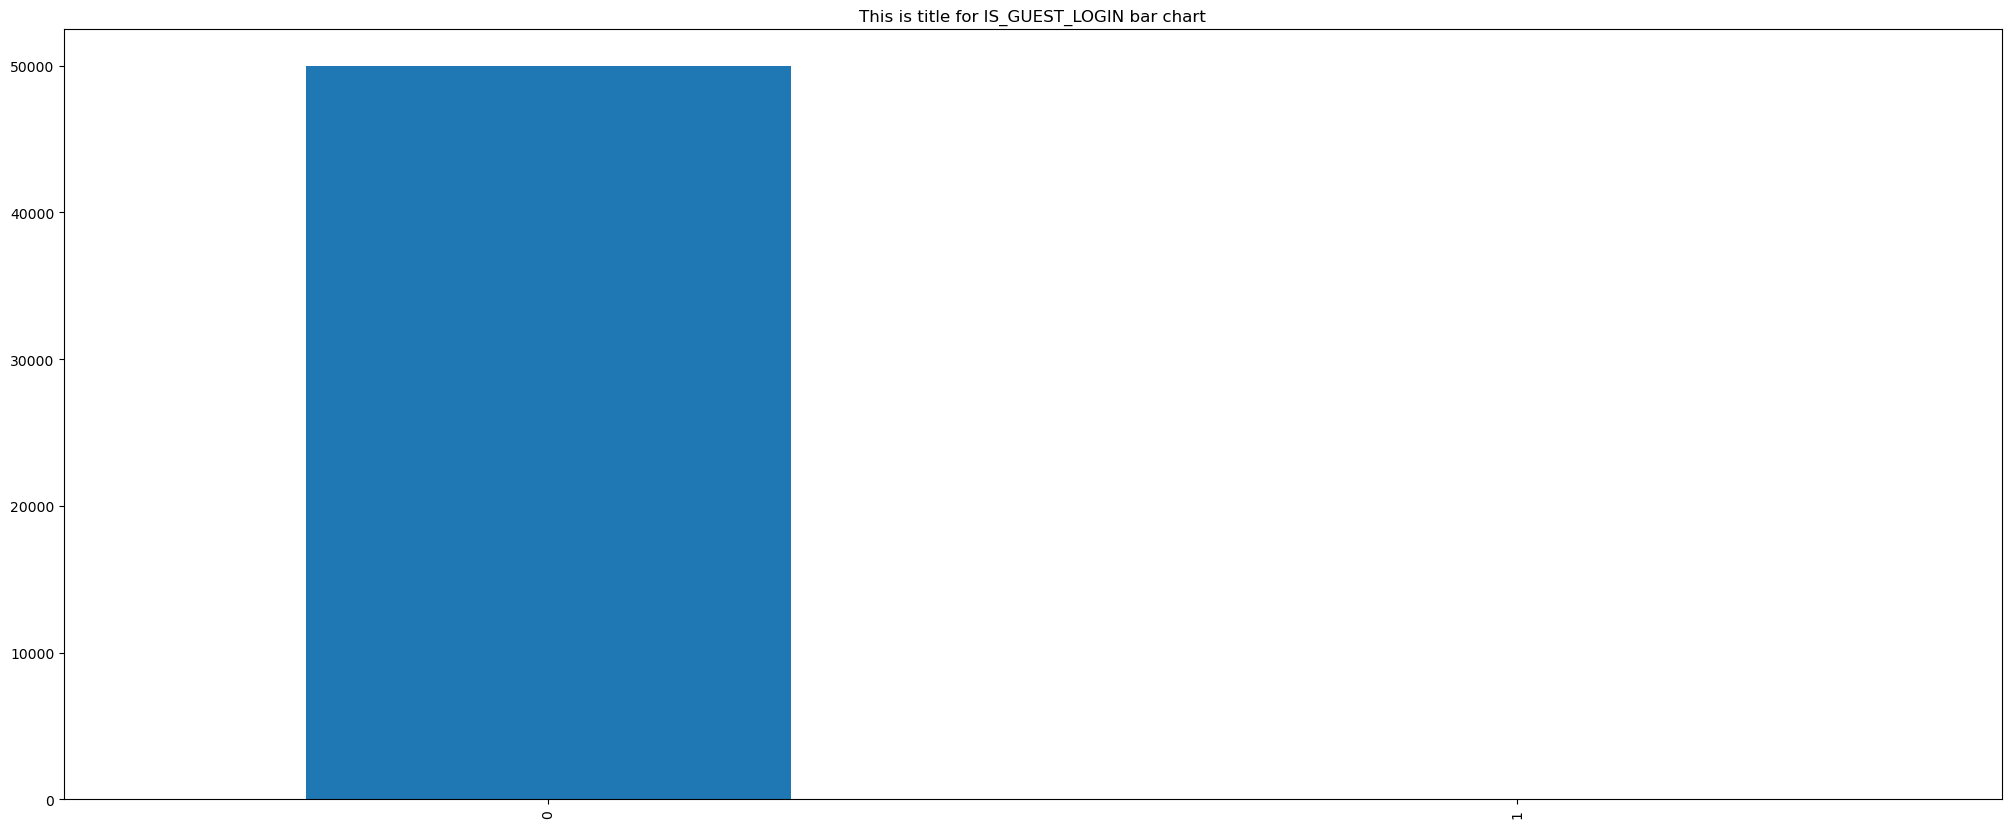

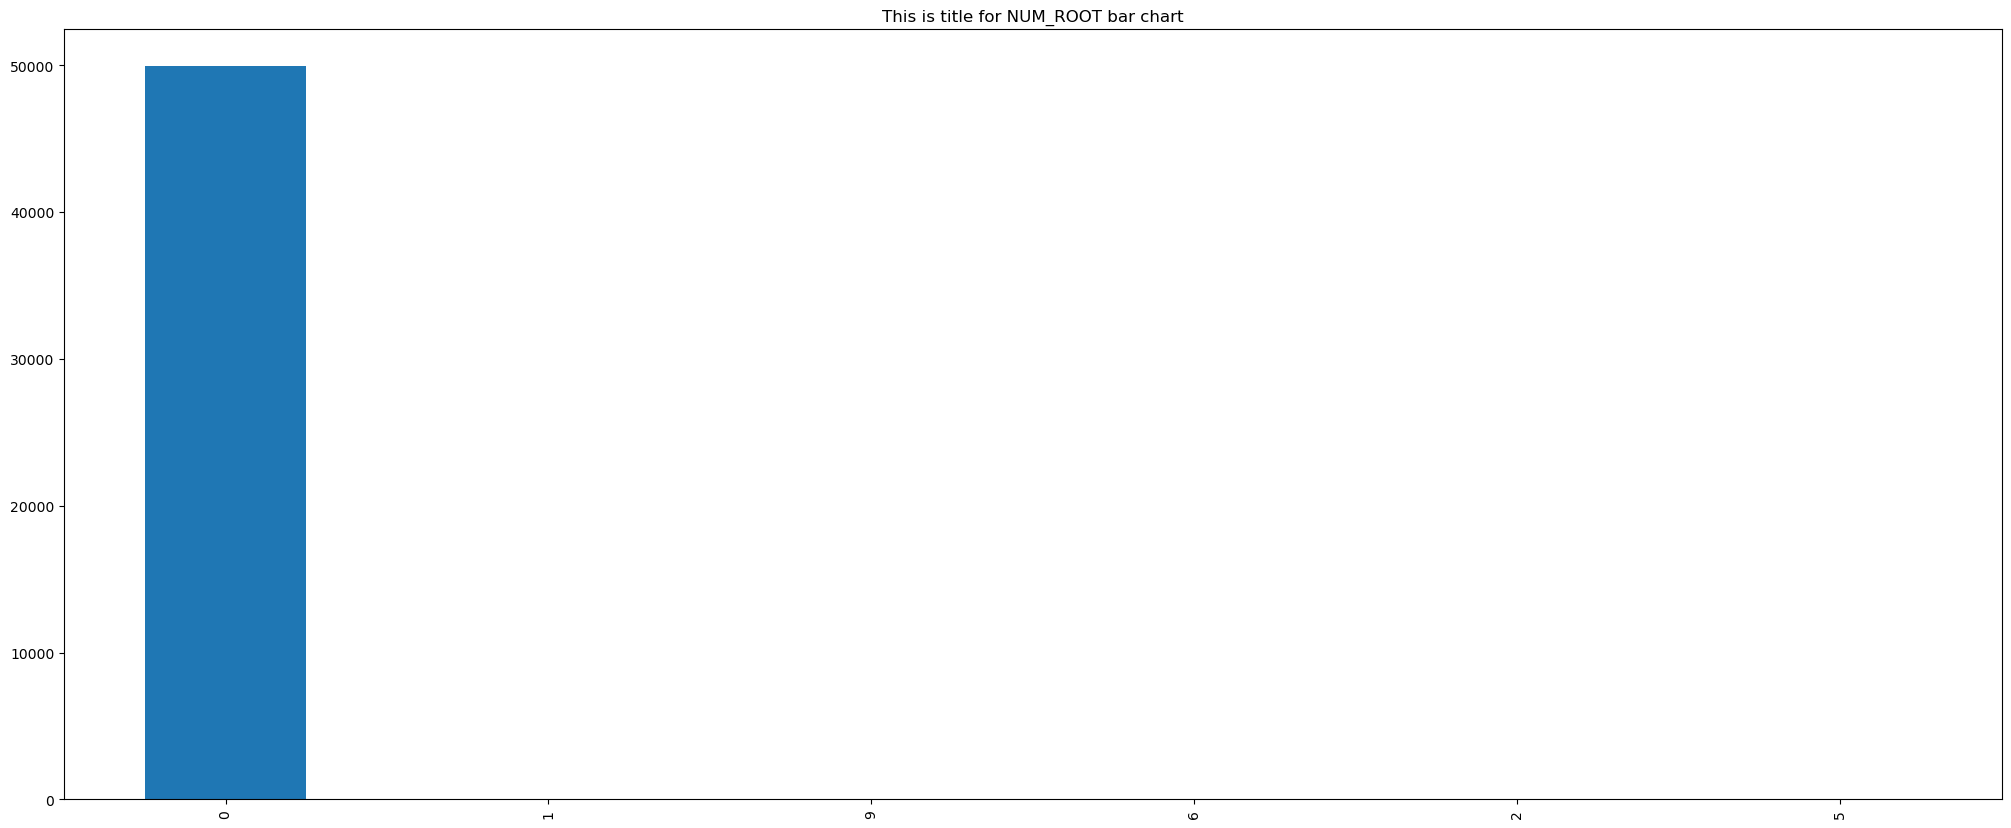

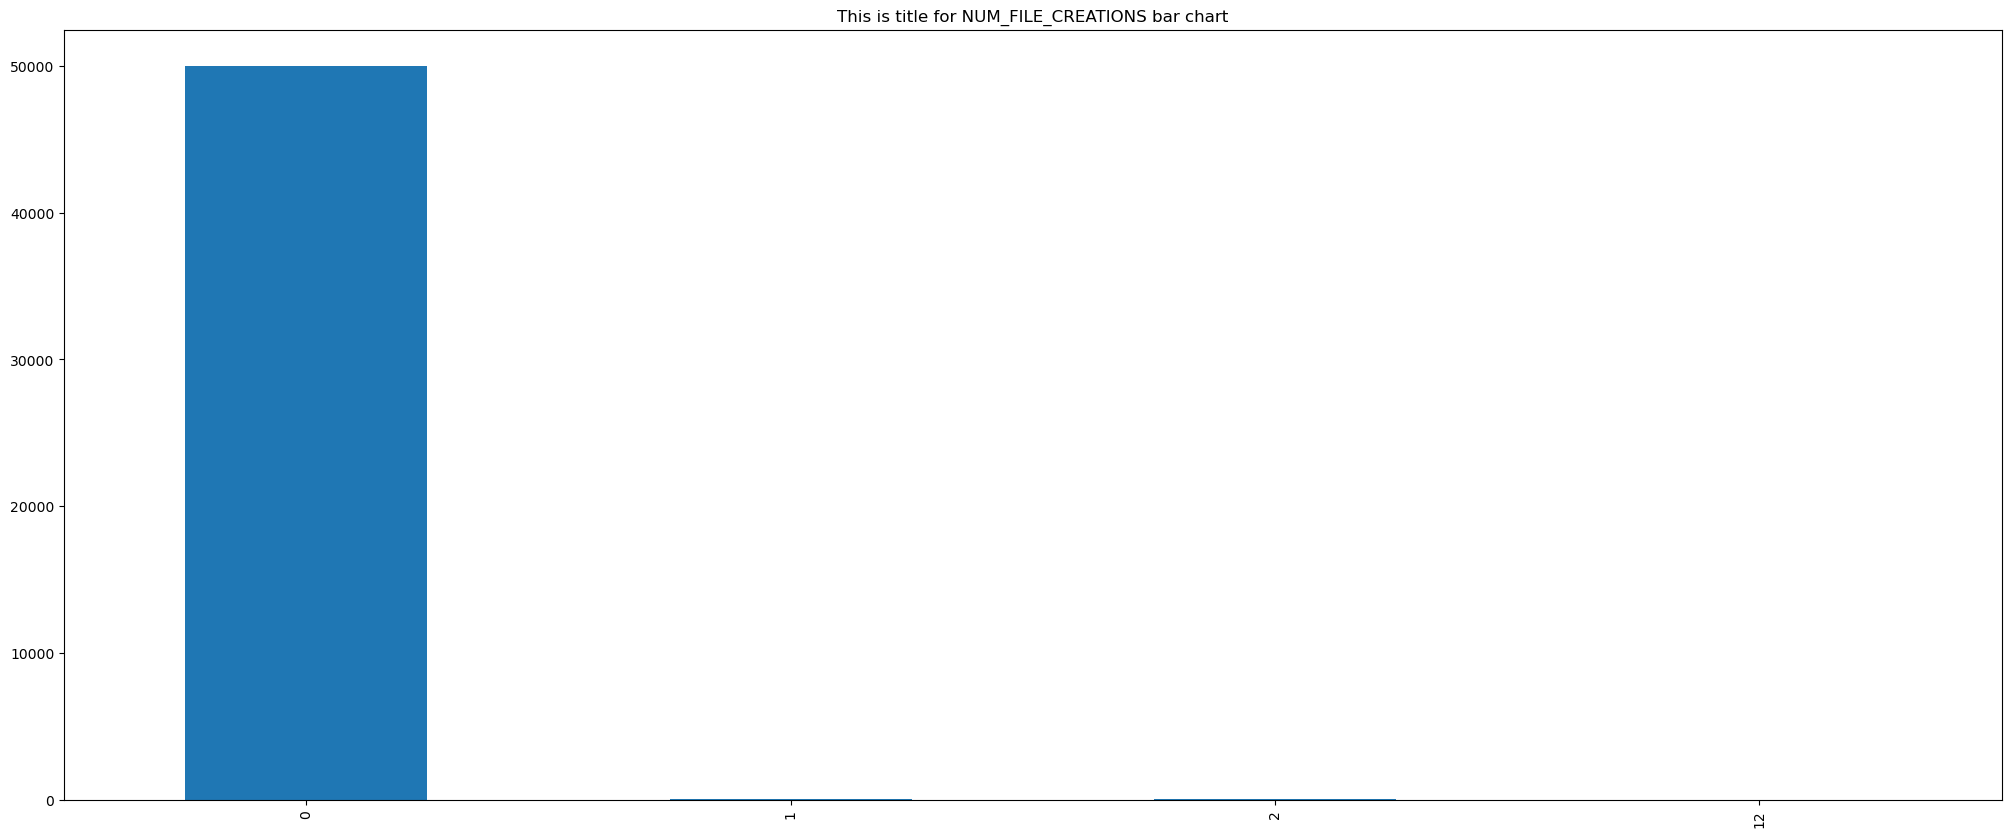

In [77]:
show_bar_plots_for_all_categorical_plots(eda_kdd_cup_df, eda_kdd_cup_99_categorical_features)




Summary for STATE feature value counts

FIN    22796
INT    22548
CON     3888
REQ      745
RST       20
ECO        3
Name: state, dtype: int64



Summary for SERVICE feature value counts

-           27422
dns         13317
http         5177
smtp         1333
ftp          1044
ftp-data     1038
ssh           311
pop3          296
ssl            18
snmp           17
dhcp           16
irc             6
radius          5
Name: service, dtype: int64



Summary for PROTO feature value counts

tcp            23942
udp            17986
unas            3034
arp              691
ospf             632
sctp             288
any               82
gre               66
ipv6              53
sep               50
pim               50
swipe             48
rsvp              44
mobile            41
prm               37
idpr              36
dcn               34
visa              34
sun-nd            34
encap             33
idrp              32
argus             32
ipnip             32
cbt               32

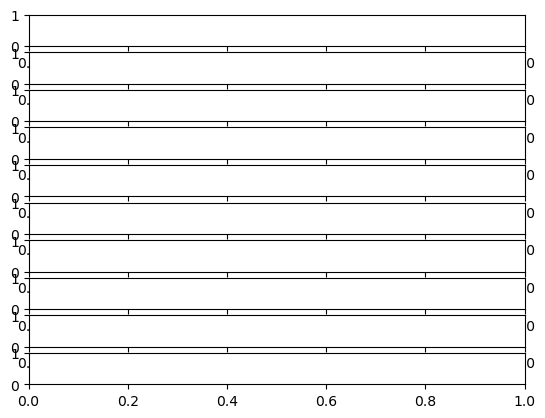

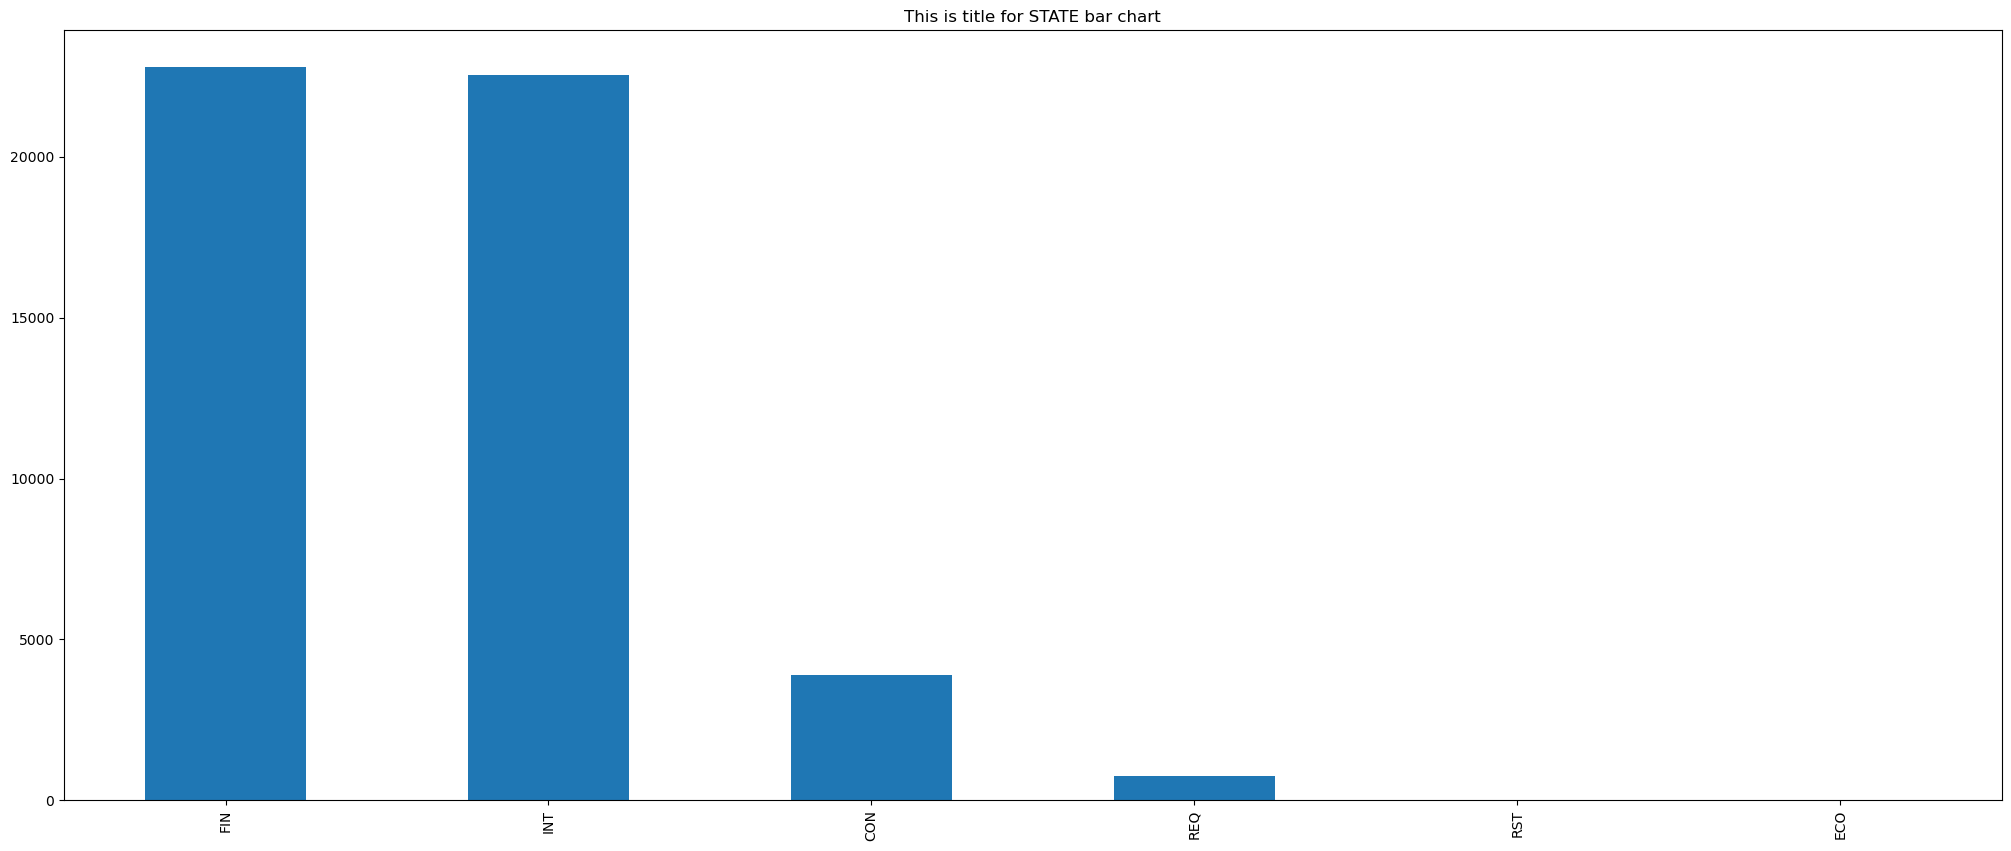

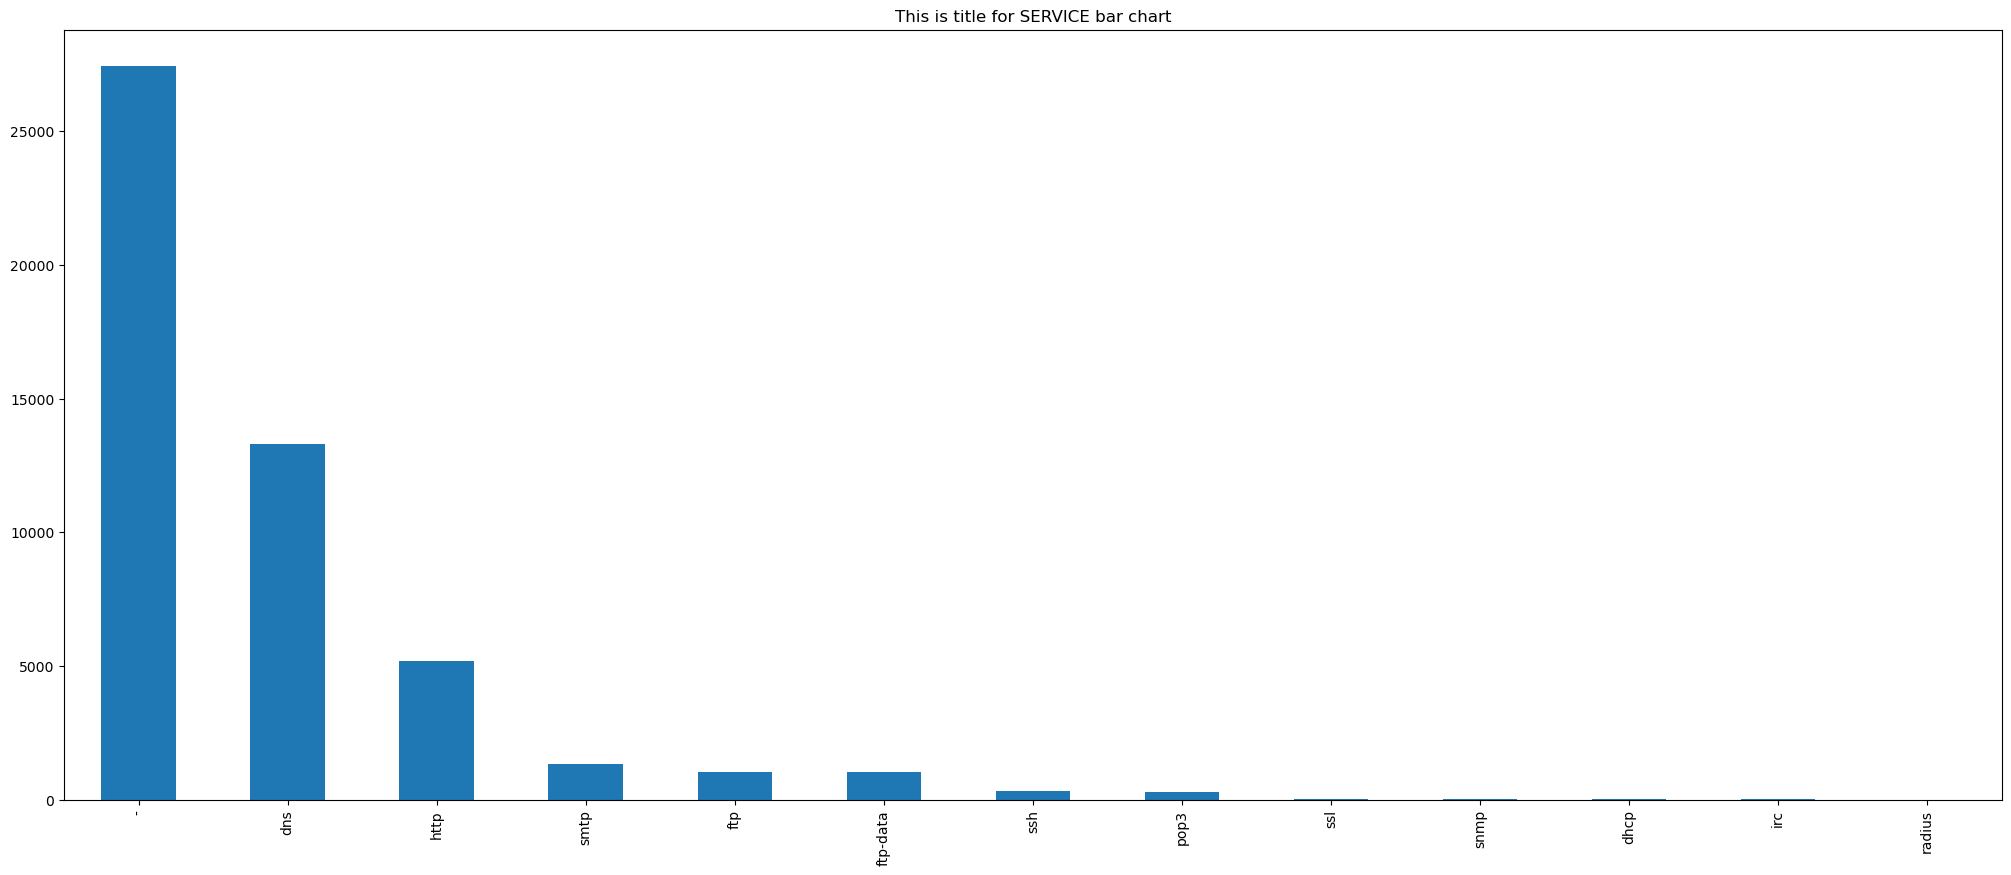

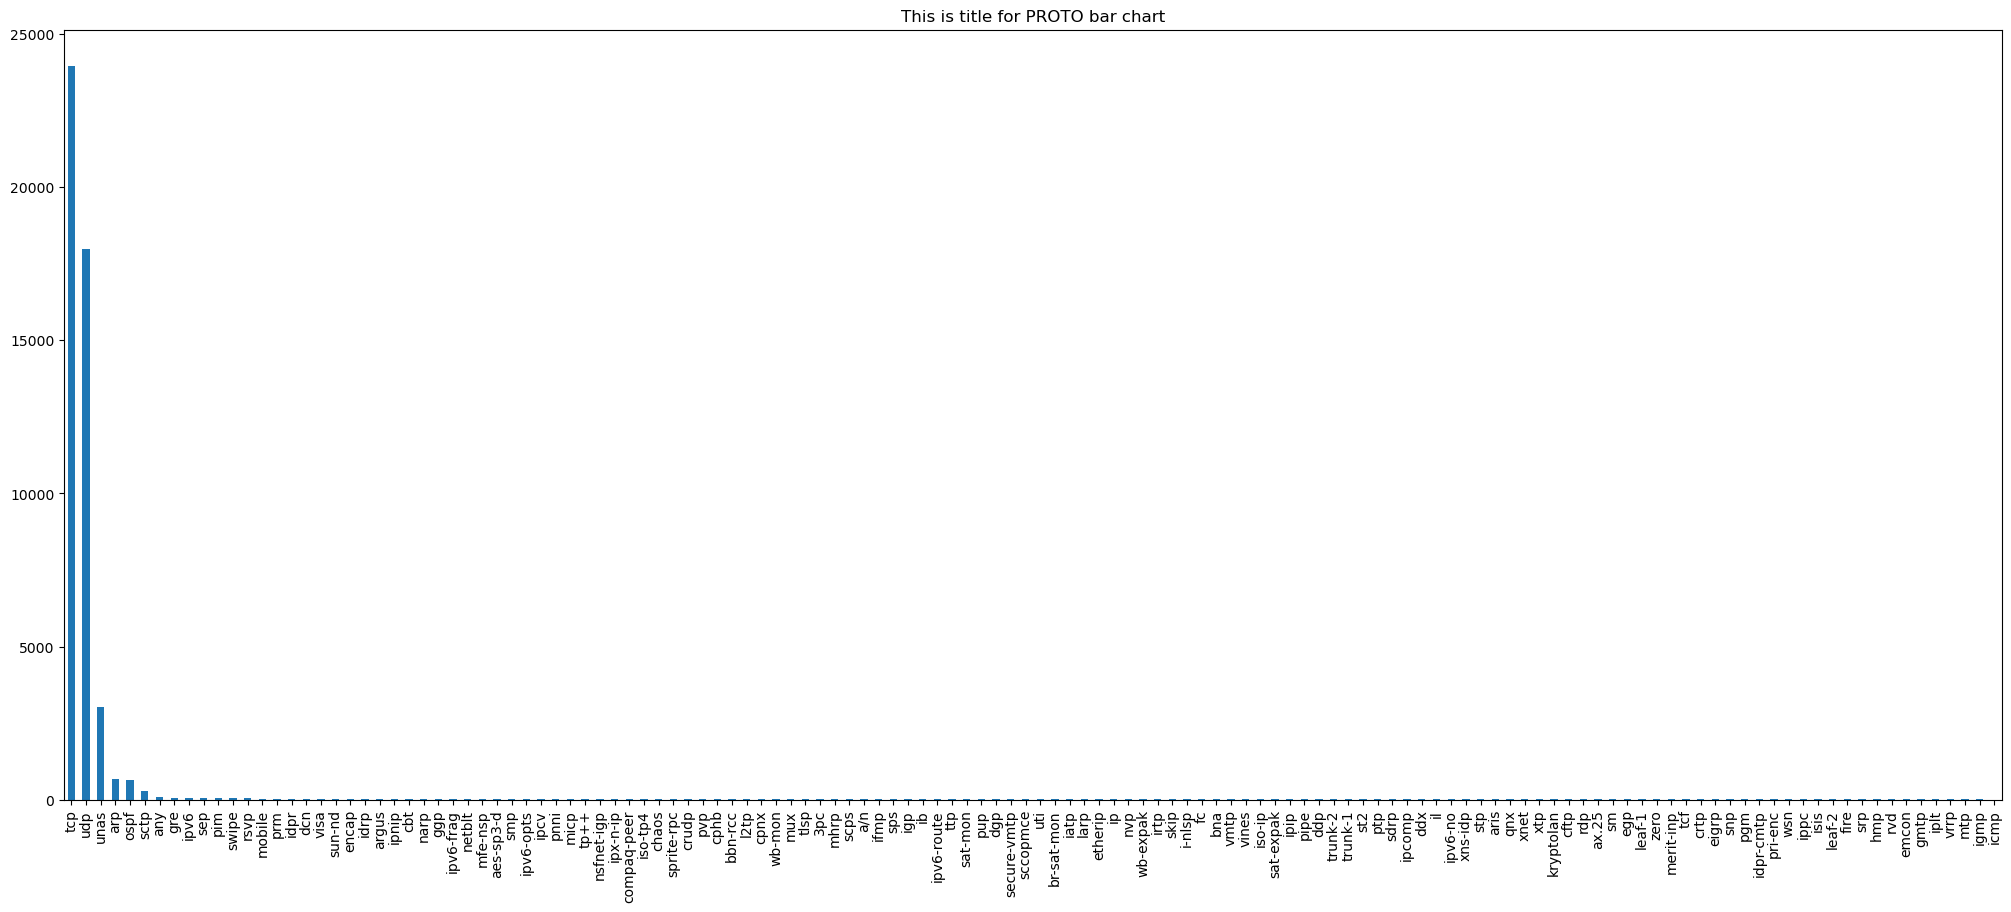

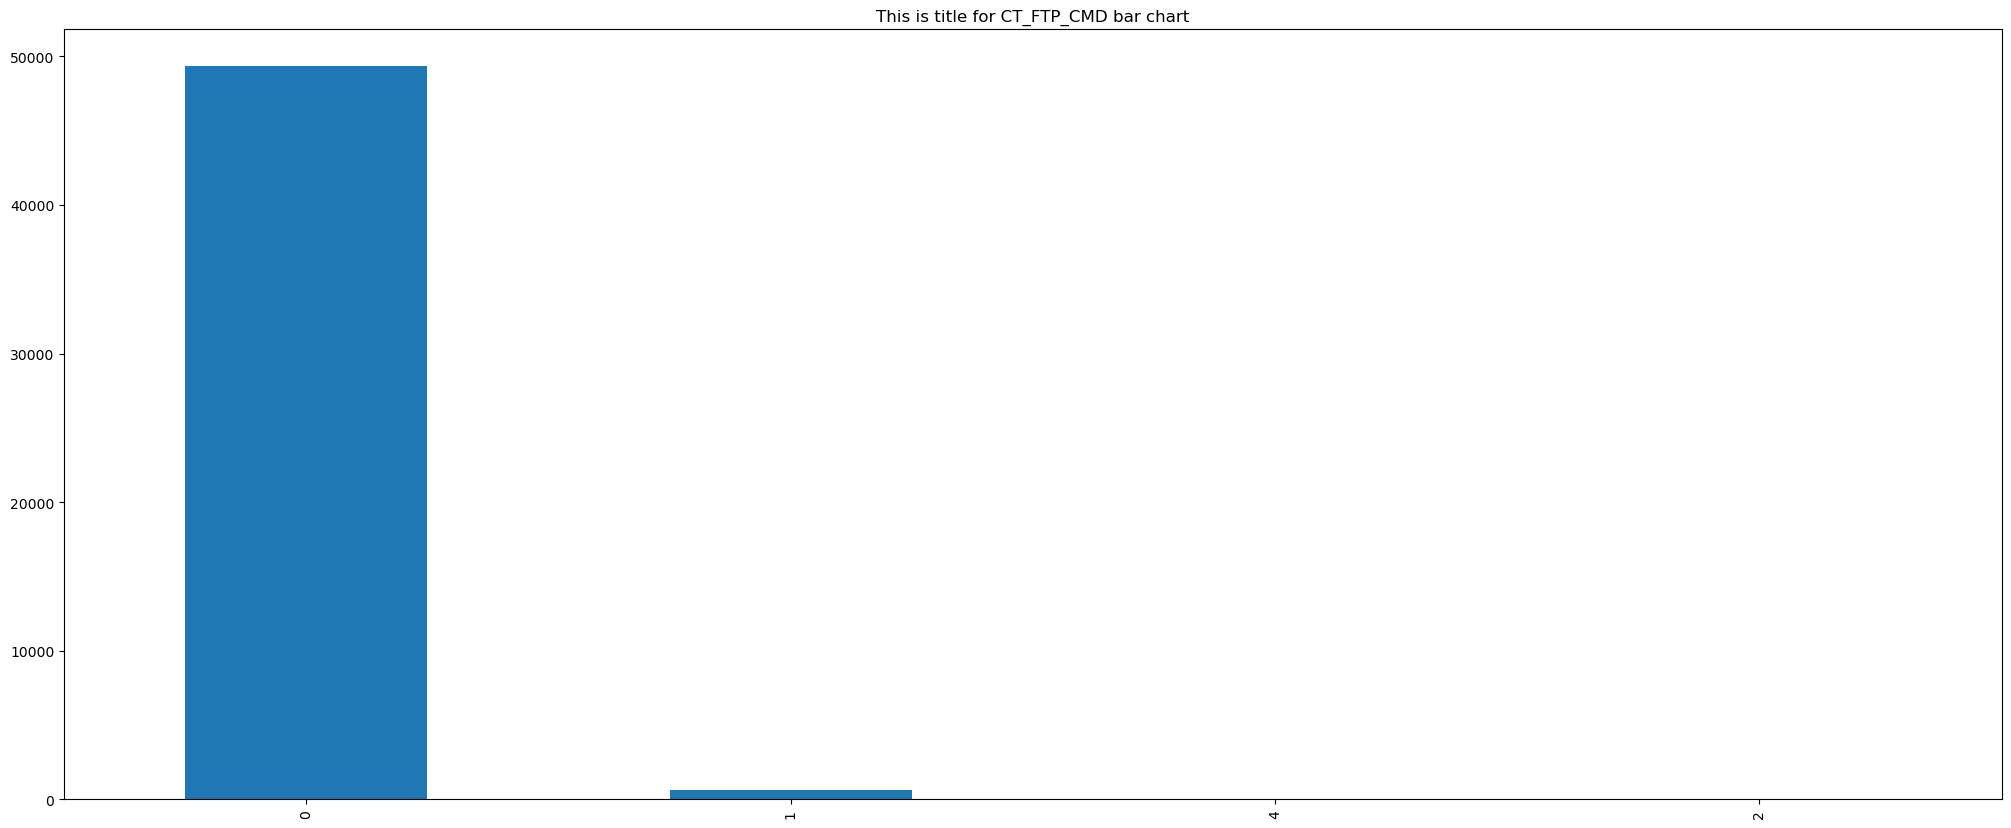

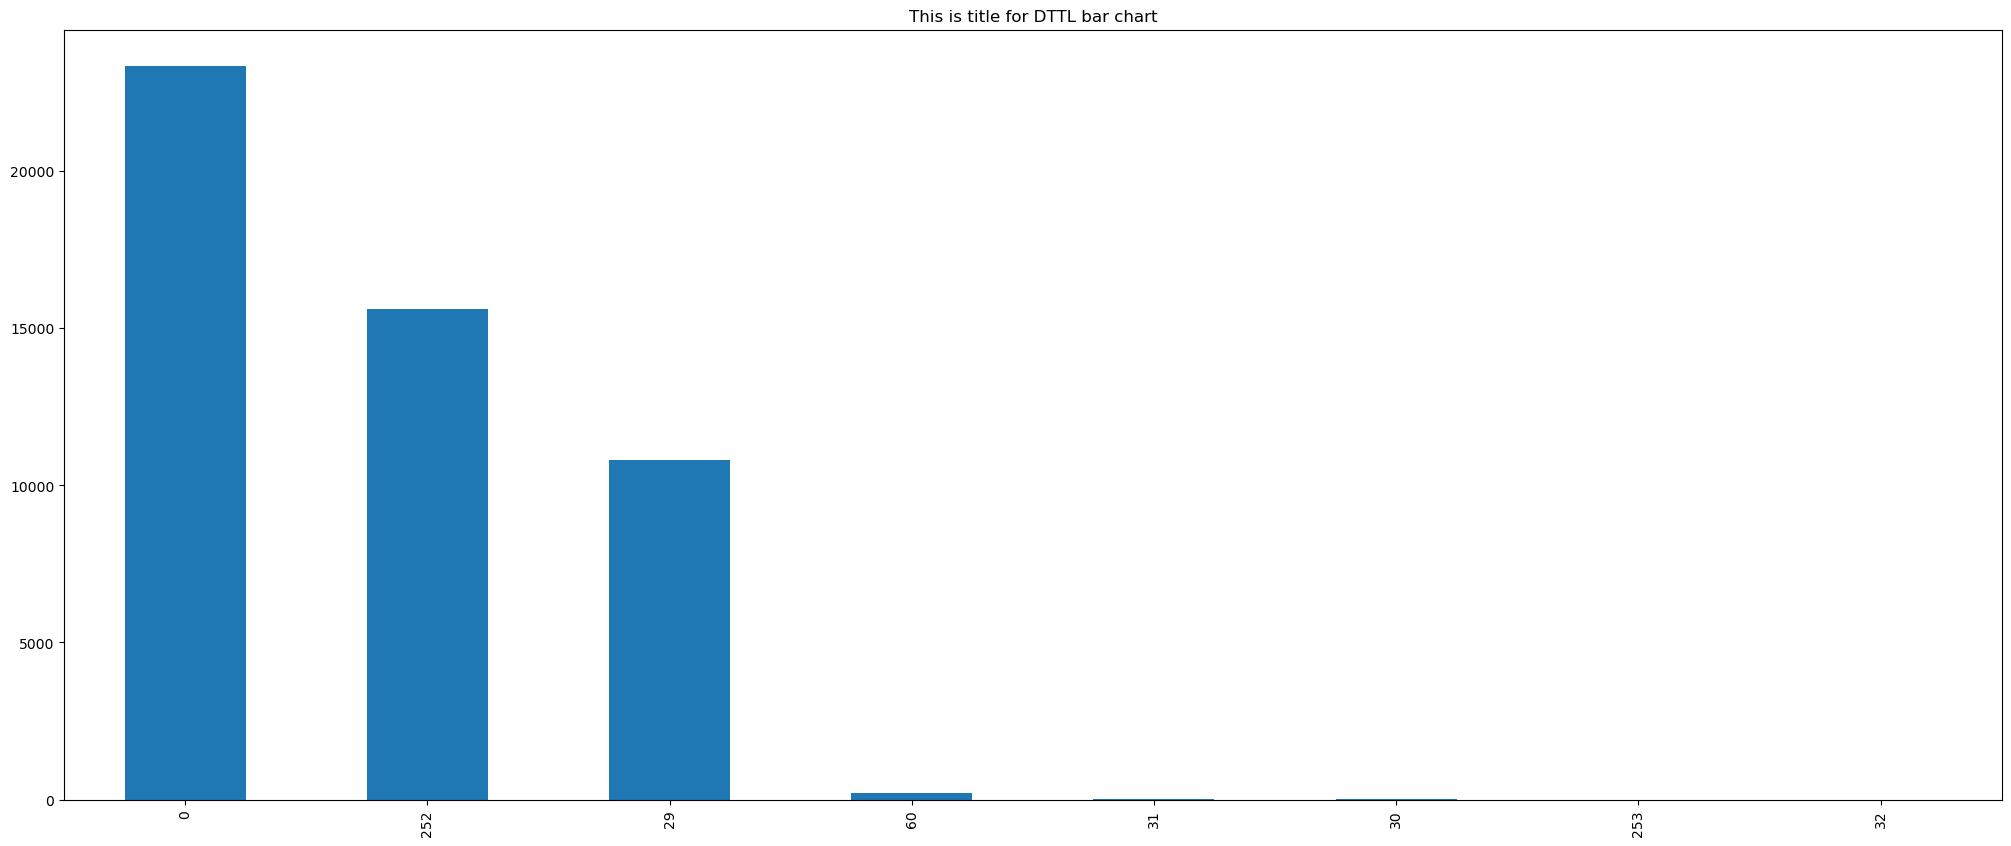

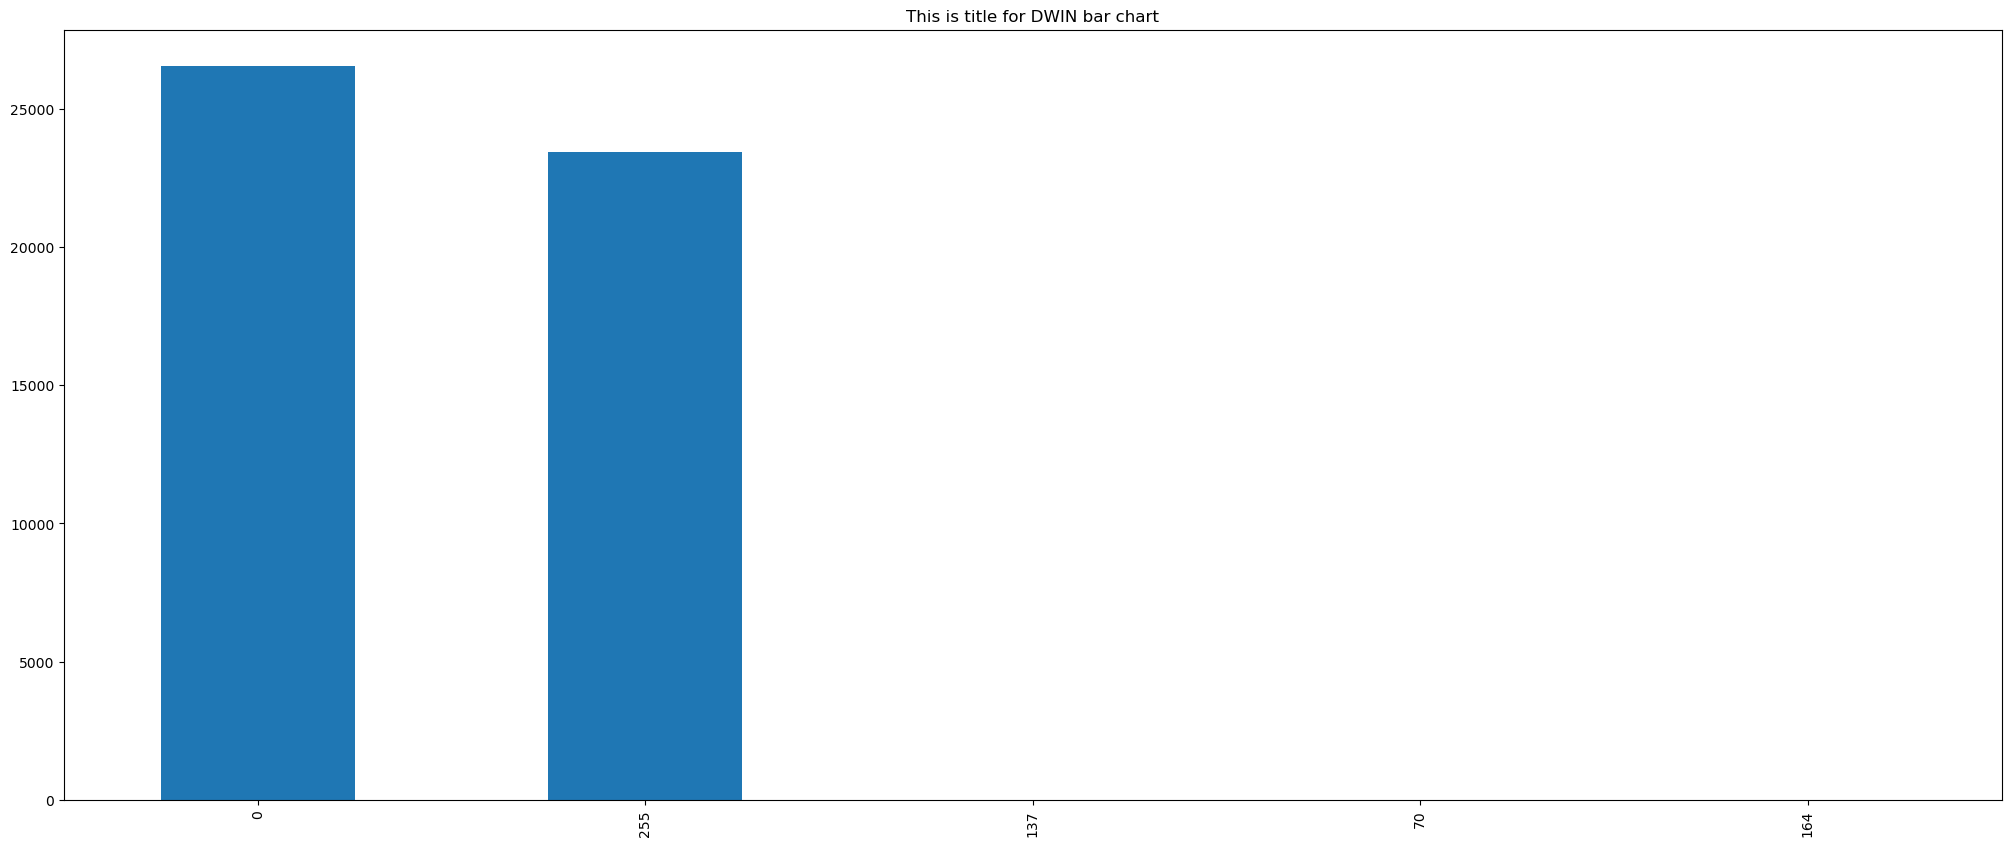

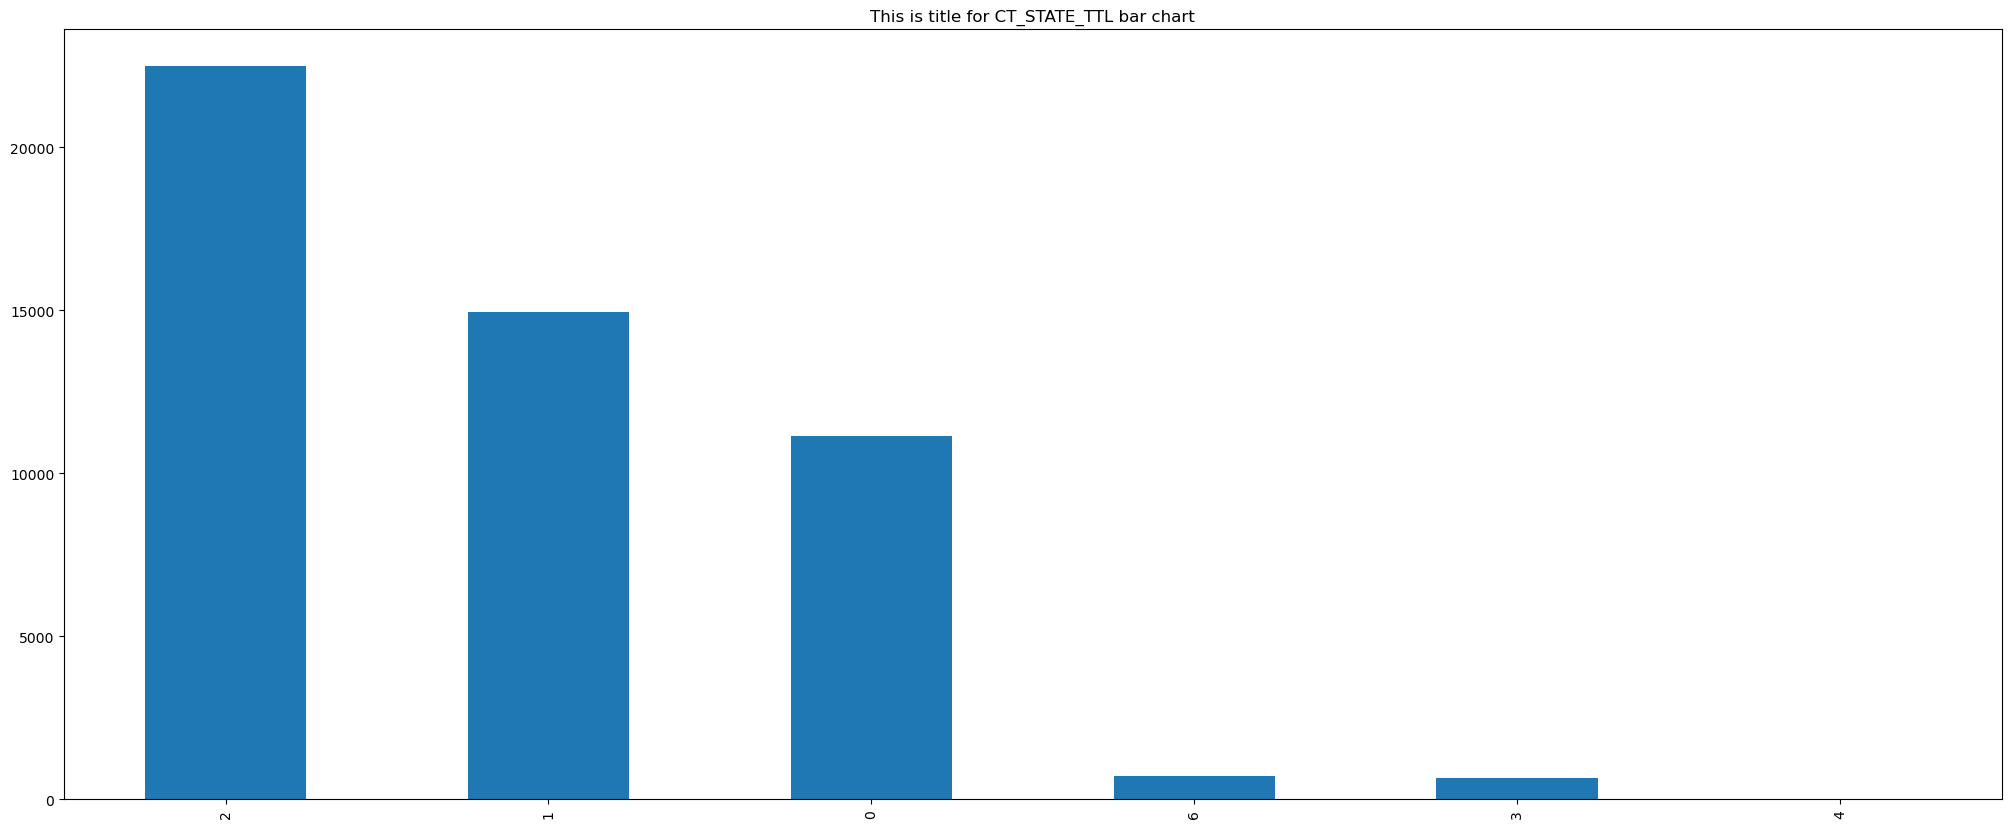

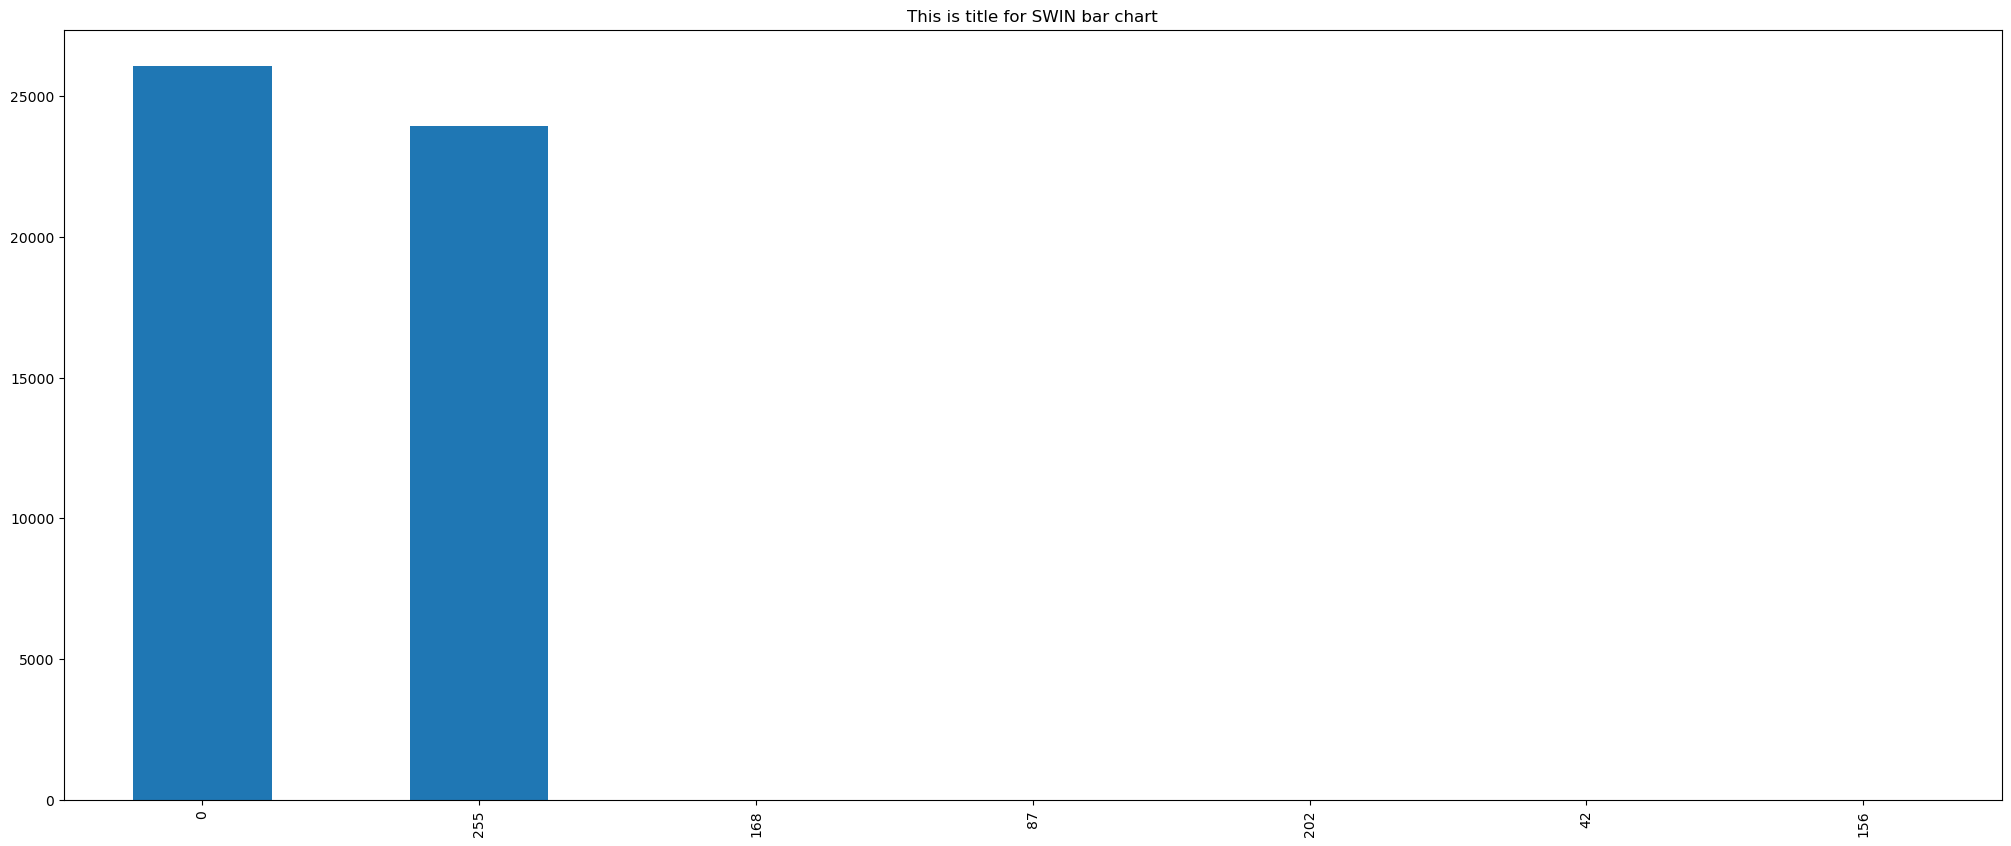

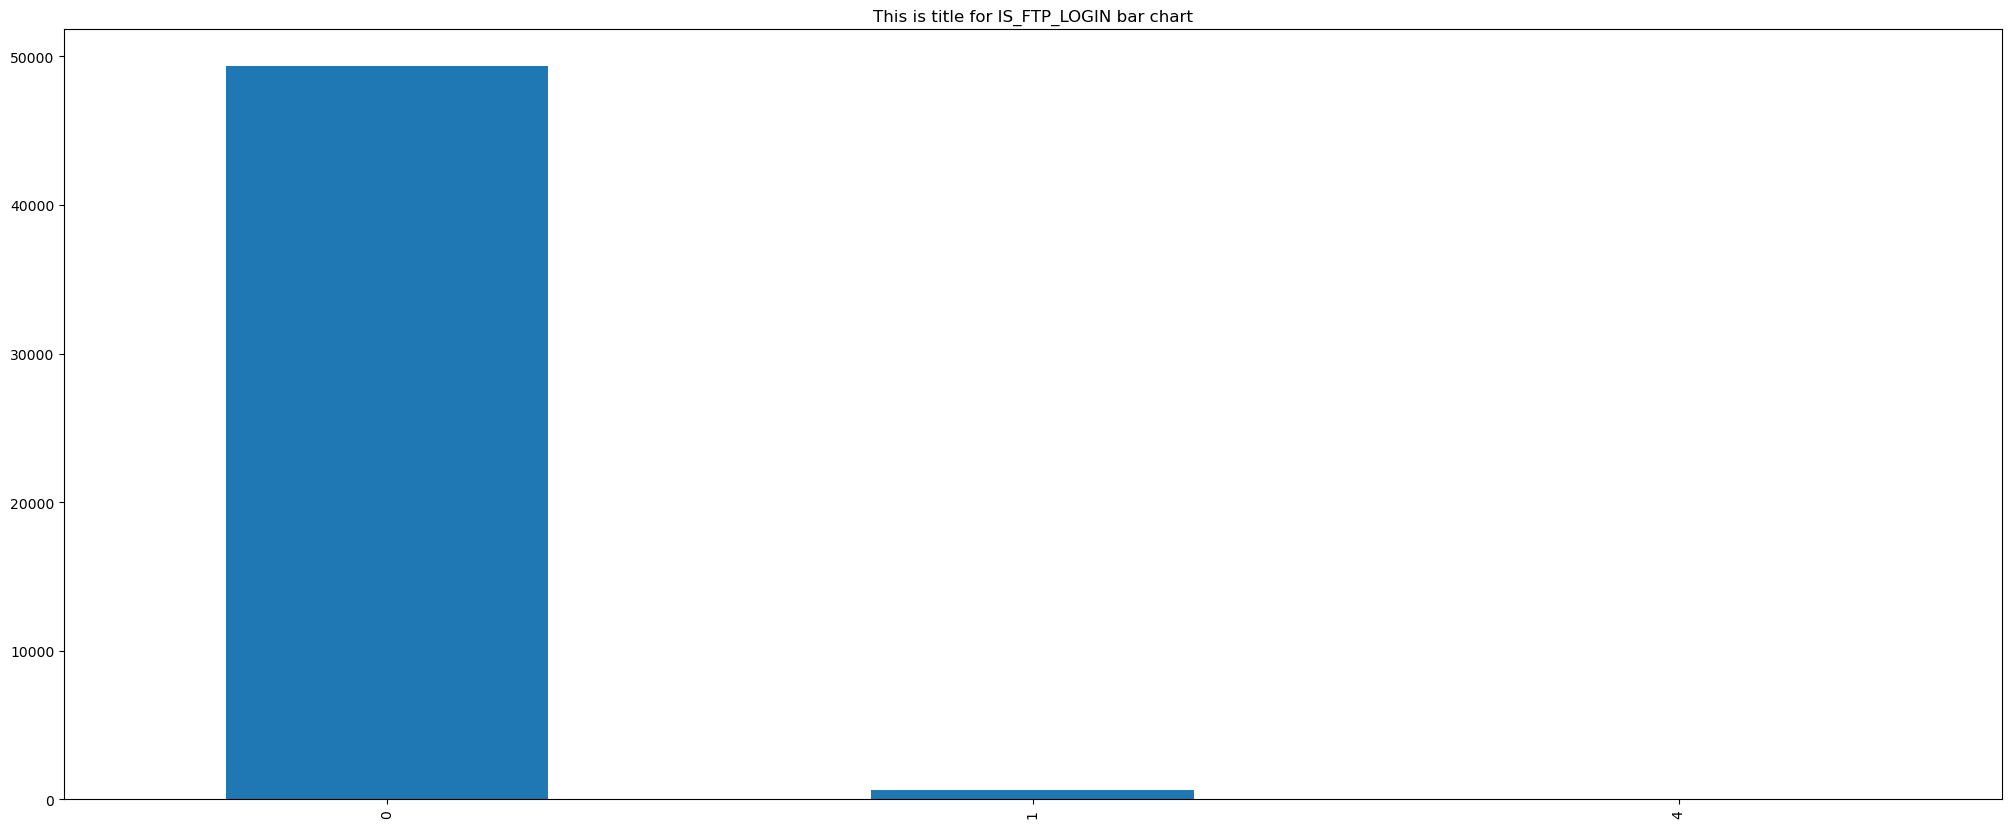

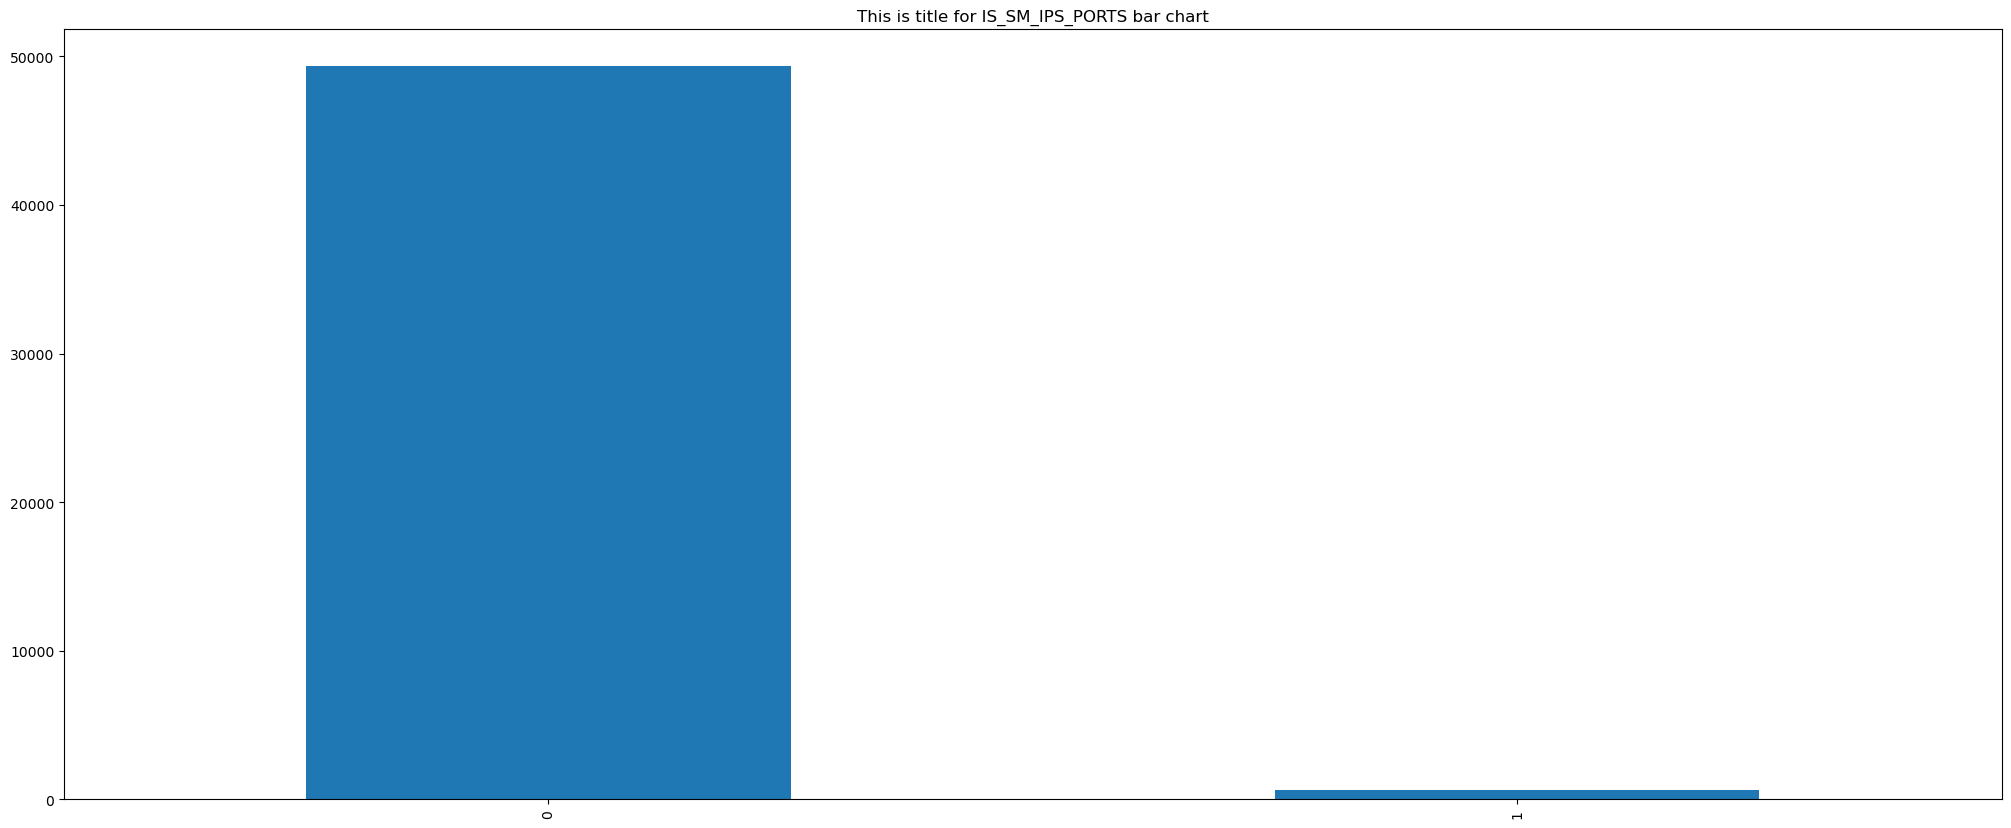

In [78]:
show_bar_plots_for_all_categorical_plots(eda_unsw_nb15_df, eda_unsw_nb15_categorical_features)

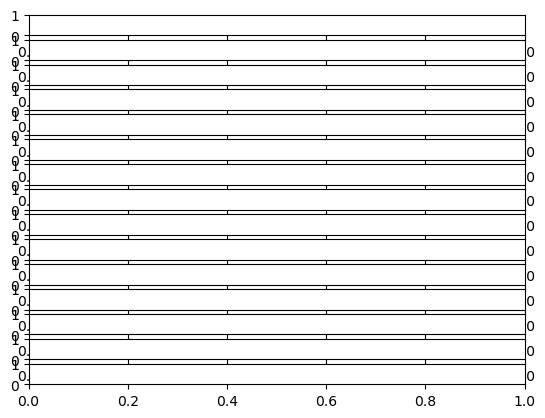

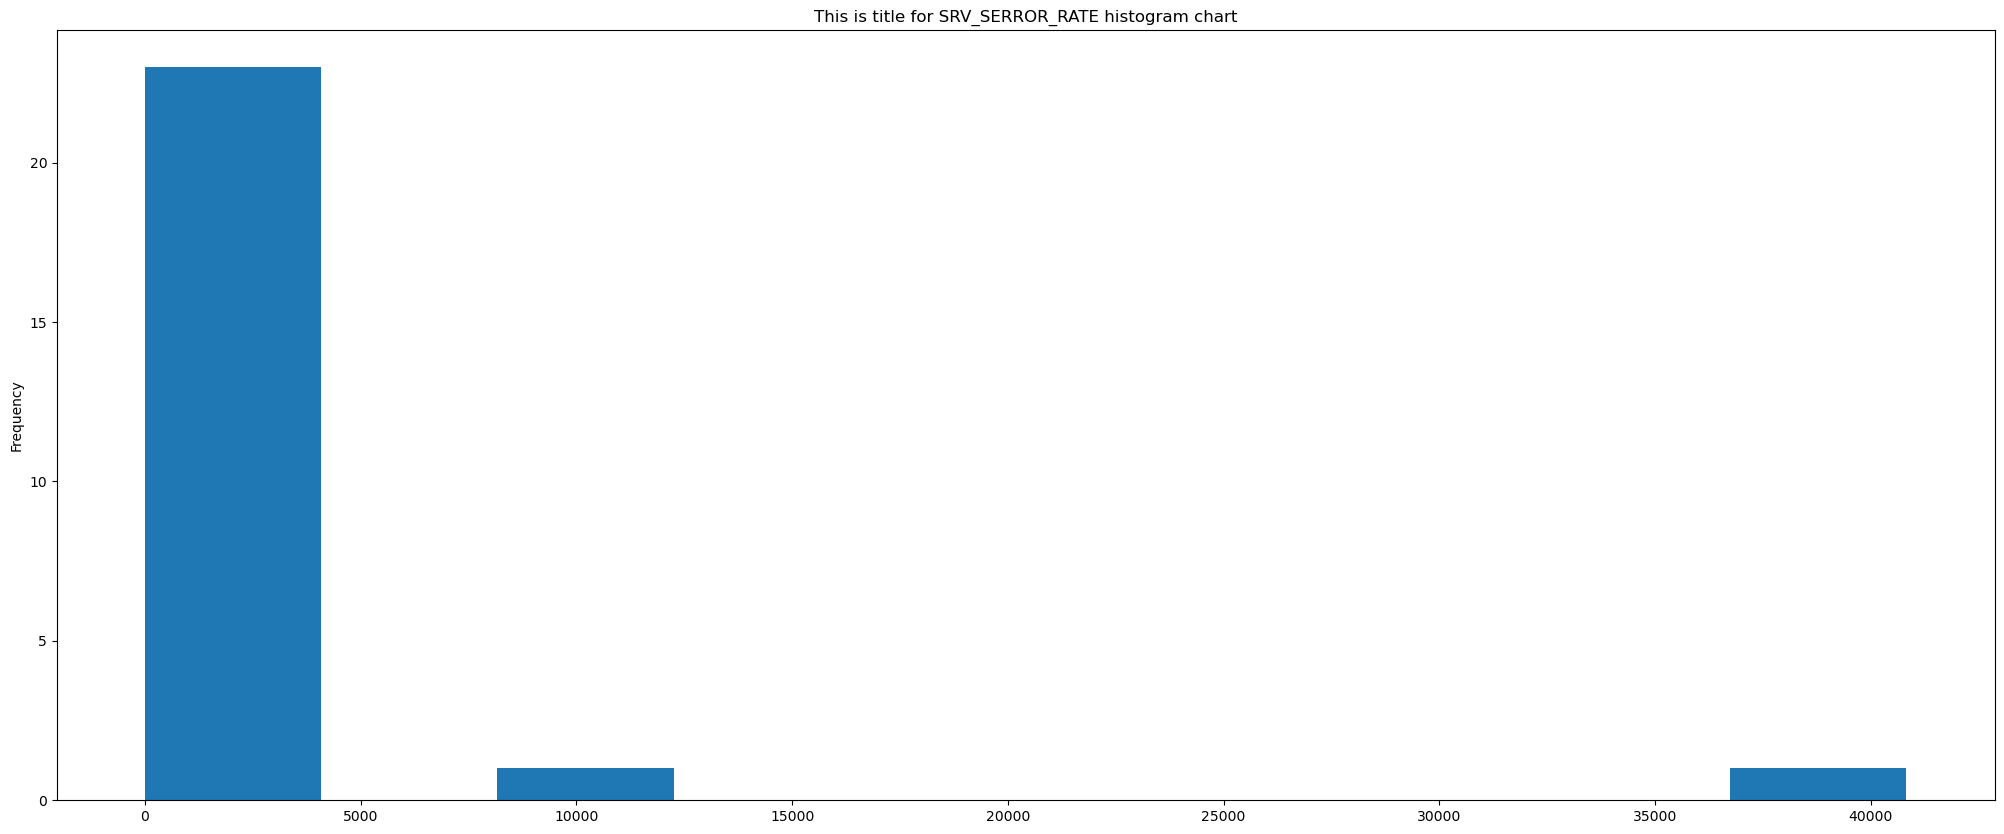

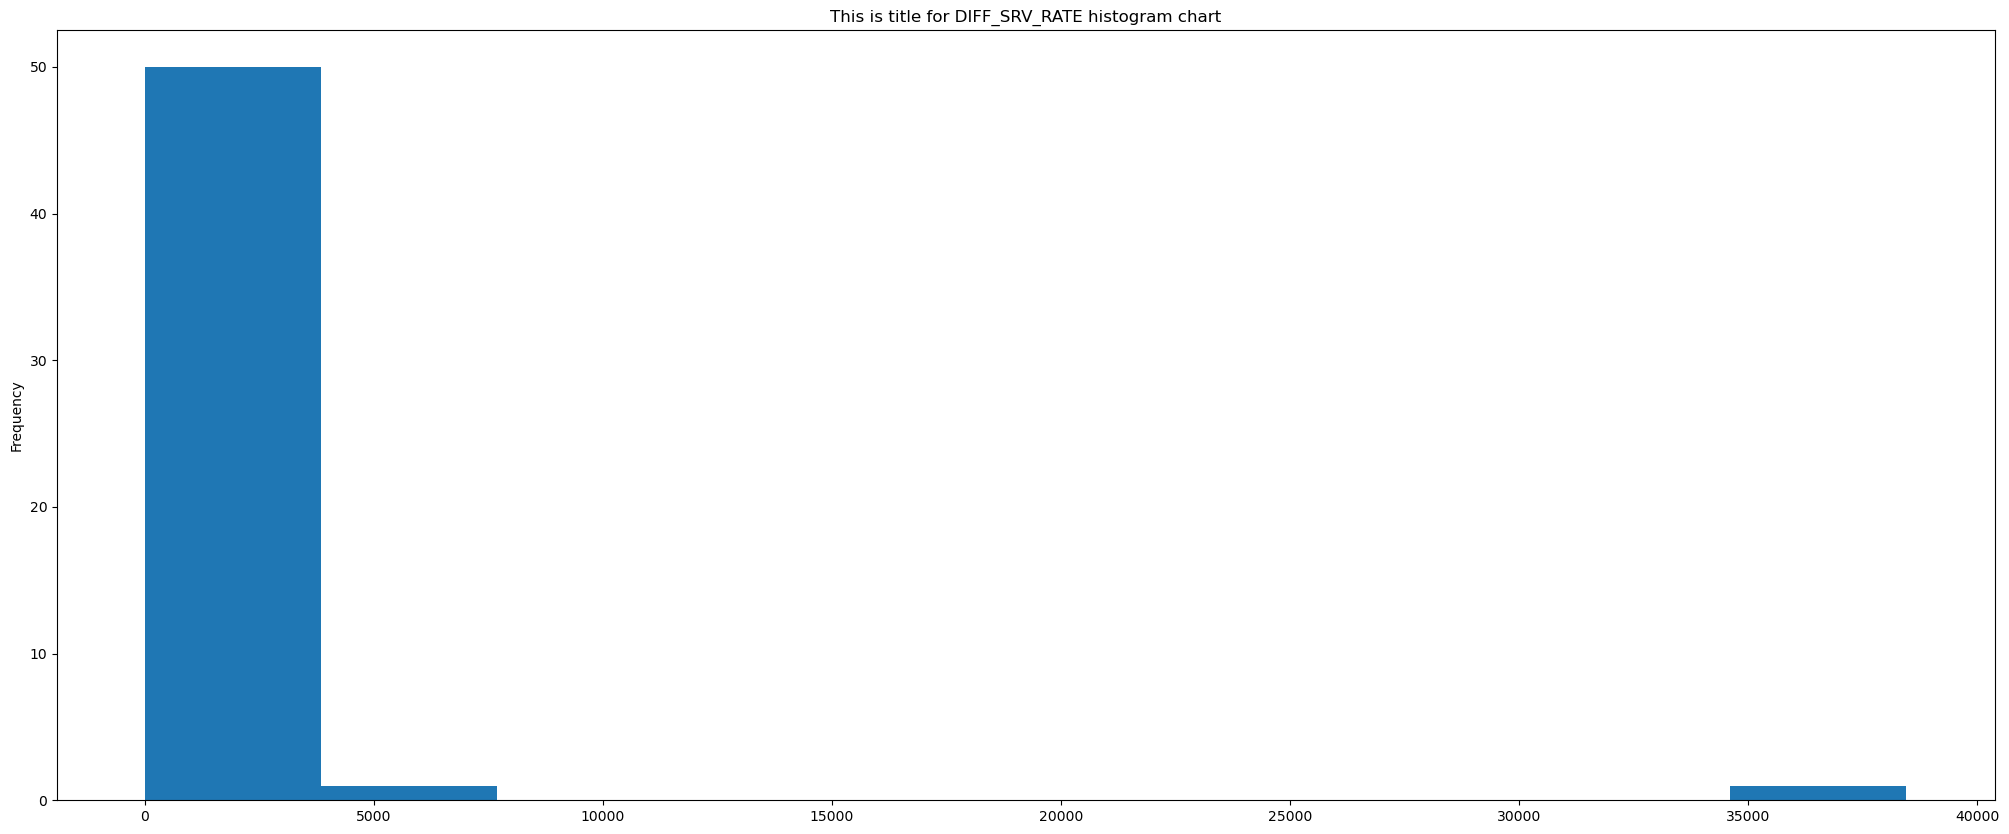

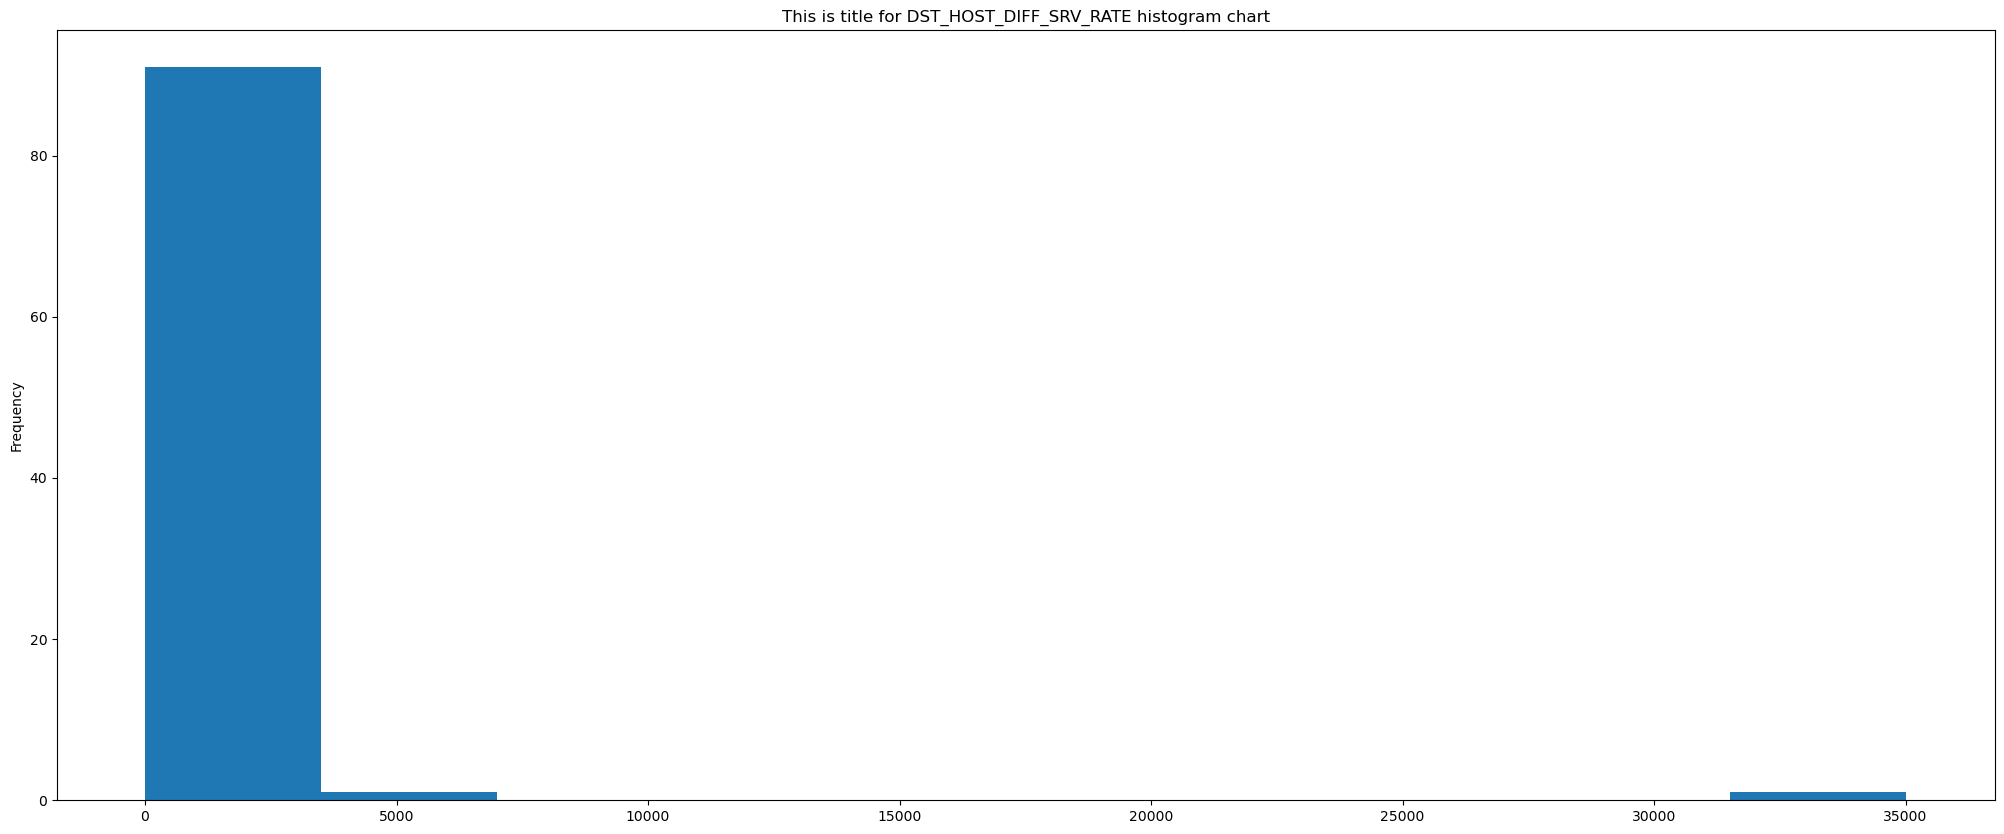

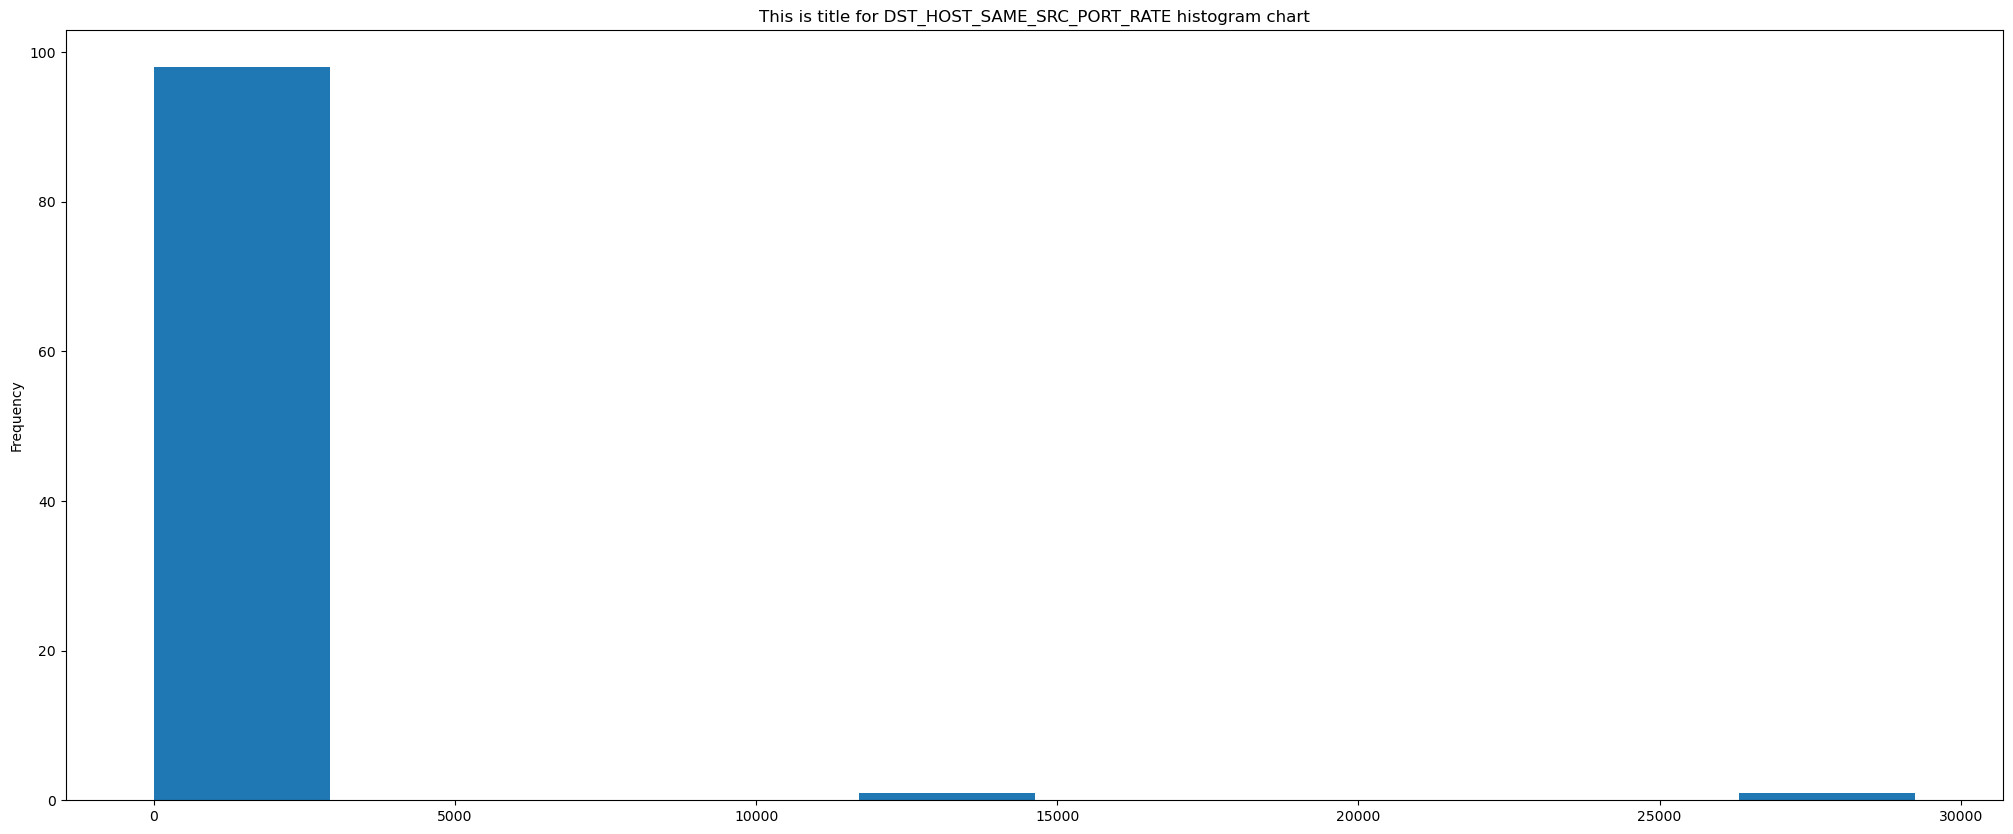

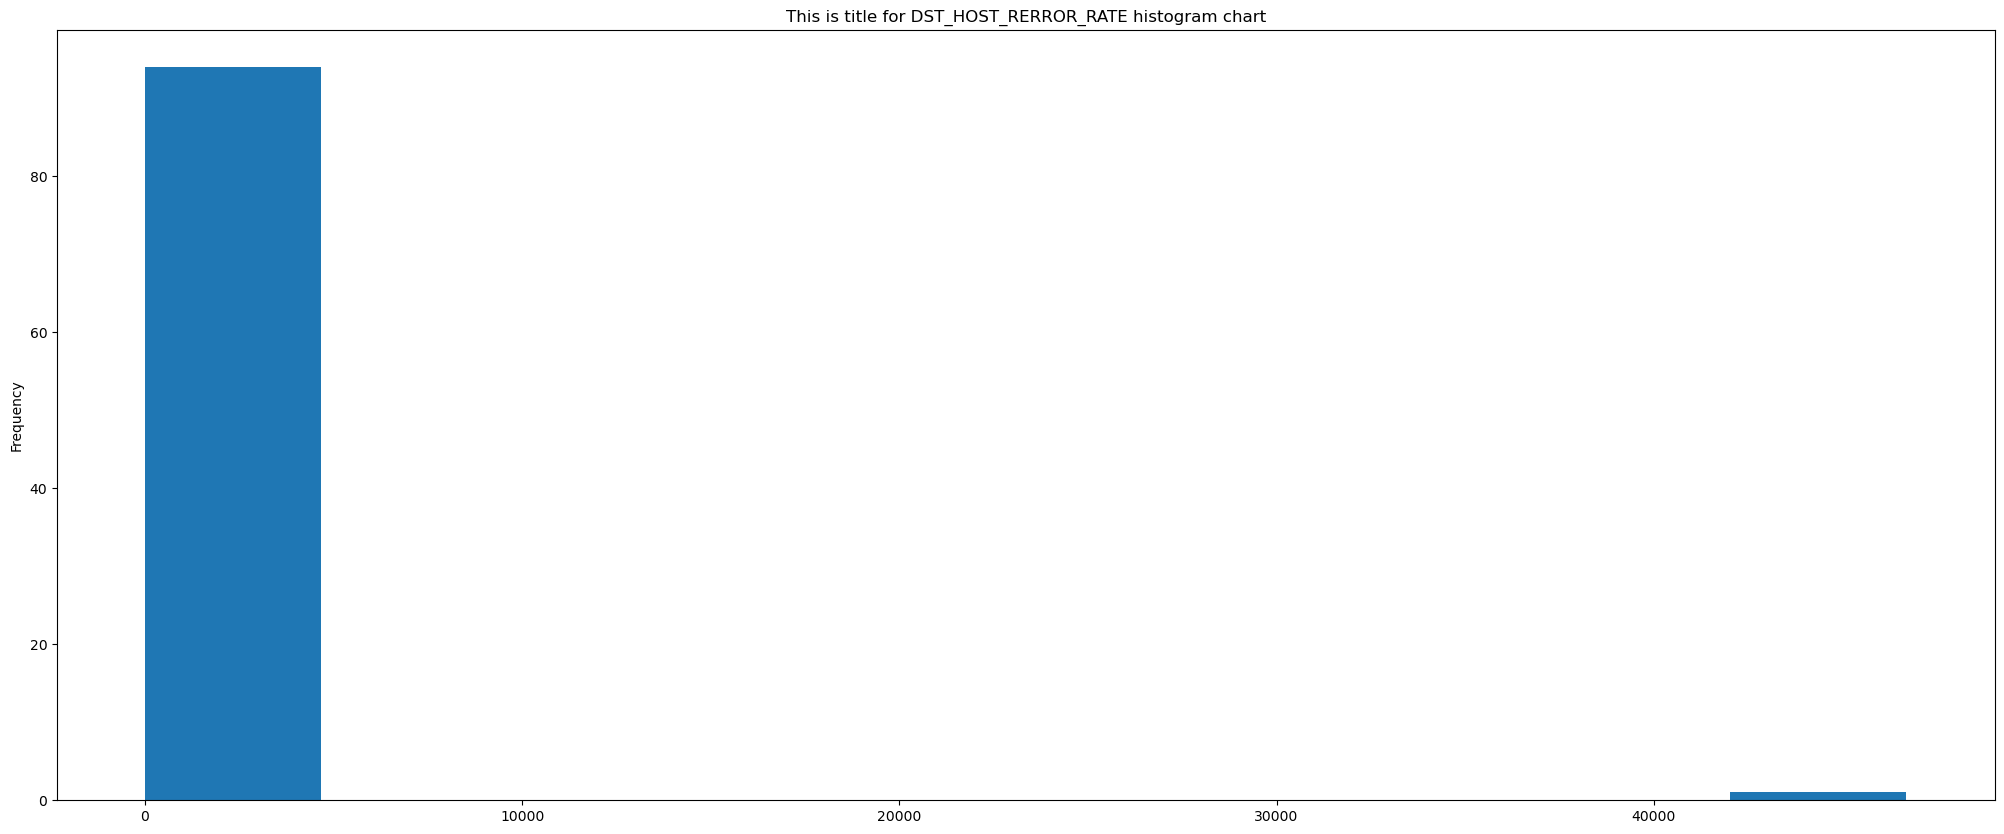

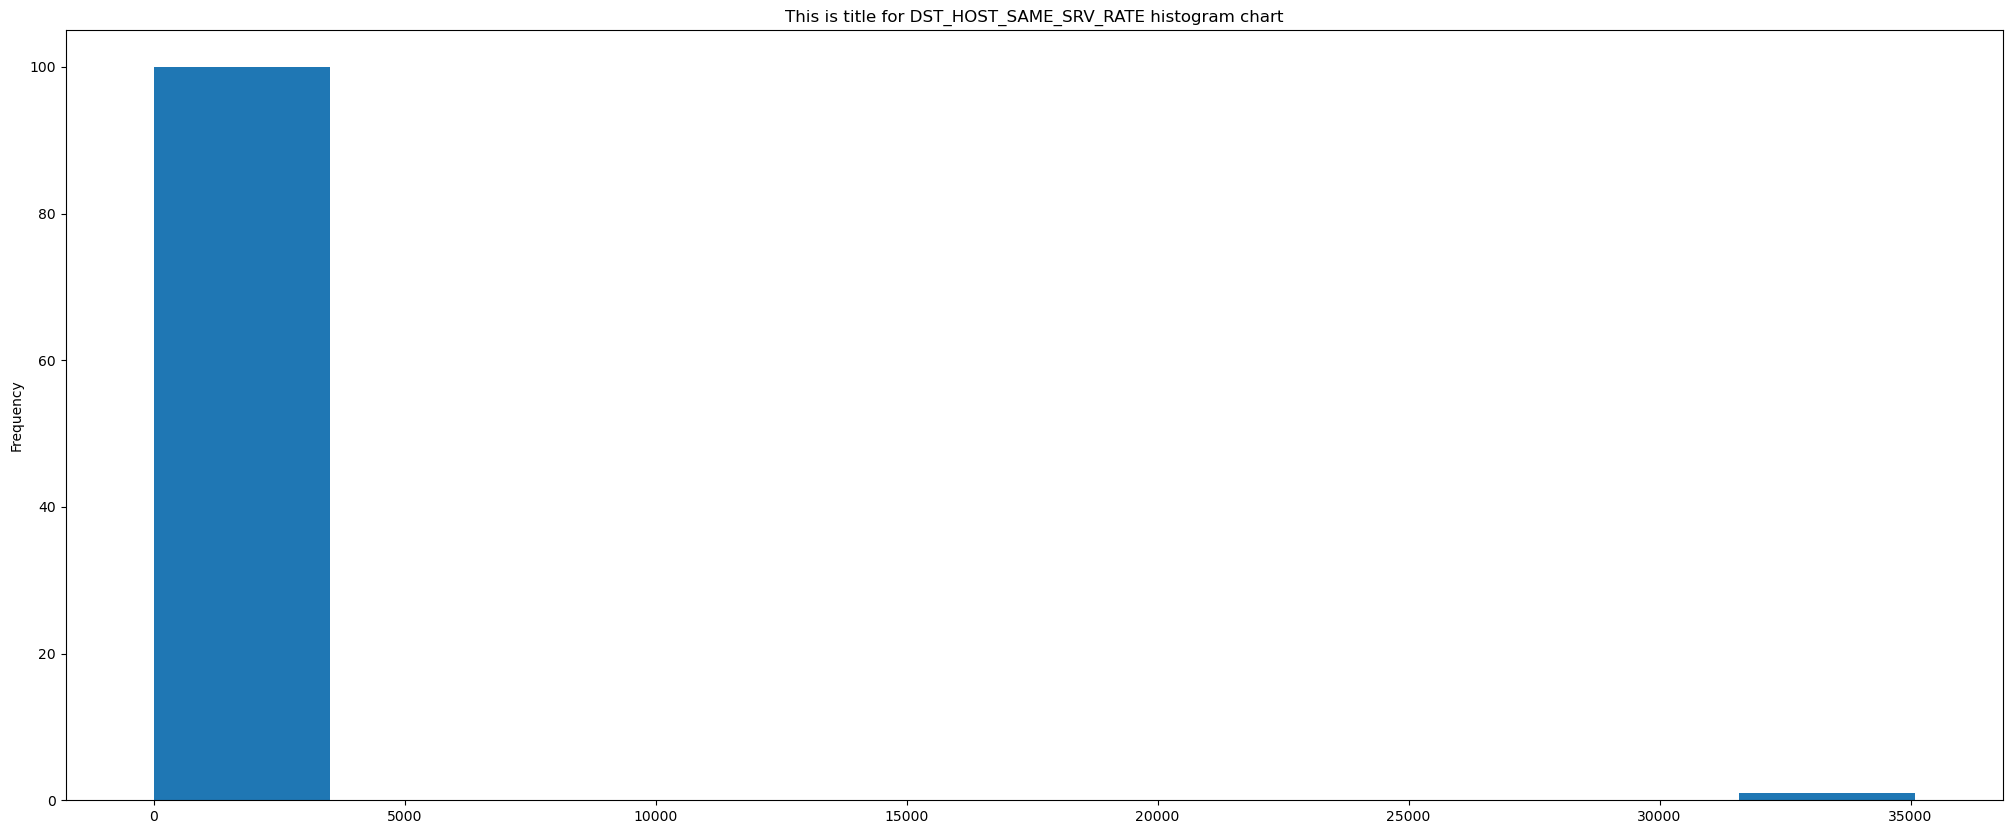

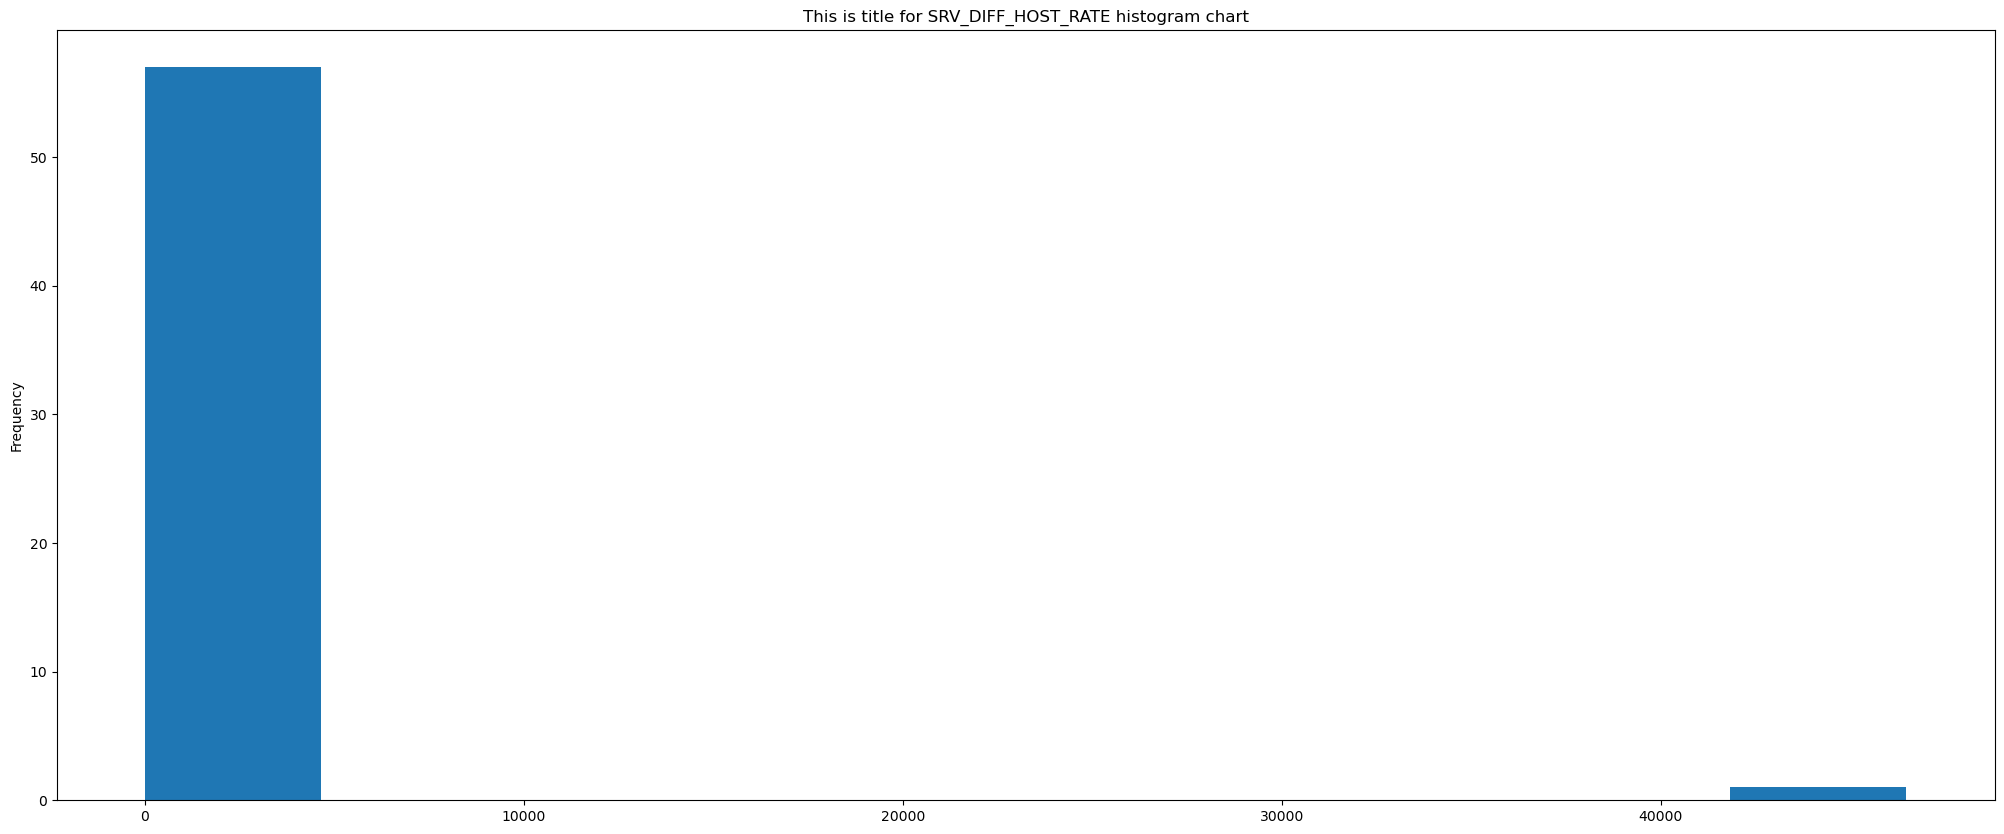

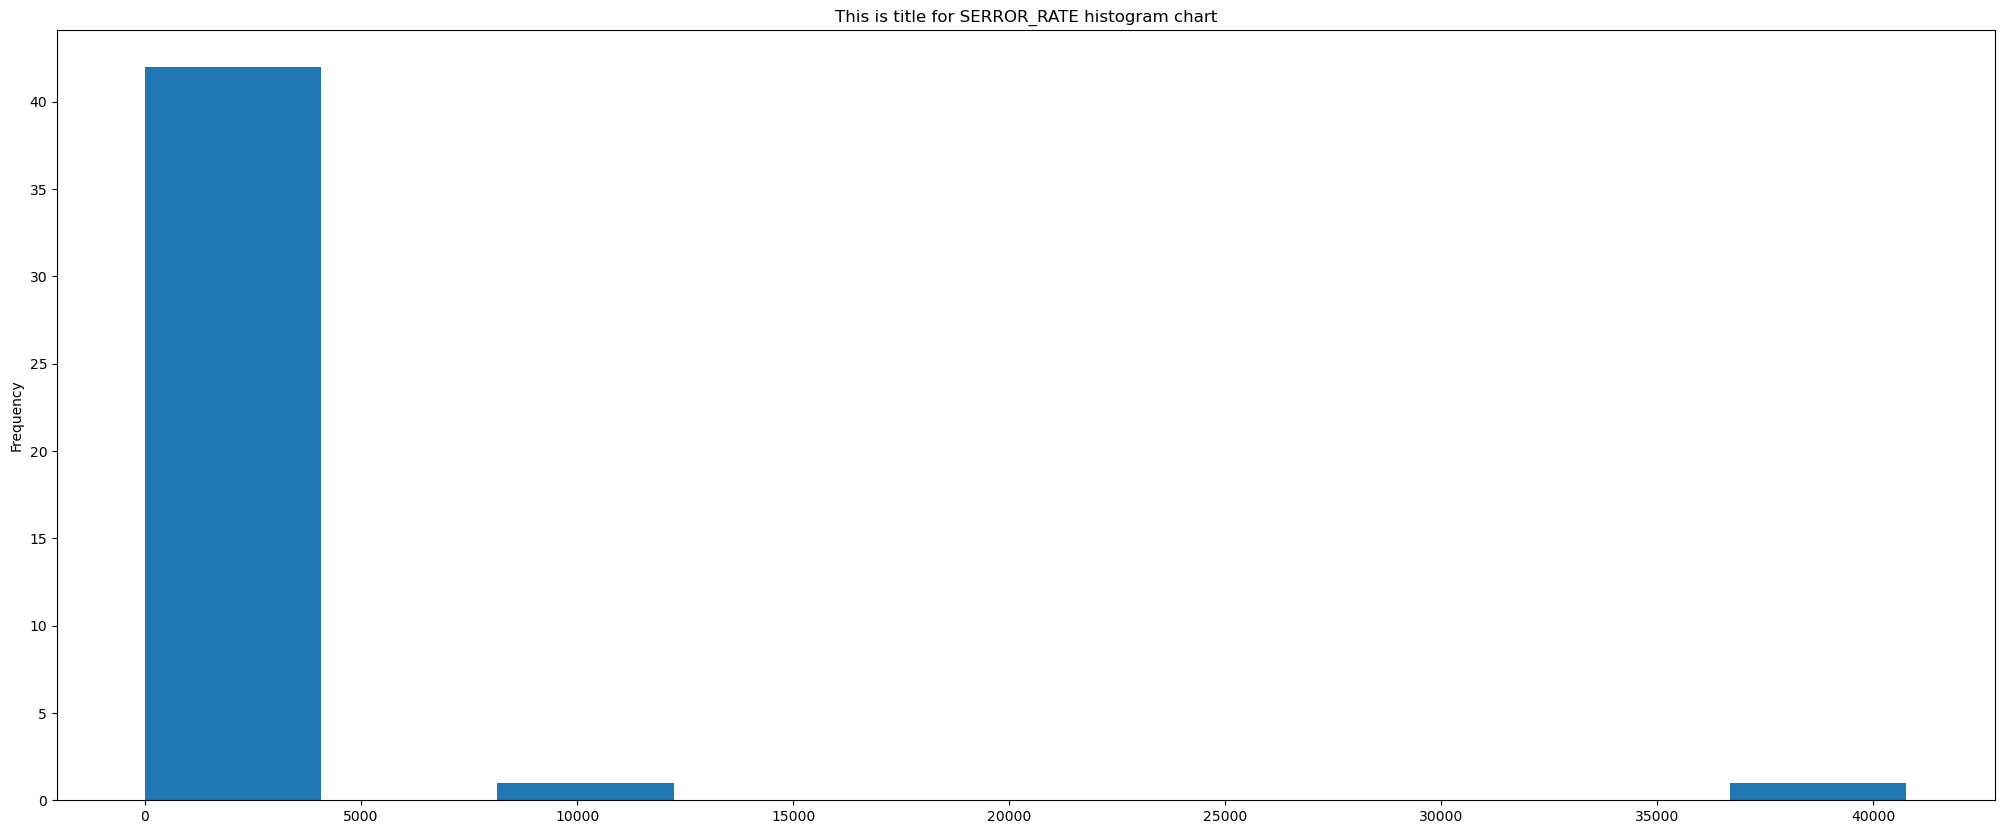

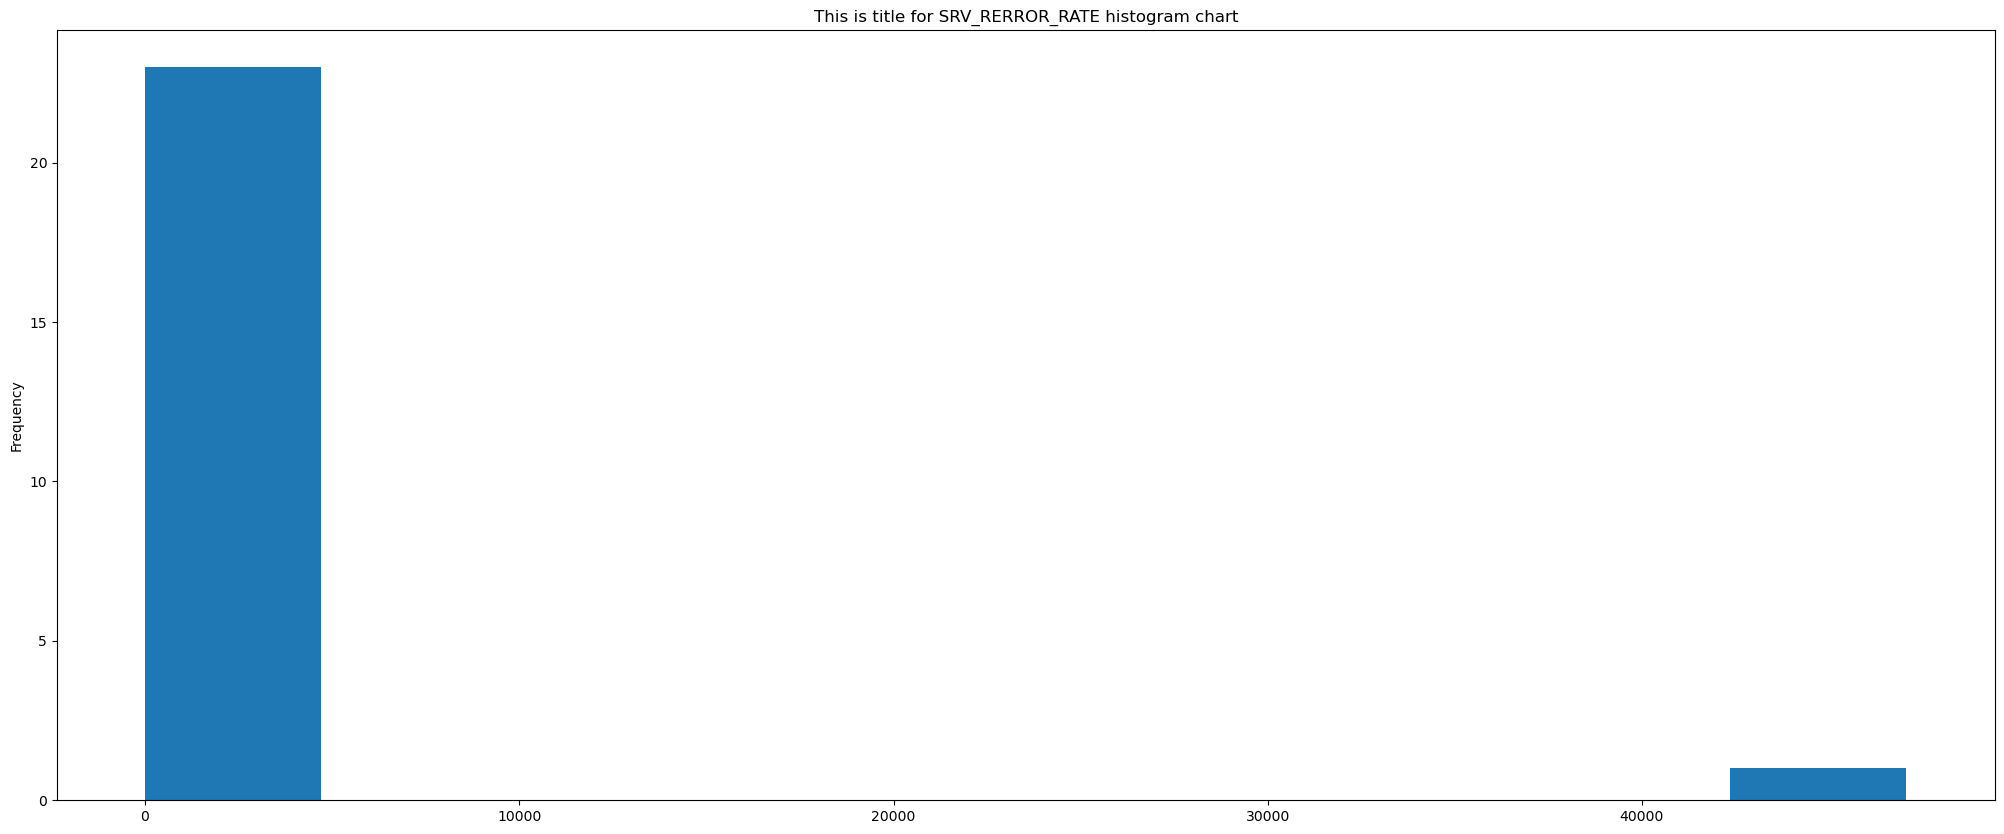

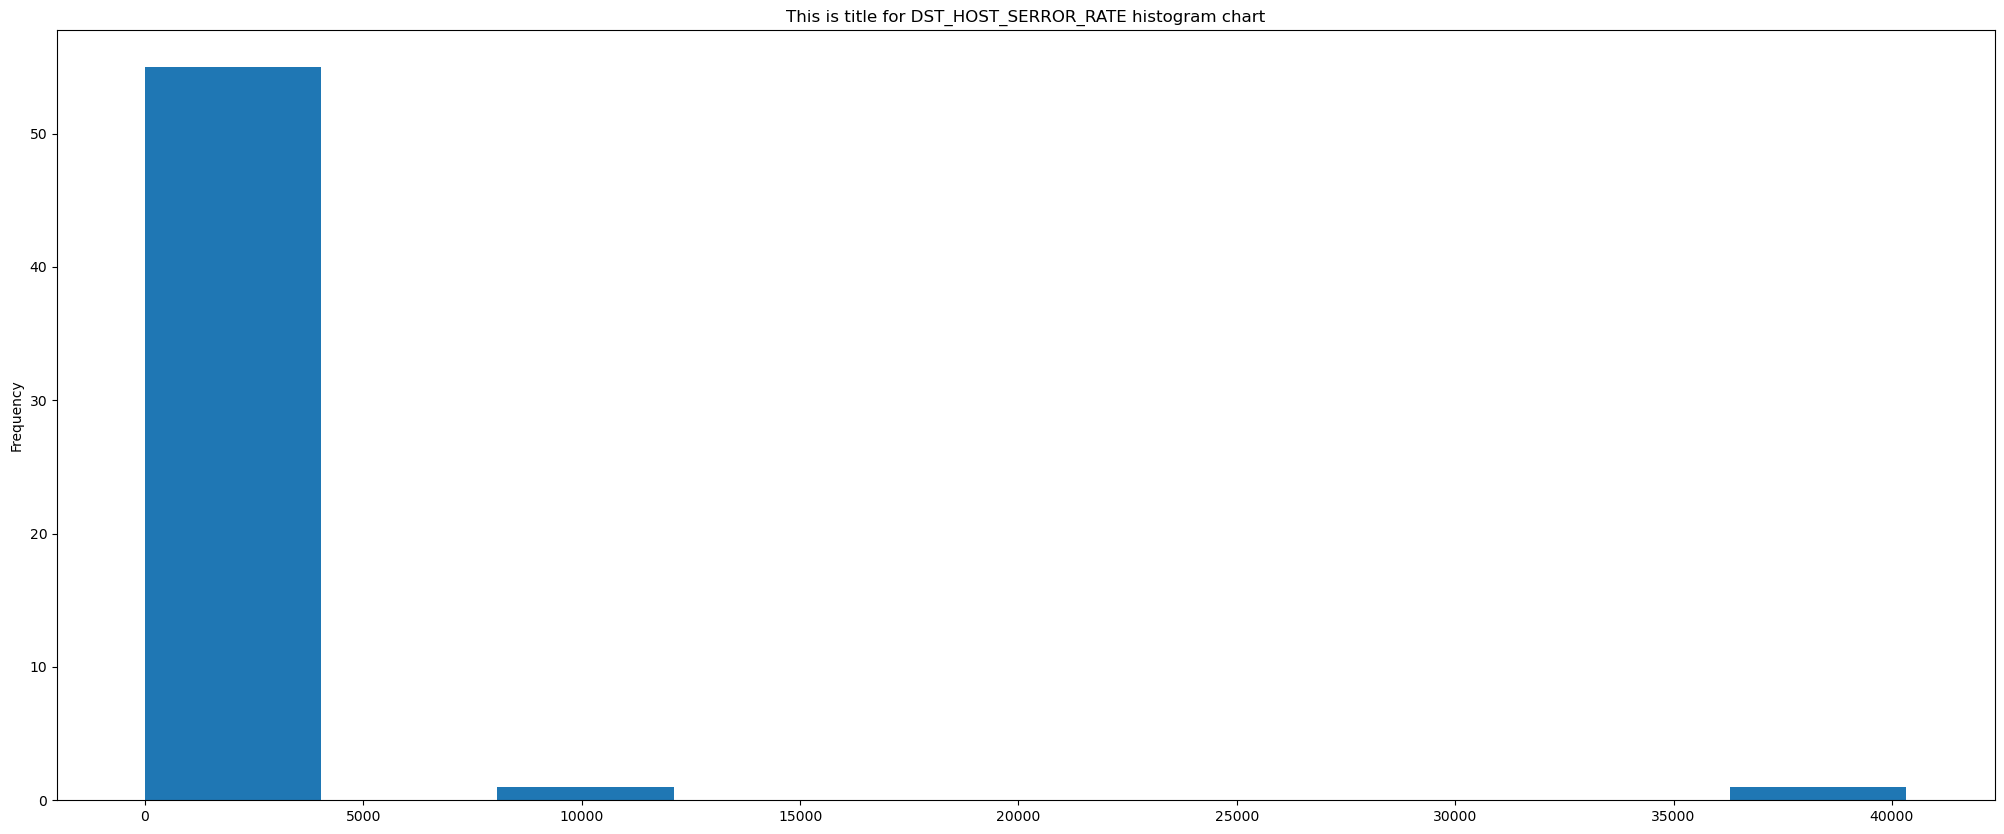

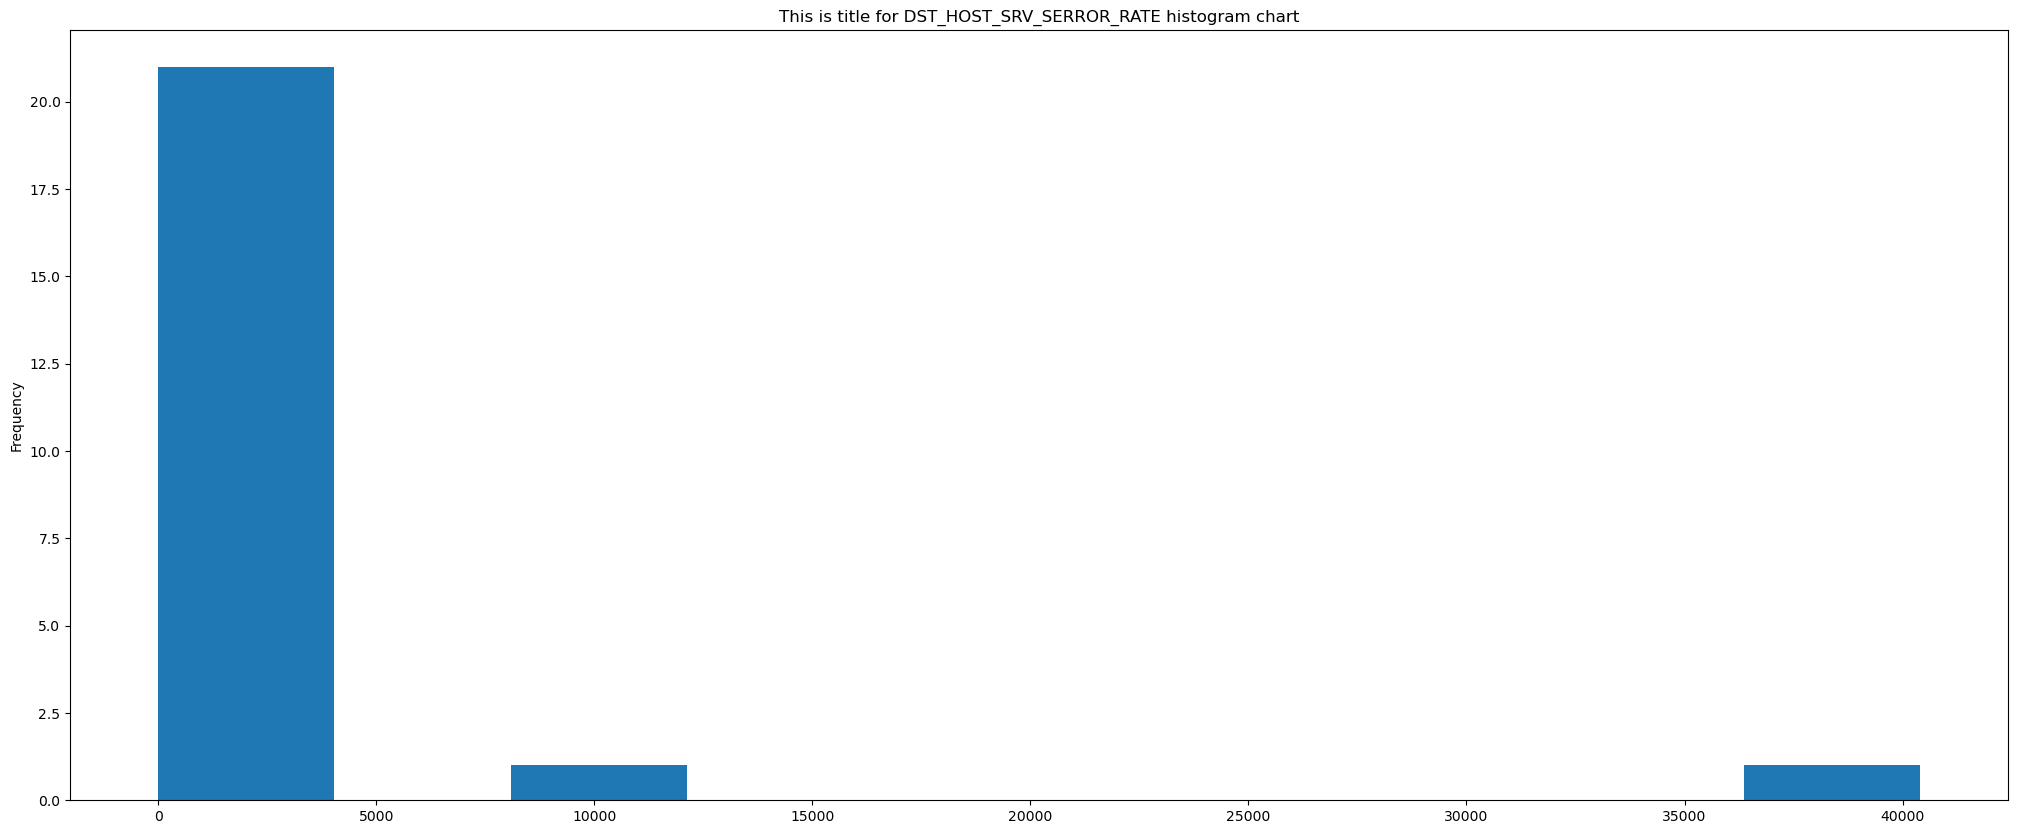

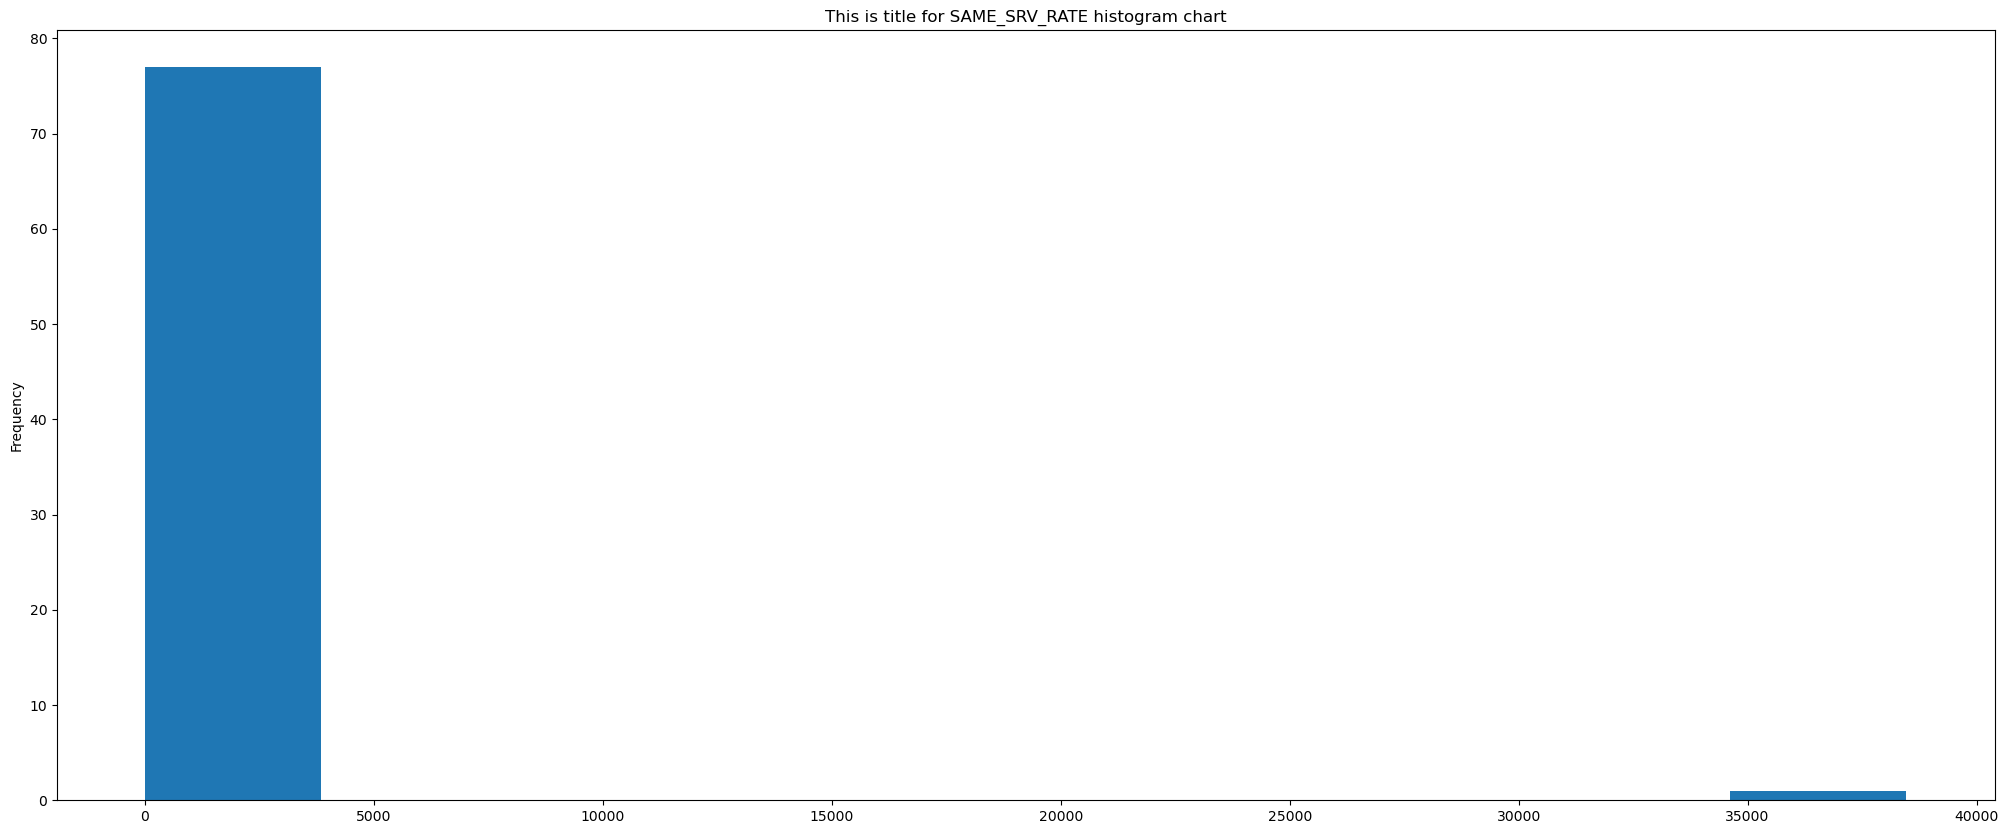

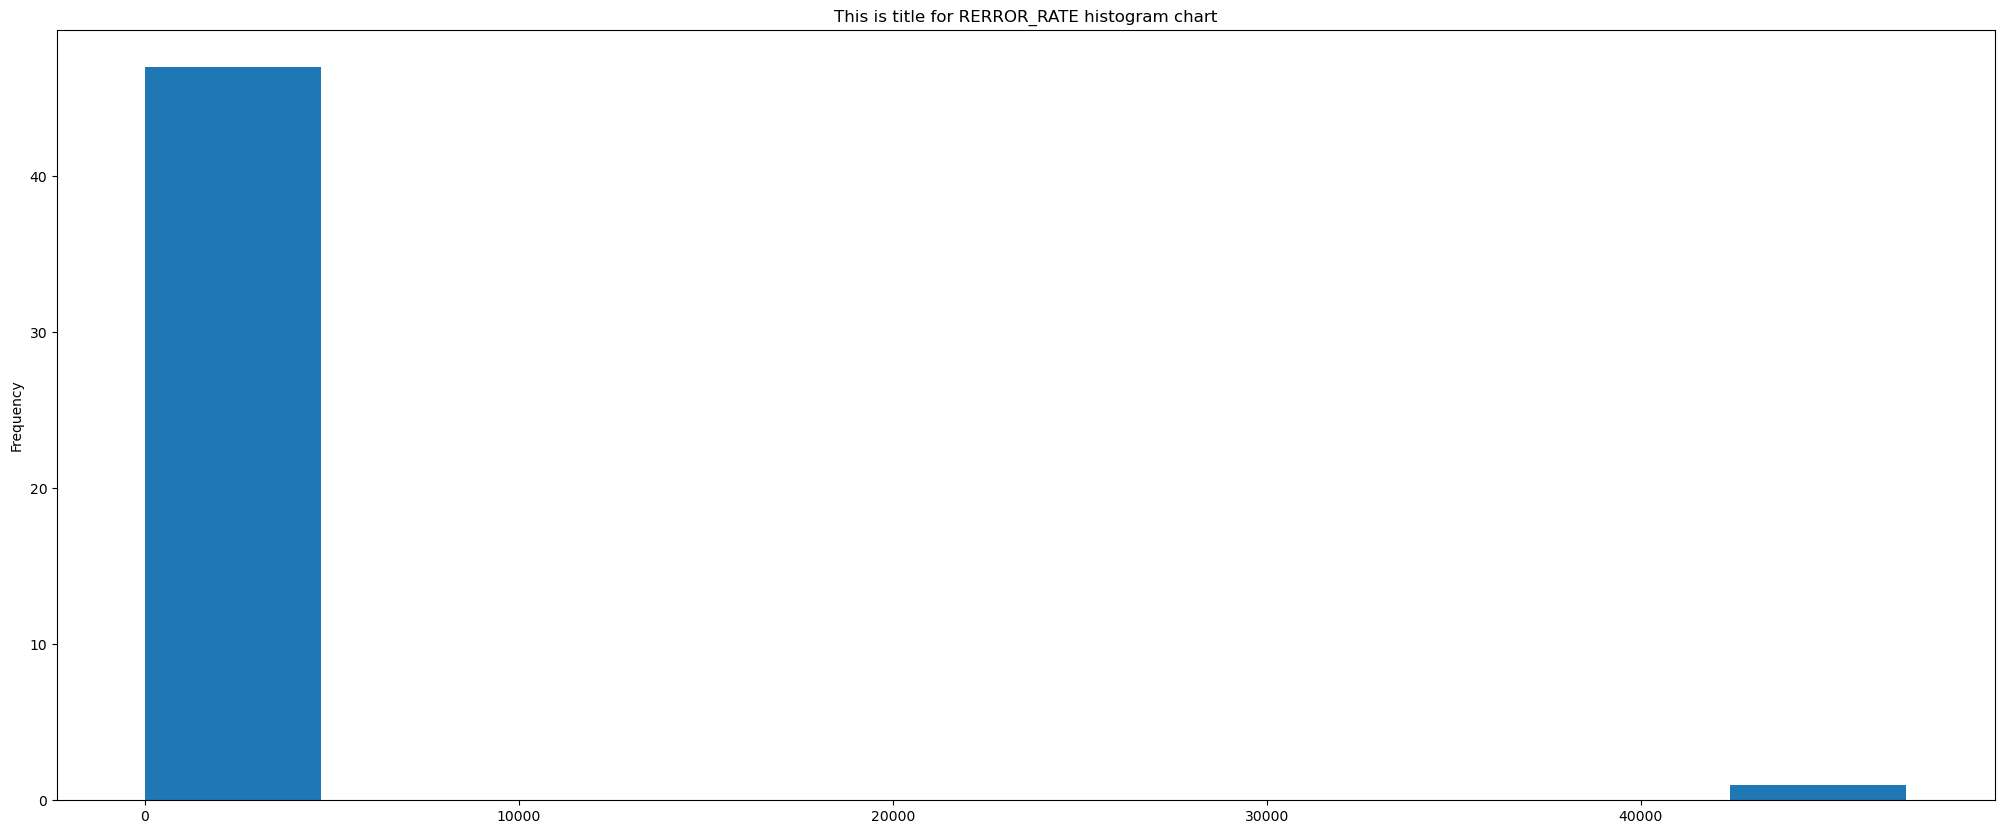

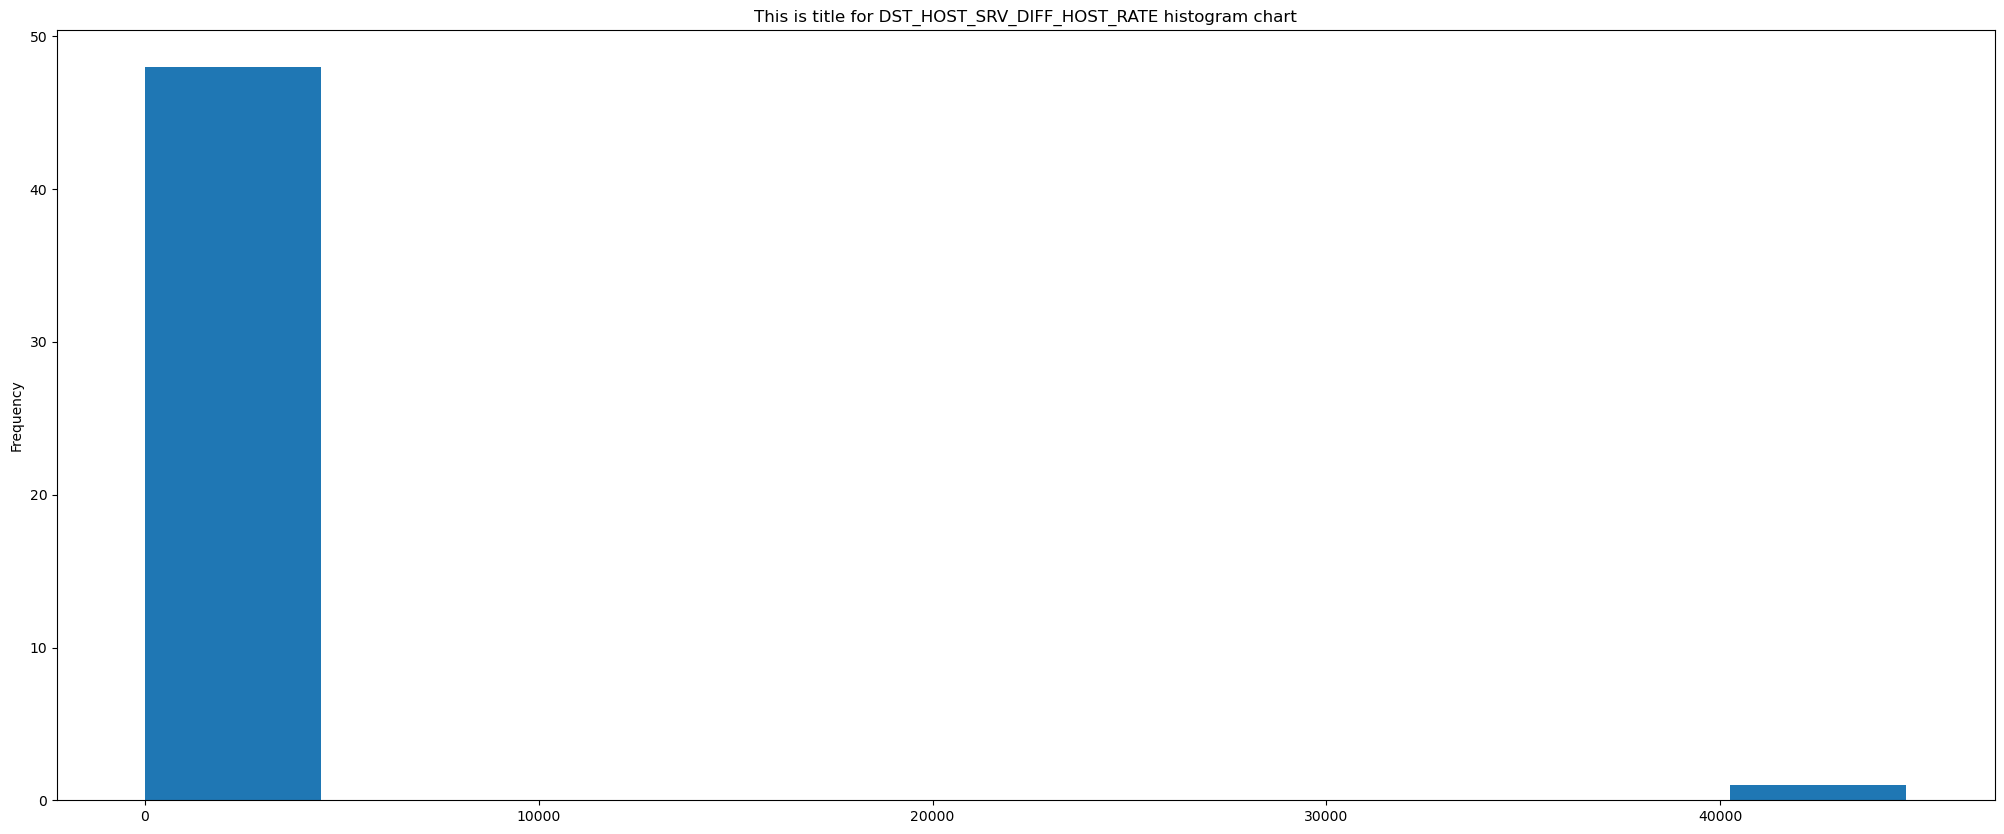

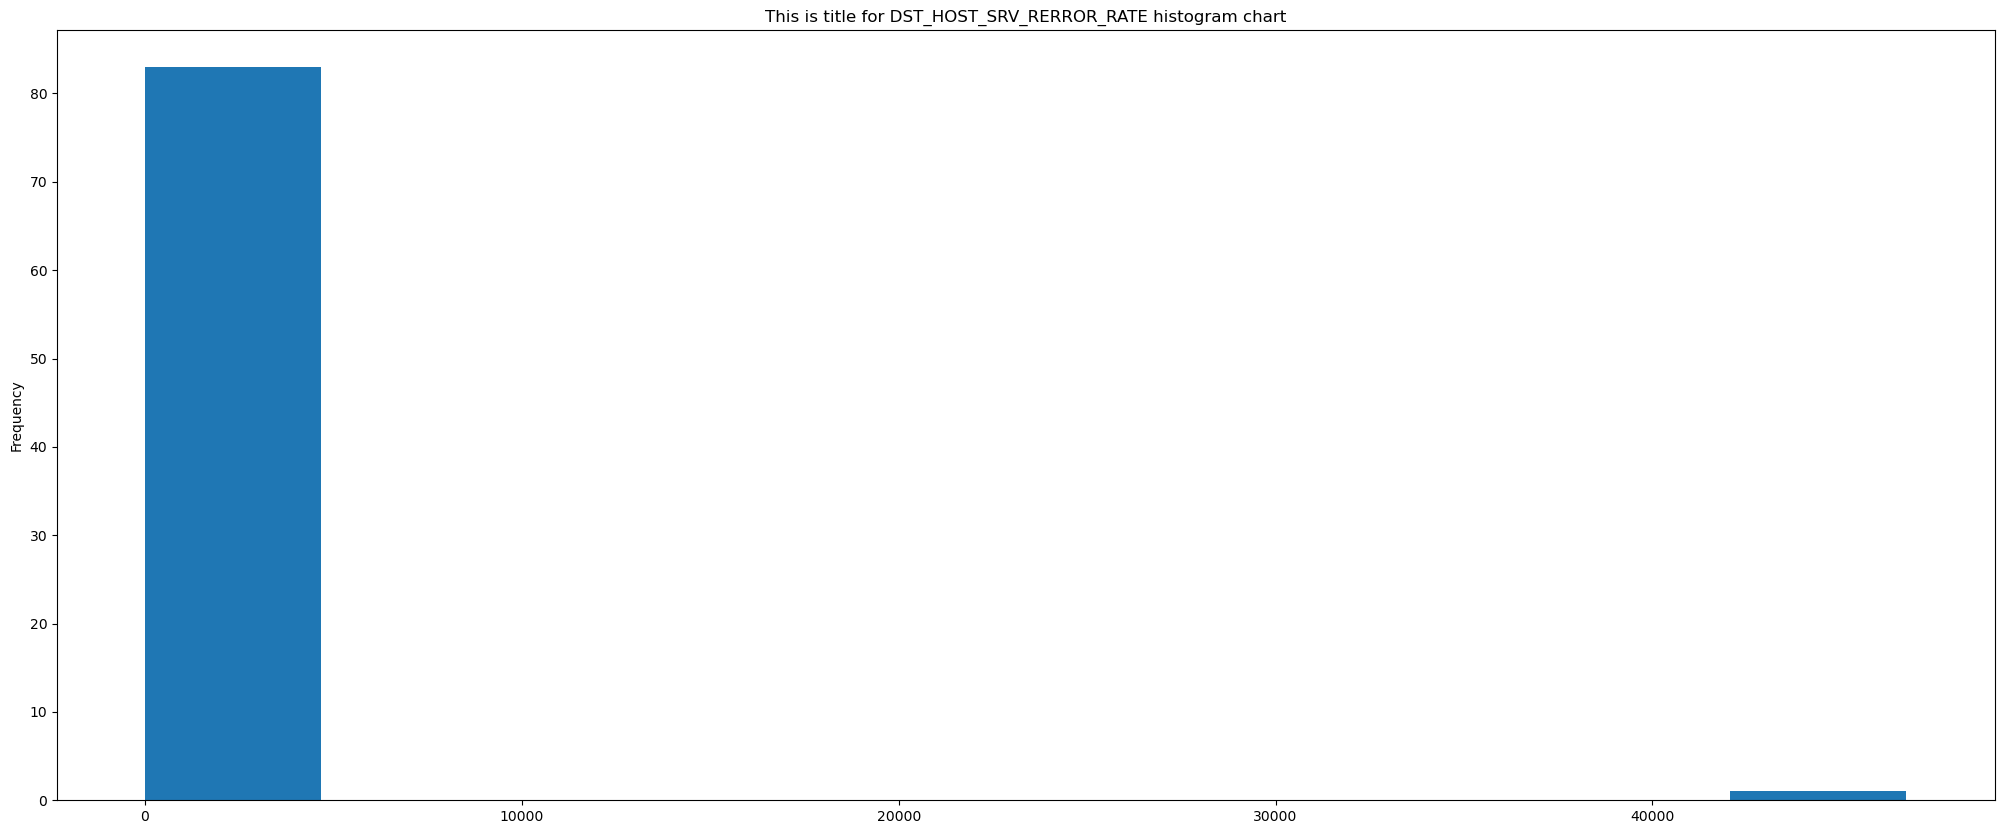

In [79]:
show_histogram_plots_for_all_continuous_plots(eda_kdd_cup_df, eda_kdd_cup_99_continuous_features)

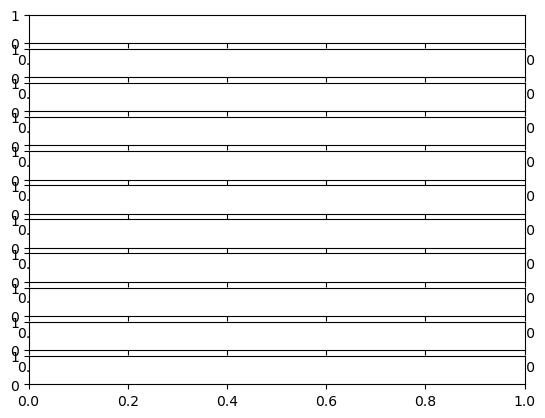

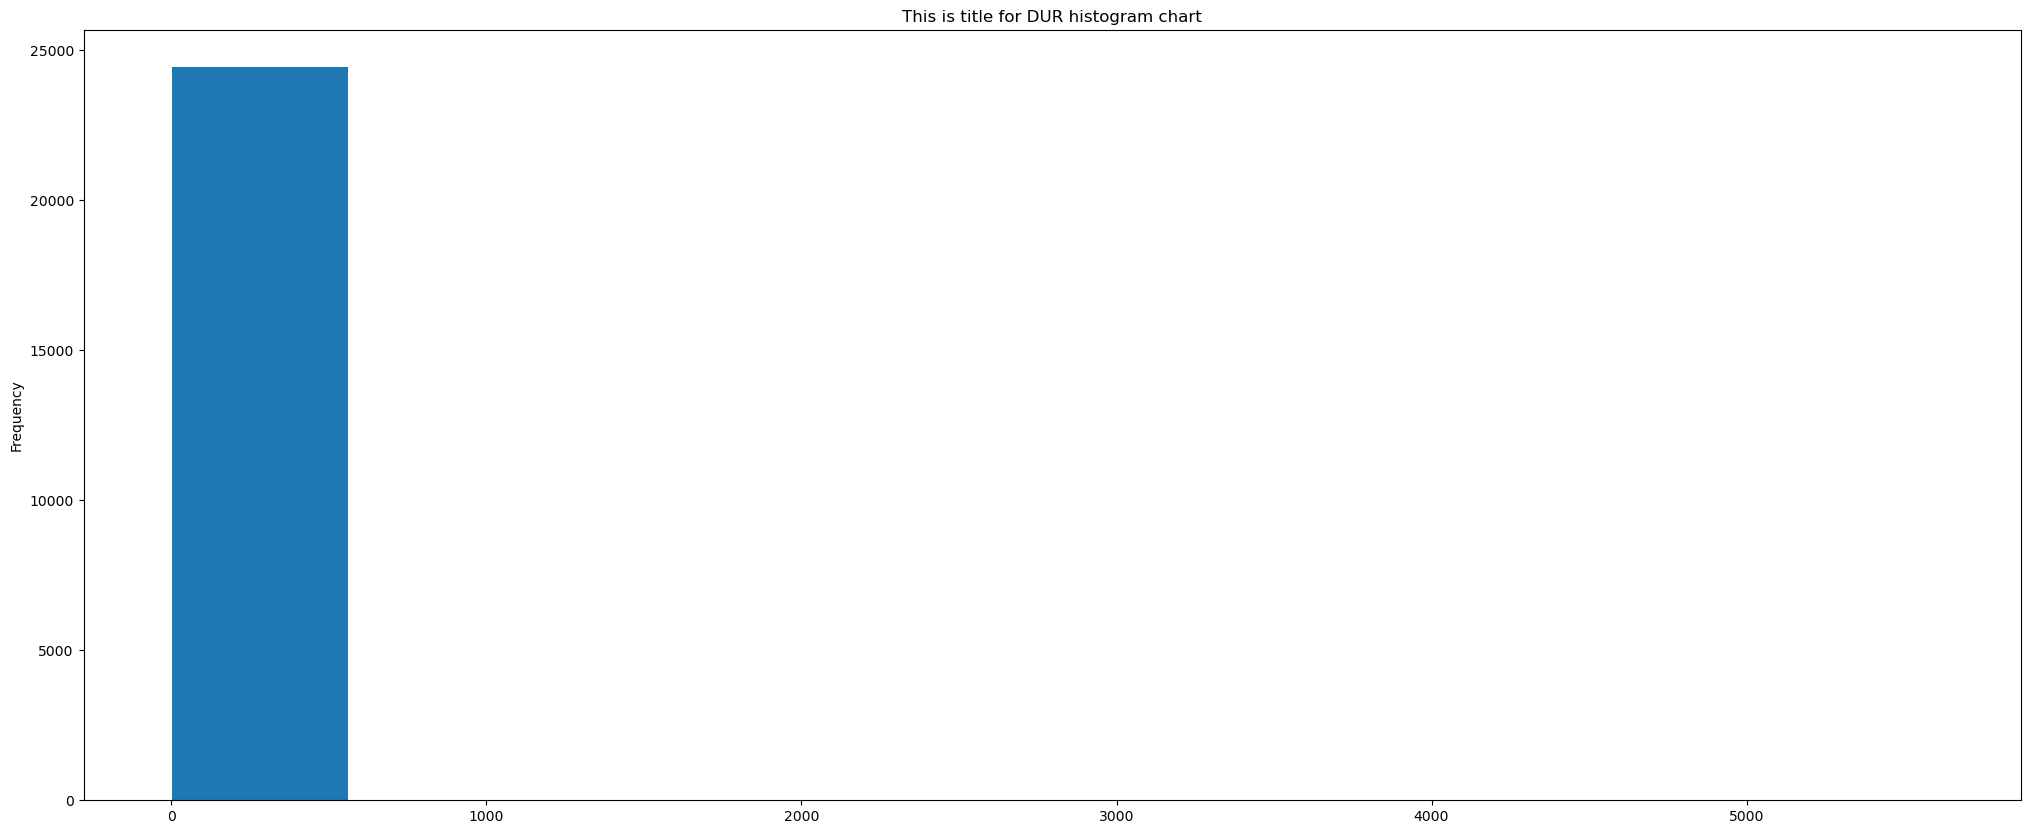

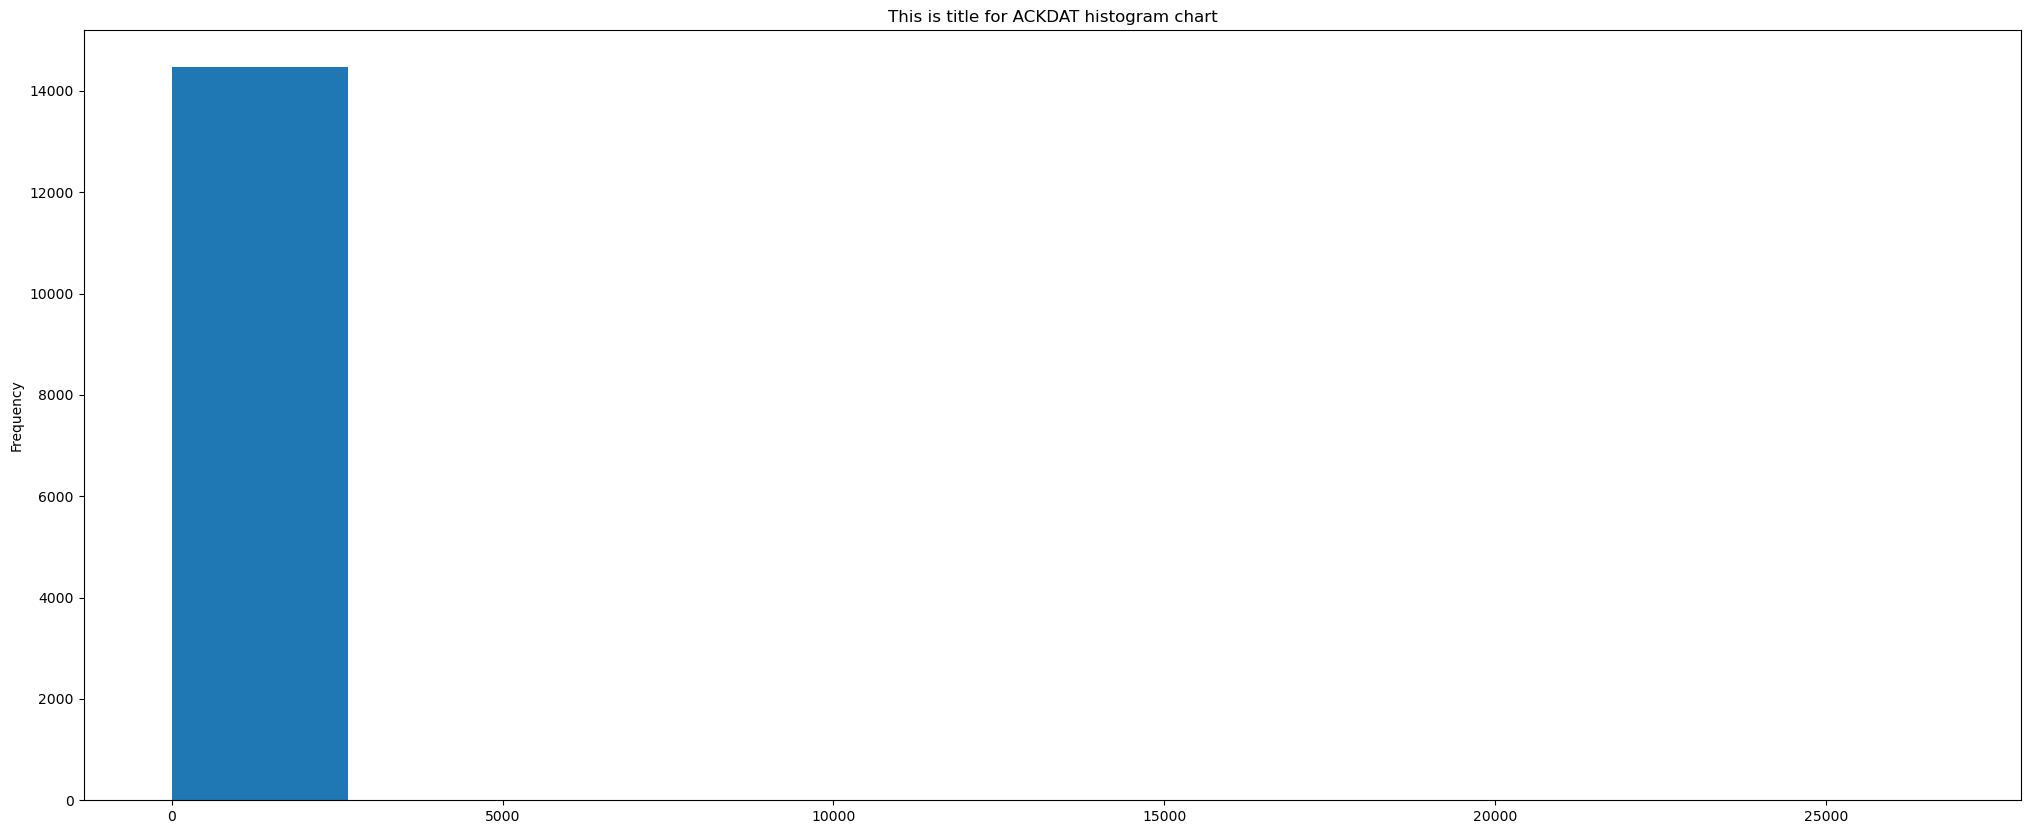

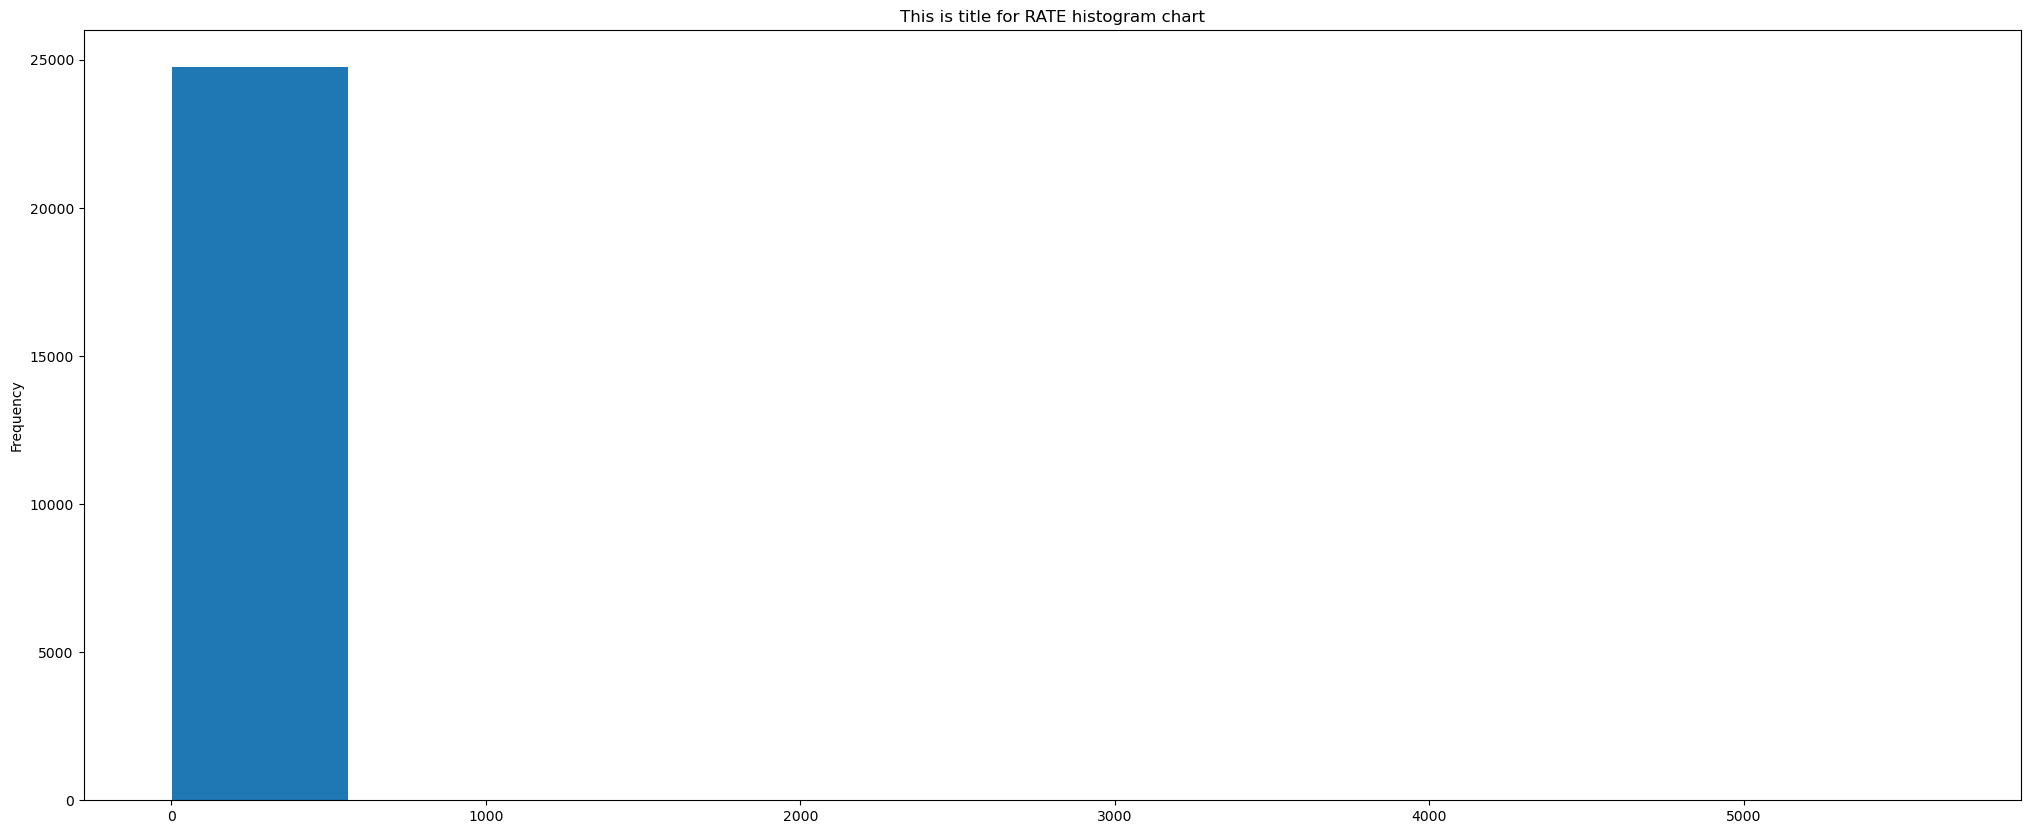

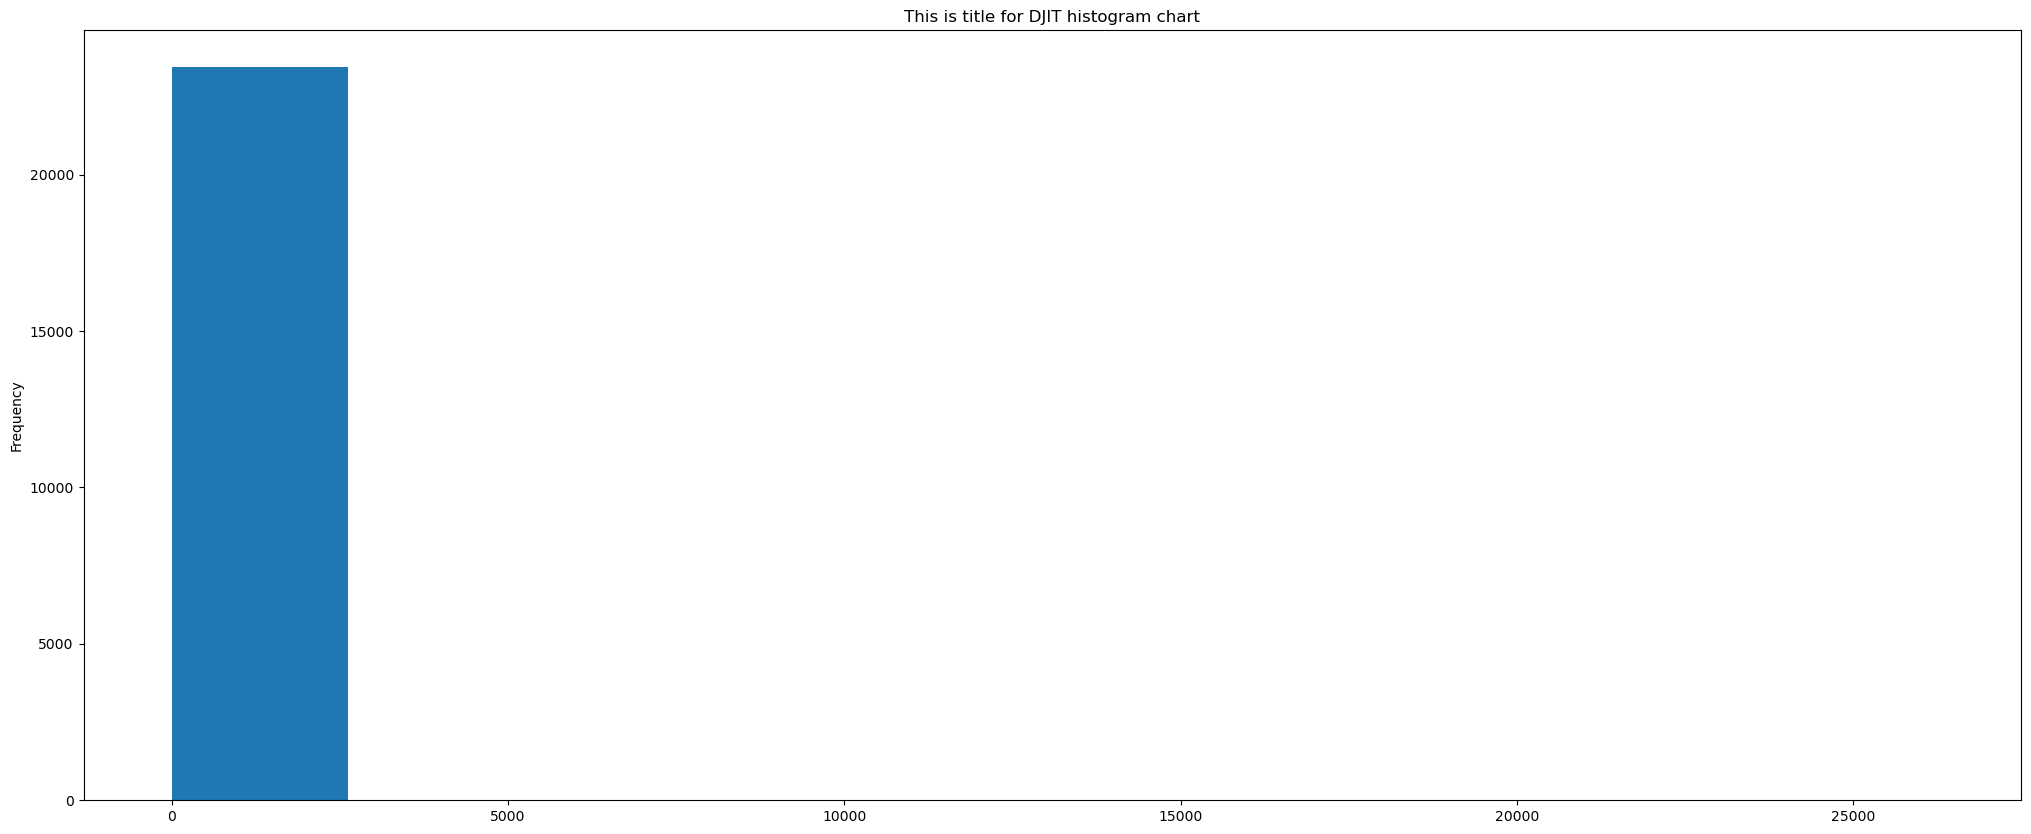

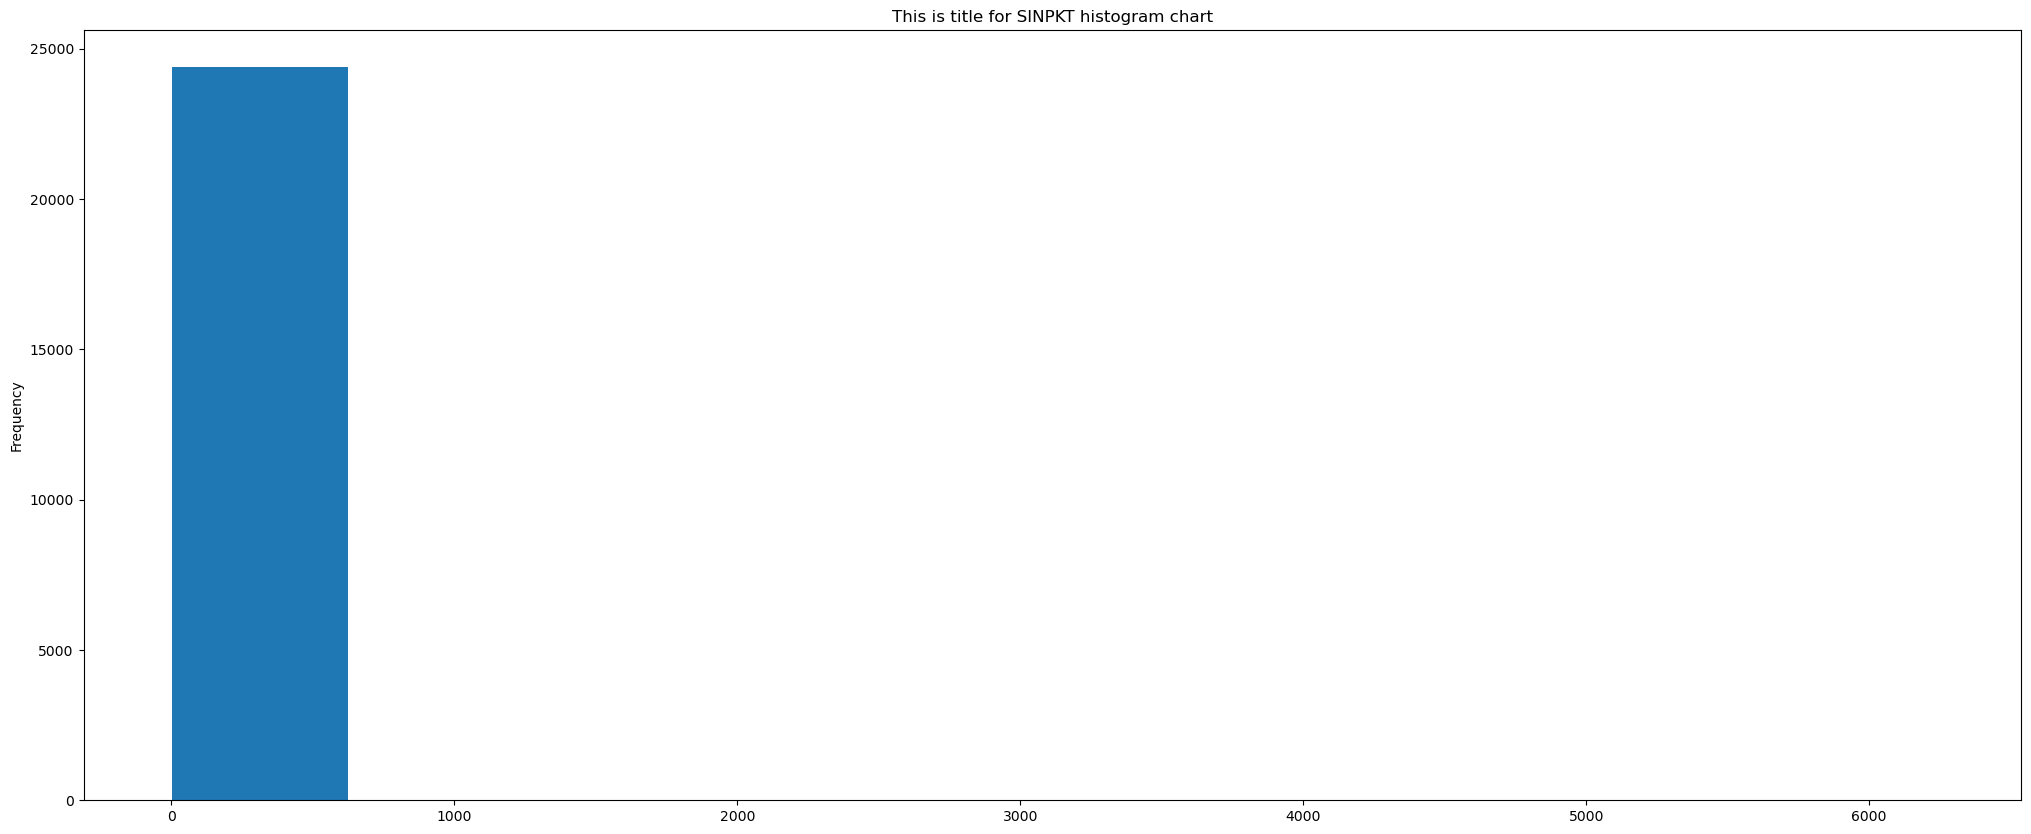

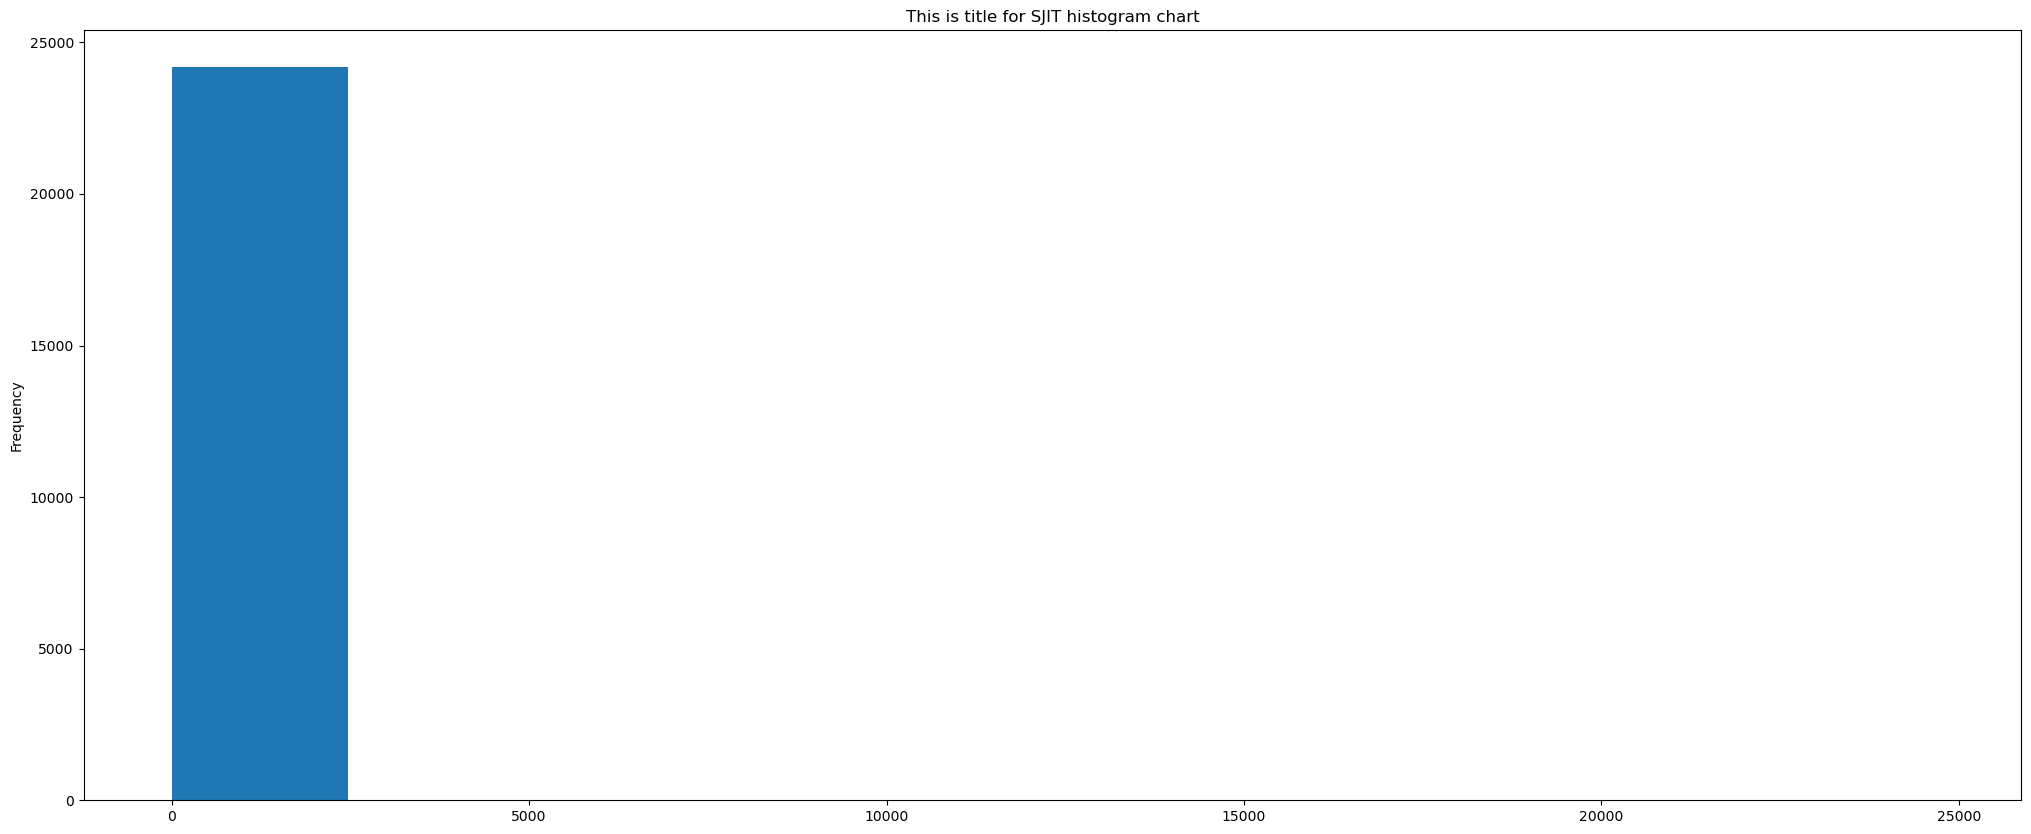

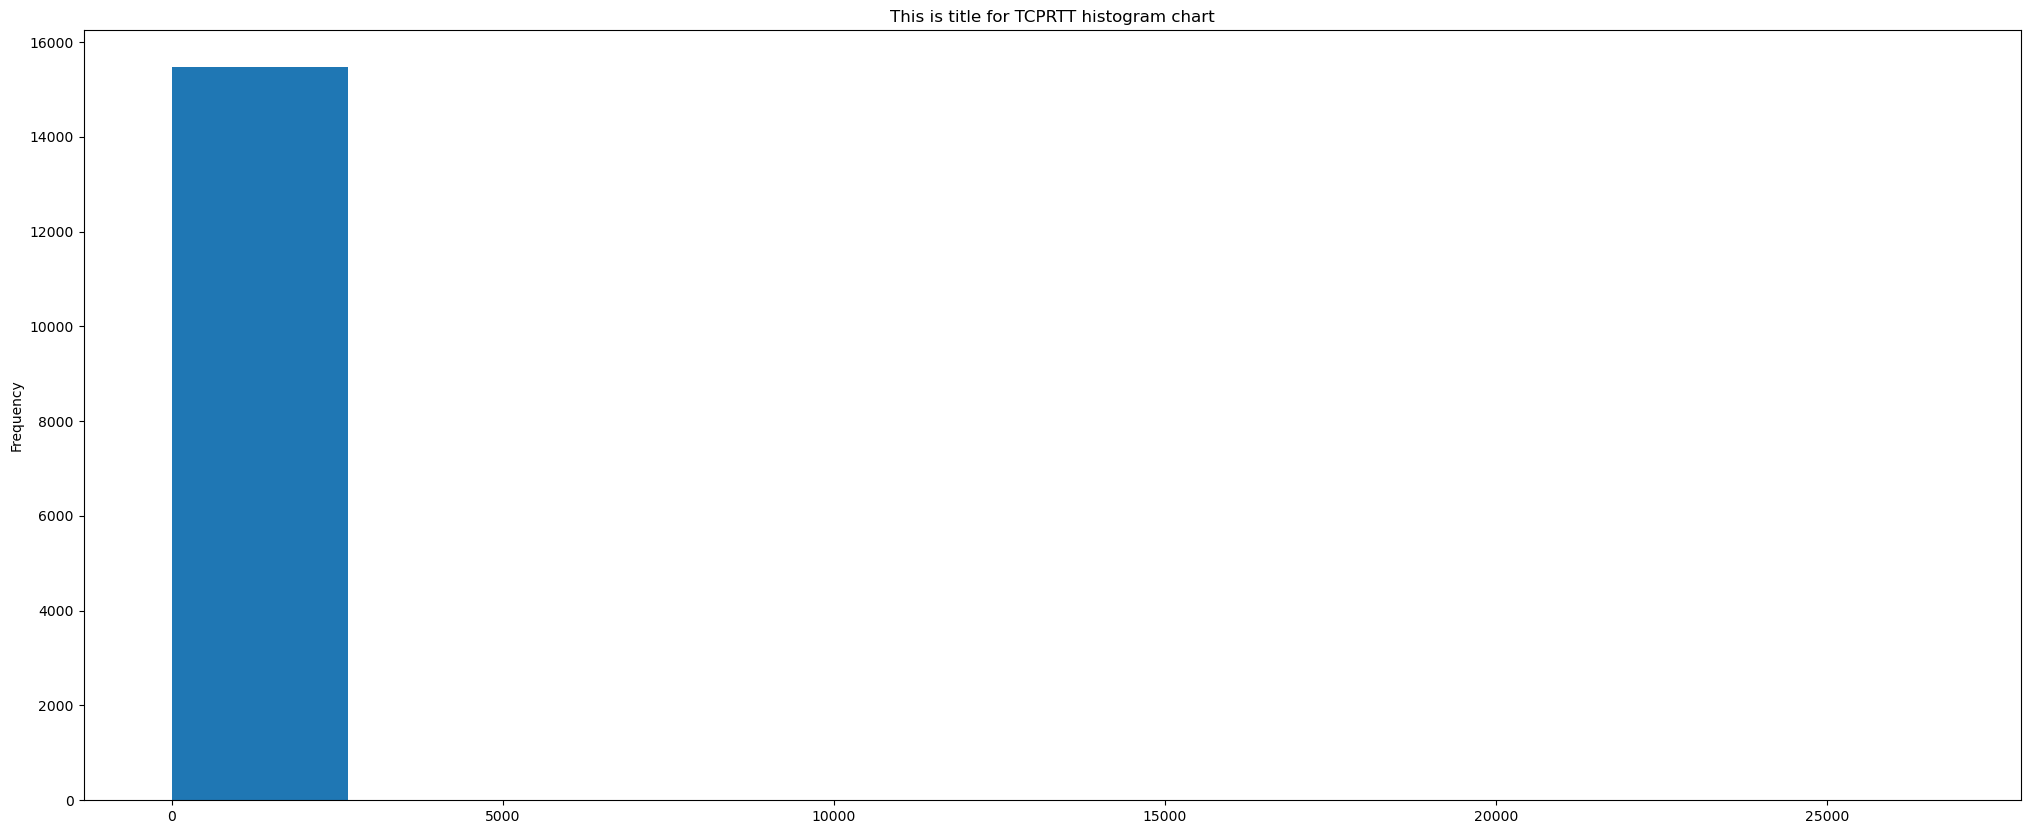

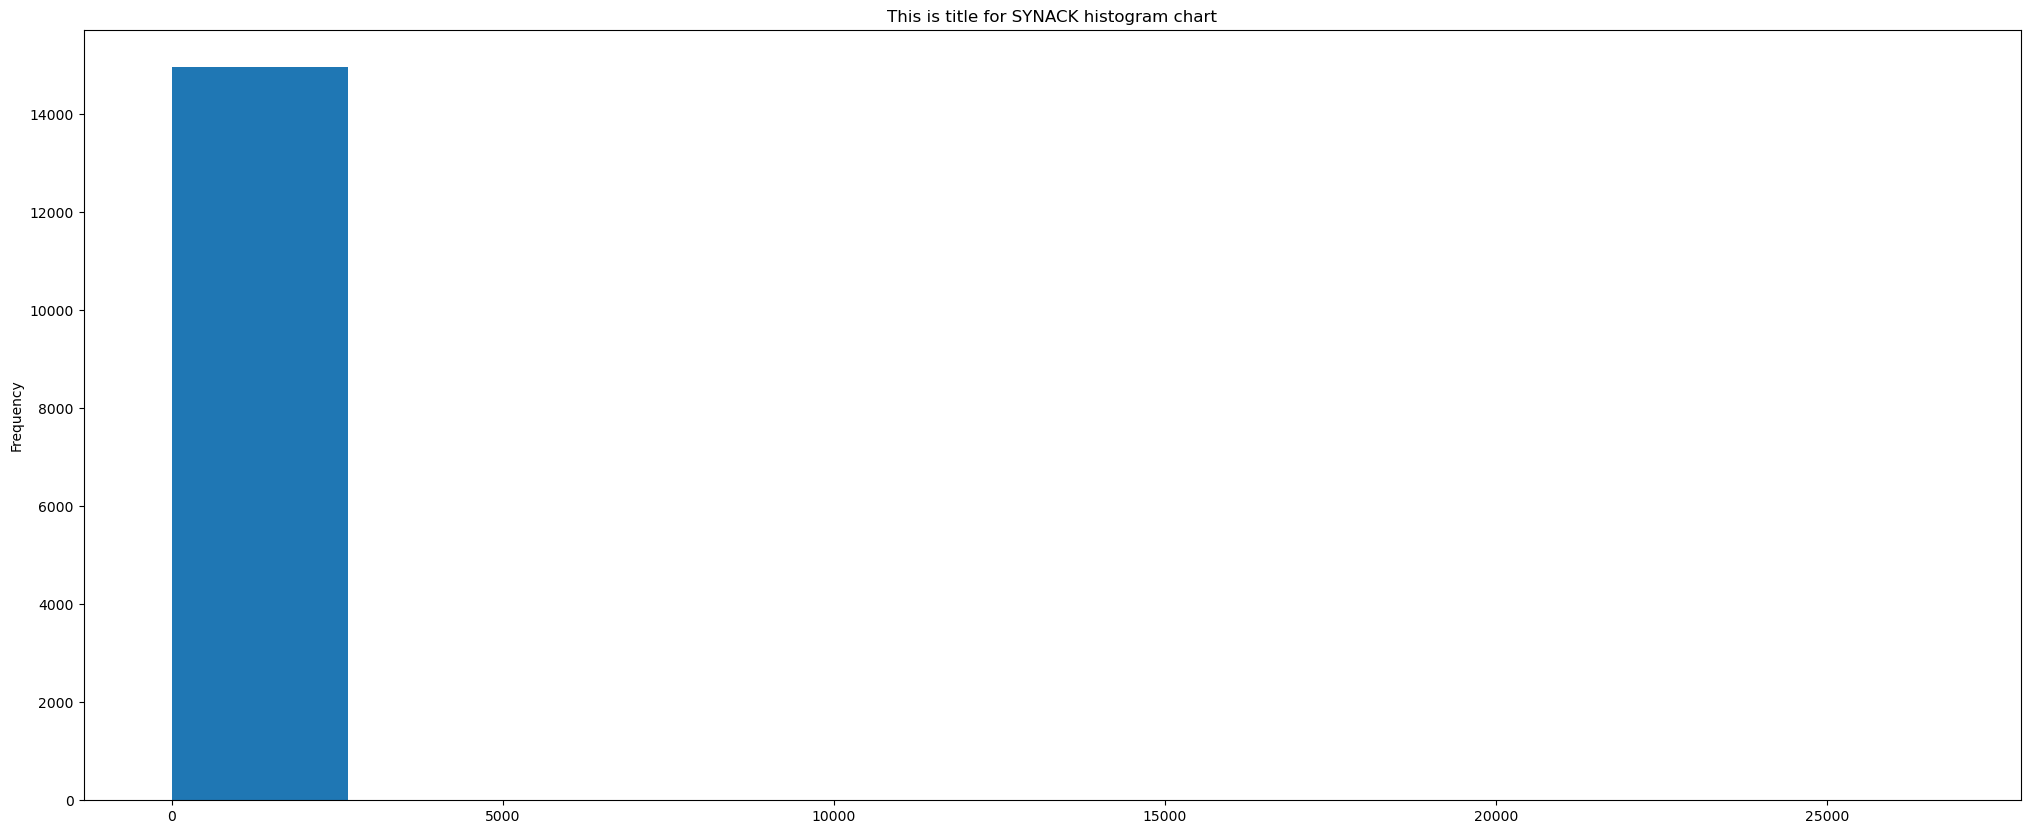

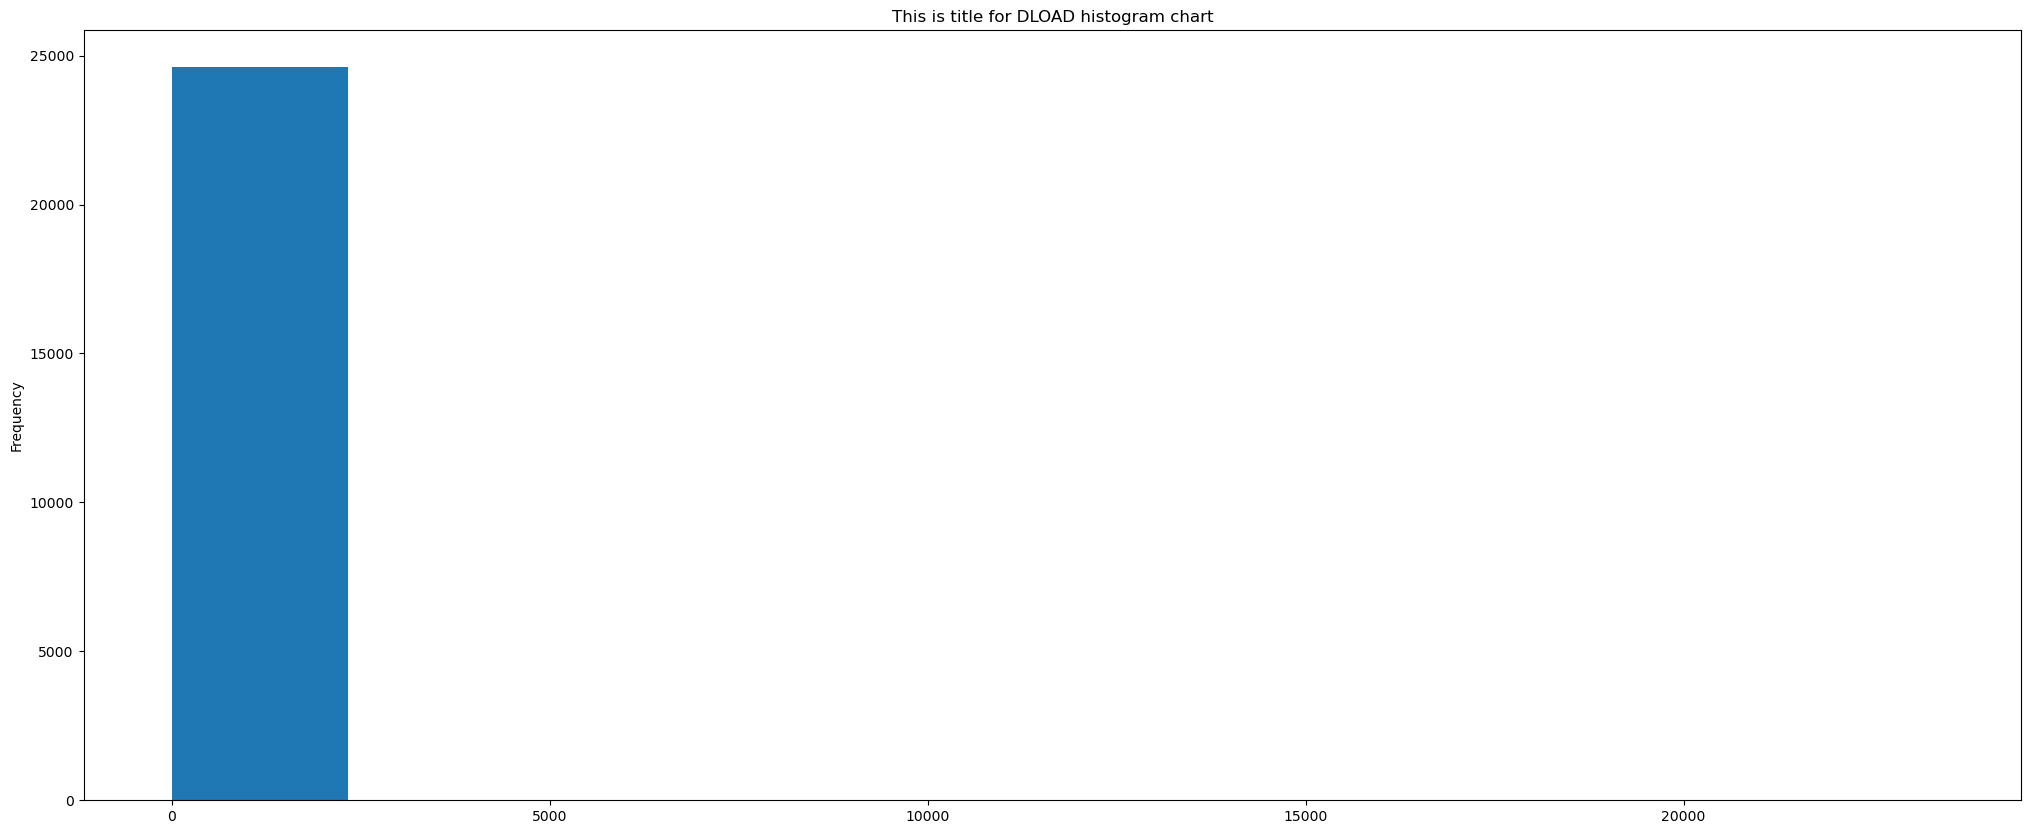

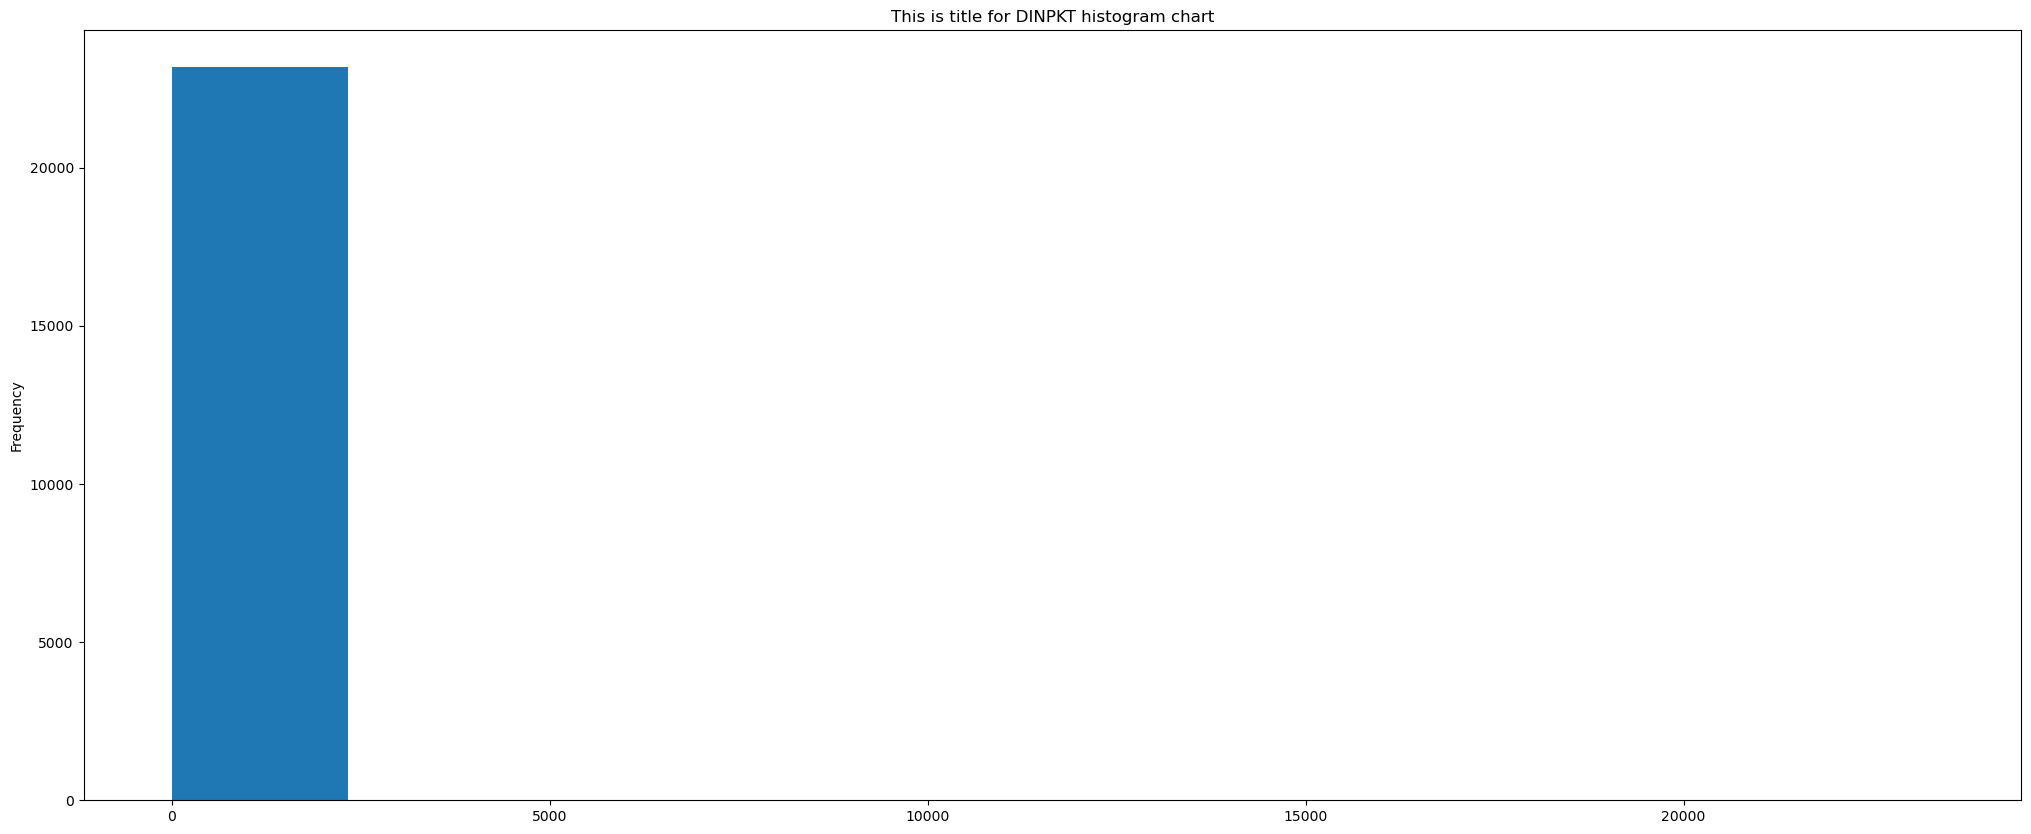

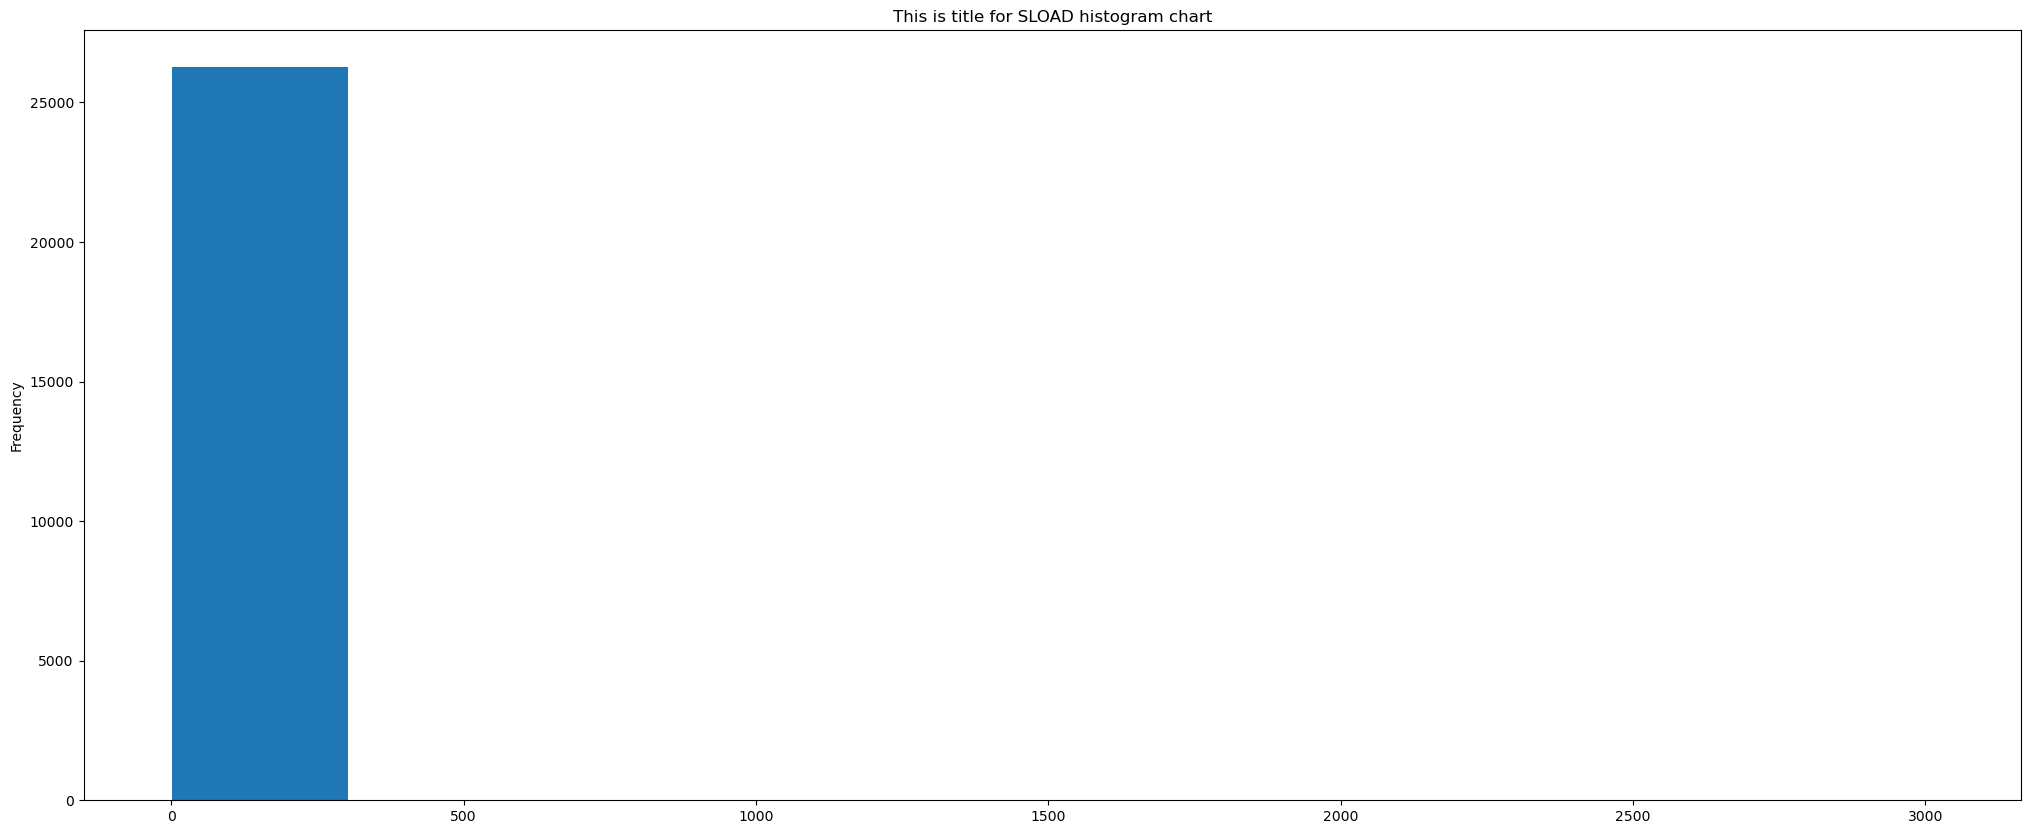

In [80]:
show_histogram_plots_for_all_continuous_plots(eda_unsw_nb15_df, eda_unsw_nb15_continuous_features)

#### Spliting and Standardizing Dataset for Experiment I

In [81]:
target_kdd_cup_df = kdd_cup_df[target_variable]
target_unsw_nb15_df = unsw_nb15_df[target_variable]

In [82]:
features_kdd_cup_df = kdd_cup_df.drop([target_variable], axis=1)
features_unsw_nb15_df = unsw_nb15_df.drop([target_variable], axis=1)

In [83]:
features_kdd_cup_df = process_feature_mapping(features_kdd_cup_df)




FEATURE MAPPING FOR OBJECT DATA STRUCTURE IN DATAFRAME

Processing feature mapping for protocol_type feature


Processing feature mapping for service feature


Processing feature mapping for flag feature




In [84]:
features_kdd_cup_df.head()

duration  protocol_type  service  flag  src_bytes  dst_bytes  land  \
4809851         0              0        0     0         44        110     0   
3032556         0              1        1     0       1032          0     0   
1295695         0              1        1     0       1032          0     0   
848990          1              2        2     0       1647        333     0   
2178455         0              1        1     0       1032          0     0   

         wrong_fragment  urgent  hot  ...  dst_host_count  dst_host_srv_count  \
4809851               0       0    0  ...             255                 253   
3032556               0       0    0  ...             255                 255   
1295695               0       0    0  ...             255                 255   
848990                0       0    0  ...              97                 169   
2178455               0       0    0  ...             255                 255   

         dst_host_same_srv_rate  dst_host_diff_srv_rate  \
4809851                    0.99                    0.01   
3032556                    1.00                    0.00   
1295695                    1.00                    0.00   
848990                     0.70                    0.05   
2178455                    1.00                    0.00   

         dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
4809851                         0.00                         0.00   
3032556                         1.00                         0.00   
1295695                         1.00                         0.00   
848990                          0.01                         0.01   
2178455                         1.00                         0.00   

         dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  \
4809851                   0.0                      0.00                   0.0   
3032556                   0.0                      0.00                   0.0   
1295695                   0.0                      0.00                   0.0   
848990                    0.0                      0.01                   0.0   
2178455                   0.0                      0.00                   0.0   

         dst_host_srv_rerror_rate  
4809851                       0.0  
3032556                       0.0  
1295695                       0.0  
848990                        0.0  
2178455                       0.0  

[5 rows x 41 columns]

In [85]:
features_unsw_nb15_df = process_feature_mapping(features_unsw_nb15_df)




FEATURE MAPPING FOR OBJECT DATA STRUCTURE IN DATAFRAME

Processing feature mapping for proto feature


Processing feature mapping for service feature


Processing feature mapping for state feature




In [86]:
features_unsw_nb15_df.head()

id       dur  proto  service  state  spkts  dpkts  sbytes  dbytes  \
182634  100303  0.816298      0        0      0     10      8     564     354   
153438   71107  0.000004      1        0      1      2      0     200       0   
44694    44695  0.593119      0        1      0     12     22    1384   21660   
252684  170353  0.000007      2        2      1      2      0     114       0   
98207    15876  0.001005      2        2      2      2      2     130     162   

                 rate  ...  ct_dst_ltm  ct_src_dport_ltm  ct_dst_sport_ltm  \
182634      20.825728  ...           1                 1                 1   
153438  250000.000600  ...           2                 2                 2   
44694       55.638074  ...           1                 1                 1   
252684  142857.140900  ...          31                31                23   
98207     2985.074718  ...           3                 2                 2   

        ct_dst_src_ltm  is_ftp_login  ct_ftp_cmd  ct_flw_http_mthd  \
182634               1             0           0                 0   
153438               4             0           0                 0   
44694                1             0           0                 1   
252684              31             0           0                 0   
98207                3             0           0                 0   

        ct_src_ltm  ct_srv_dst  is_sm_ips_ports  
182634          18           1                0  
153438          24           4                0  
44694            2           1                0  
252684          32          31                0  
98207           10           4                0  

[5 rows x 43 columns]

In [87]:
kddcup_X_train, kddcup_X_test, kddcup_y_train, kddcup_y_test = train_test_split(features_kdd_cup_df, target_kdd_cup_df, test_size = 0.2, random_state = 0)

In [88]:
unsw_nb15_X_train, unsw_nb15_X_test, unsw_nb15_y_train, unsw_nb15_y_test = train_test_split(features_unsw_nb15_df, target_unsw_nb15_df, test_size = 0.2, random_state = 0)

In [89]:
sc = MinMaxScaler()

kddcup_X_train = sc.fit_transform(kddcup_X_train)
kddcup_X_test = sc.fit_transform(kddcup_X_test)

unsw_nb15_X_train = sc.fit_transform(unsw_nb15_X_train)
unsw_nb15_X_test = sc.fit_transform(unsw_nb15_X_test)

In [90]:
ros = SMOTE()

kddcup_X_train, kddcup_y_train = ros.fit_resample(kddcup_X_train, kddcup_y_train)

unsw_nb15_X_train, unsw_nb15_y_train = ros.fit_resample(unsw_nb15_X_train, unsw_nb15_y_train)

In [91]:
print(kddcup_y_train.agg(['nunique','count','size']))
print()
print(kddcup_y_train[kddcup_y_train == 0].count())
print()
print(kddcup_y_train[kddcup_y_train == 1].count())

nunique        2
count      64096
size       64096
Name: traffic_type, dtype: int64

32048

32048


In [92]:
print(unsw_nb15_y_train.agg(['nunique','count','size']))
print()
print(unsw_nb15_y_train[unsw_nb15_y_train == 0].count())
print()
print(unsw_nb15_y_train[unsw_nb15_y_train == 1].count())

nunique        2
count      51146
size       51146
Name: traffic_type, dtype: int64

25573

25573


In [93]:
analysis_df_dict[kddcup99] = dict()
analysis_df_dict[kddcup99][x_train_key] = kddcup_X_train
analysis_df_dict[kddcup99][x_test_key] = kddcup_X_test
analysis_df_dict[kddcup99][y_train_key] = kddcup_y_train
analysis_df_dict[kddcup99][y_test_key] = kddcup_y_test 

analysis_df_dict[unswnb15] = dict()
analysis_df_dict[unswnb15][x_train_key] = unsw_nb15_X_train
analysis_df_dict[unswnb15][x_test_key] = unsw_nb15_X_test
analysis_df_dict[unswnb15][y_train_key] = unsw_nb15_y_train
analysis_df_dict[unswnb15][y_test_key] = unsw_nb15_y_test

#### Experiment I

In [94]:
experiment_type = "EXPERIMENT-ONE"



ANALYSIS SUMMARY FOR NAIVE BAYES CLASSIFIER MODEL FOR KDD CUPP 99 DATASET





TRAINING TIME

0.09






TESTING TIME

0.01



CLASSIFICTION REPORT

              precision    recall  f1-score   support

      Normal       0.85      0.98      0.91      1772
      Attack       1.00      0.96      0.98      8228

    accuracy                           0.97     10000
   macro avg       0.92      0.97      0.95     10000
weighted avg       0.97      0.97      0.97     10000




CONFUSION MATRIX



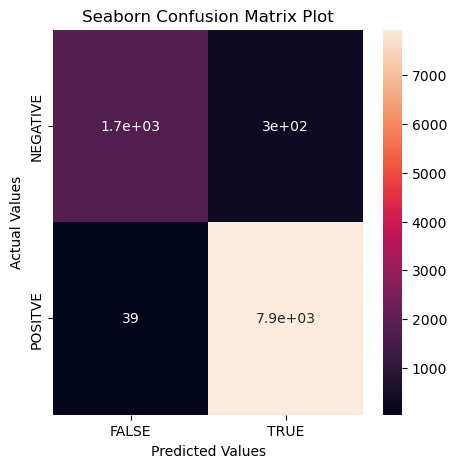




MODEL PERFORMANCE EVALUATION

AUC SCORE:  0.9248
GEOMETRIC MEAN SCORE:  0.9221










ANALYSIS SUMMARY FOR NAIVE BAYES CLASSIFIER MODEL FOR UNSW NB15 DATASET





TRAINING TIME

0.05






TESTING TIME

0.02



CLASSIFICTION REPORT

              precision    recall  f1-score   support

      Normal       0.89      0.67      0.76      4776
      Attack       0.75      0.92      0.83      5224

    accuracy                           0.80     10000
   macro avg       0.82      0.80      0.80     10000
weighted avg       0.82      0.80      0.80     10000




CONFUSION MATRIX



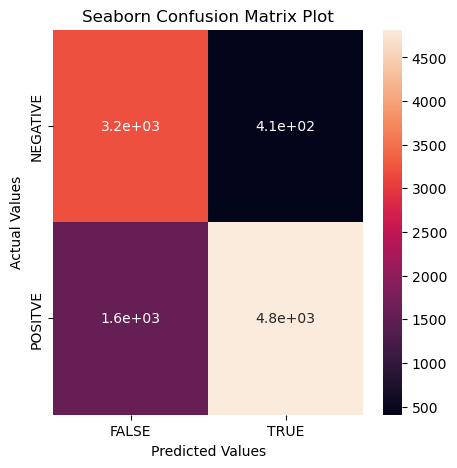




MODEL PERFORMANCE EVALUATION

AUC SCORE:  0.8204
GEOMETRIC MEAN SCORE:  0.8177










In [95]:
perform_NaiveBayes_model_analysis(analysis_df_dict, analysis_results, experiment_type)



ANALYSIS SUMMARY FOR SUPPORT VECTOR MACHINE MODEL FOR KDD CUPP 99 DATASET





TRAINING TIME

2.18






TESTING TIME

0.32



CLASSIFICTION REPORT

              precision    recall  f1-score   support

      Normal       1.00      0.99      1.00      2046
      Attack       1.00      1.00      1.00      7954

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000




CONFUSION MATRIX



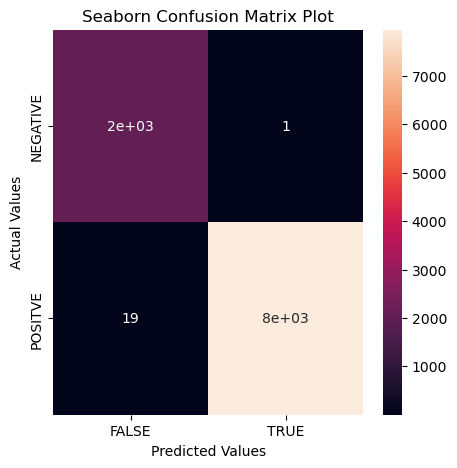




MODEL PERFORMANCE EVALUATION

AUC SCORE:  0.9986
GEOMETRIC MEAN SCORE:  0.9986










ANALYSIS SUMMARY FOR SUPPORT VECTOR MACHINE MODEL FOR UNSW NB15 DATASET





TRAINING TIME

61.72






TESTING TIME

14.71



CLASSIFICTION REPORT

              precision    recall  f1-score   support

      Normal       0.93      0.83      0.88      4057
      Attack       0.89      0.96      0.92      5943

    accuracy                           0.90     10000
   macro avg       0.91      0.89      0.90     10000
weighted avg       0.91      0.90      0.90     10000




CONFUSION MATRIX



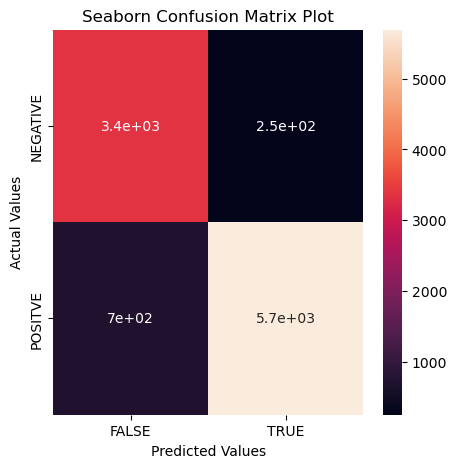




MODEL PERFORMANCE EVALUATION

AUC SCORE:  0.9104
GEOMETRIC MEAN SCORE:  0.9102










In [96]:
perform_SVM_model_analysis(analysis_df_dict, analysis_results, experiment_type)



ANALYSIS SUMMARY FOR DECISION TREE CLASSIFIER MODEL FOR KDD CUPP 99 DATASET





TRAINING TIME

0.19






TESTING TIME

0.00



CLASSIFICTION REPORT

              precision    recall  f1-score   support

      Normal       1.00      0.99      0.99      2047
      Attack       1.00      1.00      1.00      7953

    accuracy                           1.00     10000
   macro avg       1.00      0.99      0.99     10000
weighted avg       1.00      1.00      1.00     10000




CONFUSION MATRIX



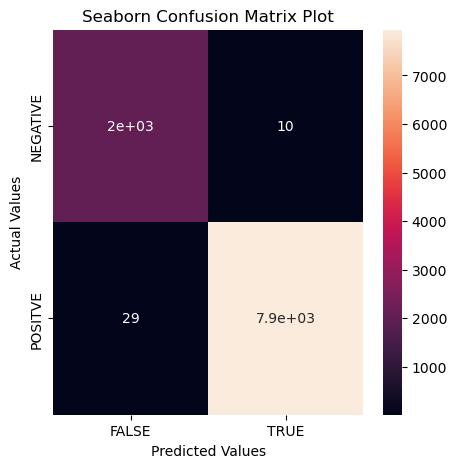




MODEL PERFORMANCE EVALUATION

AUC SCORE:  0.9957
GEOMETRIC MEAN SCORE:  0.9957










ANALYSIS SUMMARY FOR DECISION TREE CLASSIFIER MODEL FOR UNSW NB15 DATASET





TRAINING TIME

0.43






TESTING TIME

0.00



CLASSIFICTION REPORT

              precision    recall  f1-score   support

      Normal       0.99      0.69      0.82      5157
      Attack       0.75      0.99      0.86      4843

    accuracy                           0.84     10000
   macro avg       0.87      0.84      0.84     10000
weighted avg       0.88      0.84      0.84     10000




CONFUSION MATRIX



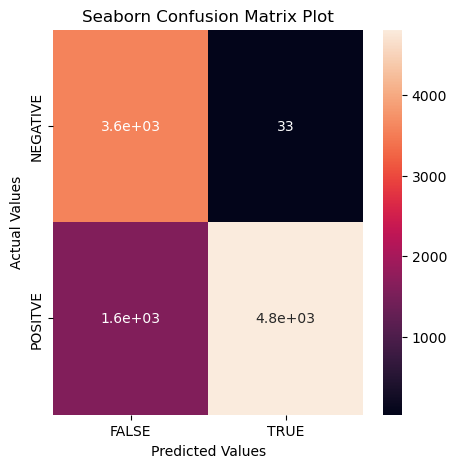




MODEL PERFORMANCE EVALUATION

AUC SCORE:  0.8715
GEOMETRIC MEAN SCORE:  0.8633










In [97]:
perform_DecisionTree_model_analysis(analysis_df_dict, analysis_results, experiment_type)



ANALYSIS SUMMARY FOR RANDOM FOREST CLASSIFIER MODEL FOR KDD CUPP 99 DATASET





TRAINING TIME

0.95






TESTING TIME

0.02



CLASSIFICTION REPORT

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      2035
      Attack       1.00      1.00      1.00      7965

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000




CONFUSION MATRIX



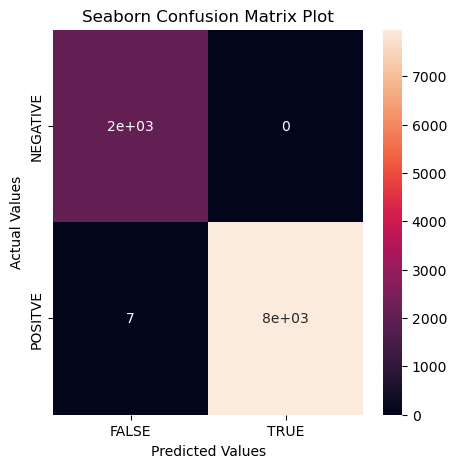




MODEL PERFORMANCE EVALUATION

AUC SCORE:  0.9996
GEOMETRIC MEAN SCORE:  0.9996










ANALYSIS SUMMARY FOR RANDOM FOREST CLASSIFIER MODEL FOR UNSW NB15 DATASET





TRAINING TIME

2.77






TESTING TIME

0.06



CLASSIFICTION REPORT

              precision    recall  f1-score   support

      Normal       0.97      0.91      0.94      3850
      Attack       0.94      0.98      0.96      6150

    accuracy                           0.95     10000
   macro avg       0.96      0.94      0.95     10000
weighted avg       0.95      0.95      0.95     10000




CONFUSION MATRIX



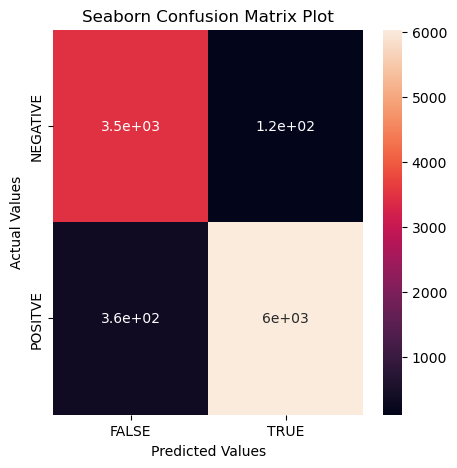




MODEL PERFORMANCE EVALUATION

AUC SCORE:  0.9553
GEOMETRIC MEAN SCORE:  0.9552










In [98]:
perform_RFC_model_analysis(analysis_df_dict, analysis_results, experiment_type)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 41)                1722      
                                                                 
 dense_1 (Dense)             (None, 1)                 42        
                                                                 
 dense_2 (Dense)             (None, 2)                 4         
                                                                 
Total params: 1,768
Trainable params: 1,768
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
641/641 [==============================] - 3s 4ms/step - loss: 0.5331 - accuracy: 0.8975
Epoch 2/10
641/641 [==============================] - 2s 3ms/step - loss: 0.3169 - accuracy: 0.9973
Epoch 3/10
641/641 [==============================] - 2s 3ms/step - loss: 0.2088 - accuracy: 0.9973
Epoch 4/10
641/641

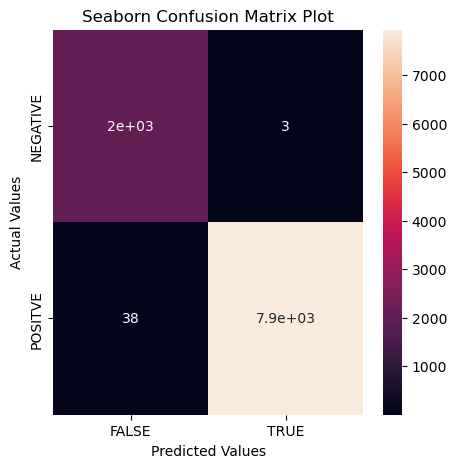




MODEL PERFORMANCE EVALUATION

AUC SCORE:  0.9969
GEOMETRIC MEAN SCORE:  0.9969








Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 43)                1892      
                                                                 
 dense_4 (Dense)             (None, 1)                 44        
                                                                 
 dense_5 (Dense)             (None, 2)                 4         
                                                                 
Total params: 1,940
Trainable params: 1,940
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
512/512 [==============================] - 2s 3ms/step - loss: 0.6126 - accuracy: 0.7442
Epoch 2/10
512/512 [==============================] - 2s 3ms/step - loss: 0.4542 - accuracy: 0.8856
Epoch 3/10
512/512 [======

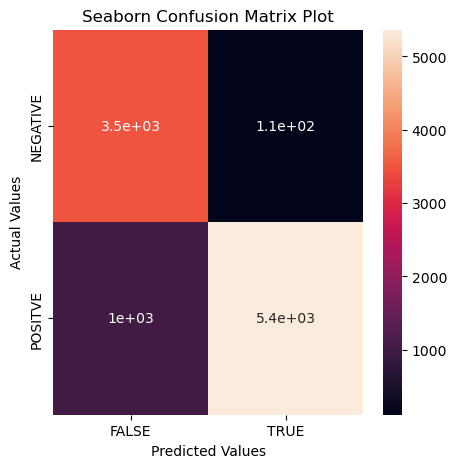




MODEL PERFORMANCE EVALUATION

AUC SCORE:  0.9036
GEOMETRIC MEAN SCORE:  0.9013










In [99]:
perform_ANN_model_analysis(analysis_df_dict, analysis_results, experiment_type)

#### Summary Table for Experiment I

In [100]:
KDD_Analysis_Summary_df = pd.DataFrame({
    AUC: [analysis_results[kddcup99][experiment_type][NBC][AUC], analysis_results[kddcup99][experiment_type][SVM][AUC], analysis_results[kddcup99][experiment_type][DTC][AUC], analysis_results[kddcup99][experiment_type][RFC][AUC], analysis_results[kddcup99][experiment_type][ANN][AUC]],
    GMEAN: [analysis_results[kddcup99][experiment_type][NBC][GMEAN], analysis_results[kddcup99][experiment_type][SVM][GMEAN], analysis_results[kddcup99][experiment_type][DTC][GMEAN], analysis_results[kddcup99][experiment_type][RFC][GMEAN], analysis_results[kddcup99][experiment_type][ANN][GMEAN]],
}, index=[NBC, SVM, DTC, RFC, ANN])

In [101]:
UNSWNB15_Analysis_Summary_df = pd.DataFrame({
    AUC: [analysis_results[unswnb15][experiment_type][NBC][AUC], analysis_results[unswnb15][experiment_type][SVM][AUC], analysis_results[unswnb15][experiment_type][DTC][AUC], analysis_results[unswnb15][experiment_type][RFC][AUC], analysis_results[unswnb15][experiment_type][ANN][AUC]],
    GMEAN: [analysis_results[unswnb15][experiment_type][NBC][GMEAN], analysis_results[unswnb15][experiment_type][SVM][GMEAN], analysis_results[unswnb15][experiment_type][DTC][GMEAN], analysis_results[unswnb15][experiment_type][RFC][GMEAN], analysis_results[unswnb15][experiment_type][ANN][GMEAN]],
}, index=[NBC, SVM, DTC, RFC, ANN])

In [102]:
KDD_Analysis_Summary_df

AUC    G-MEAN
NBC  0.924822  0.922147
SVM  0.998562  0.998561
DTC  0.995716  0.995715
RFC  0.999561  0.999561
ANN  0.996877  0.996876

In [103]:
UNSWNB15_Analysis_Summary_df

AUC    G-MEAN
NBC  0.820390  0.817650
SVM  0.910439  0.910215
DTC  0.871498  0.863287
RFC  0.955252  0.955177
ANN  0.903579  0.901252

### Experiment II Setup

#### Correlation Heatmap for the two datasets

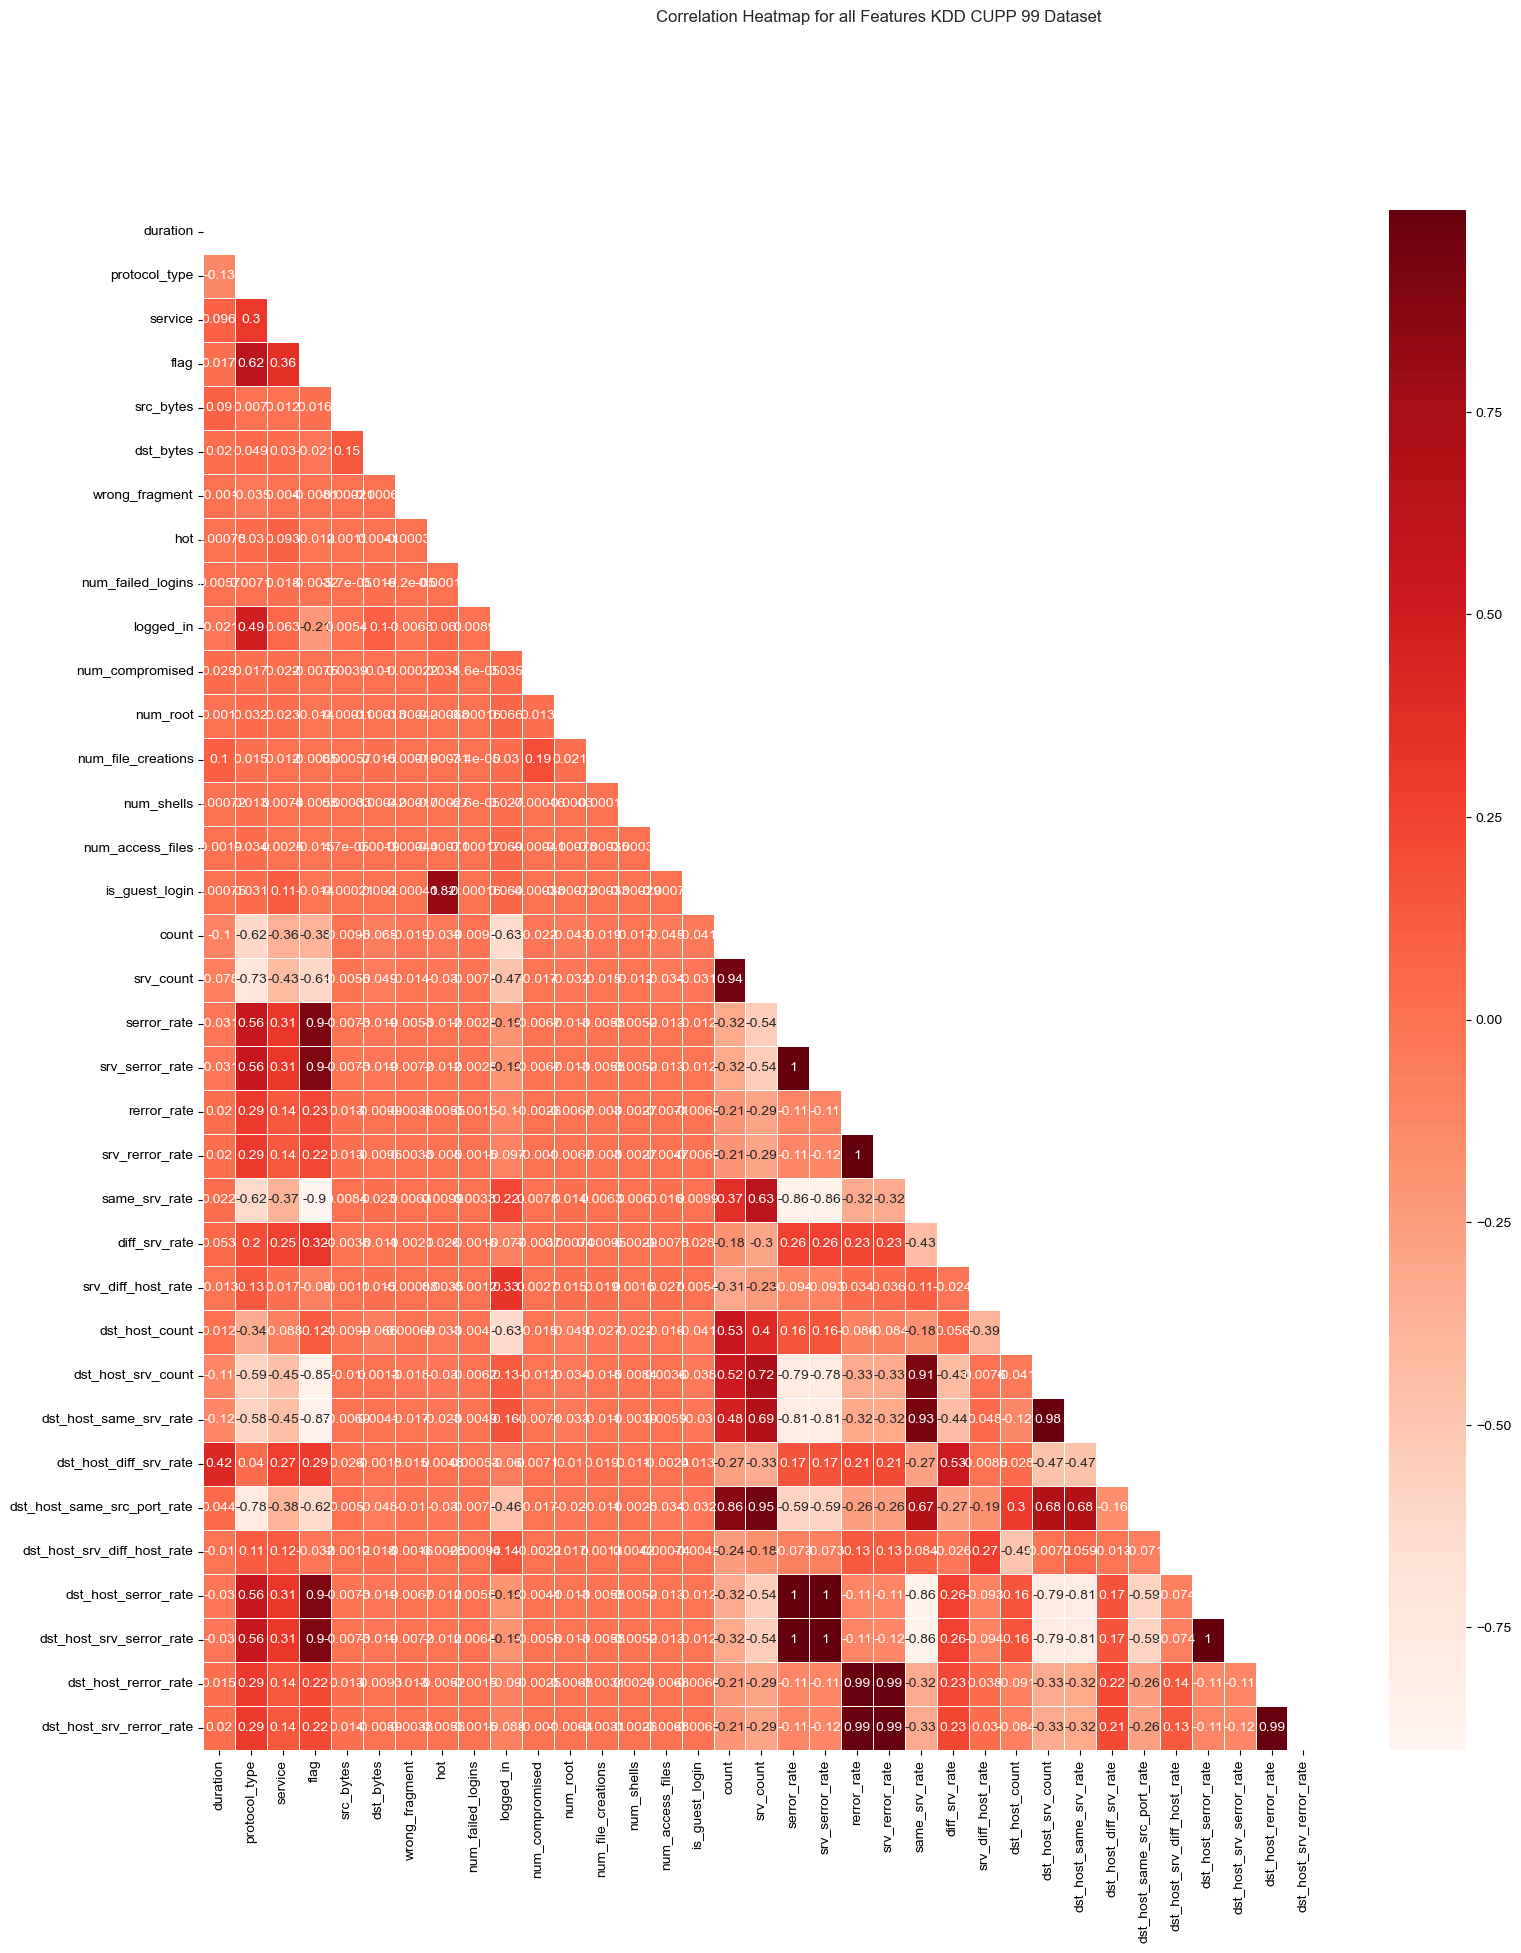

In [104]:
title = "Correlation Heatmap for all Features {} Dataset".format(dataset_label_dict[kddcup99])
show_correlation_heatmap_chart(features_kdd_cup_df, title)

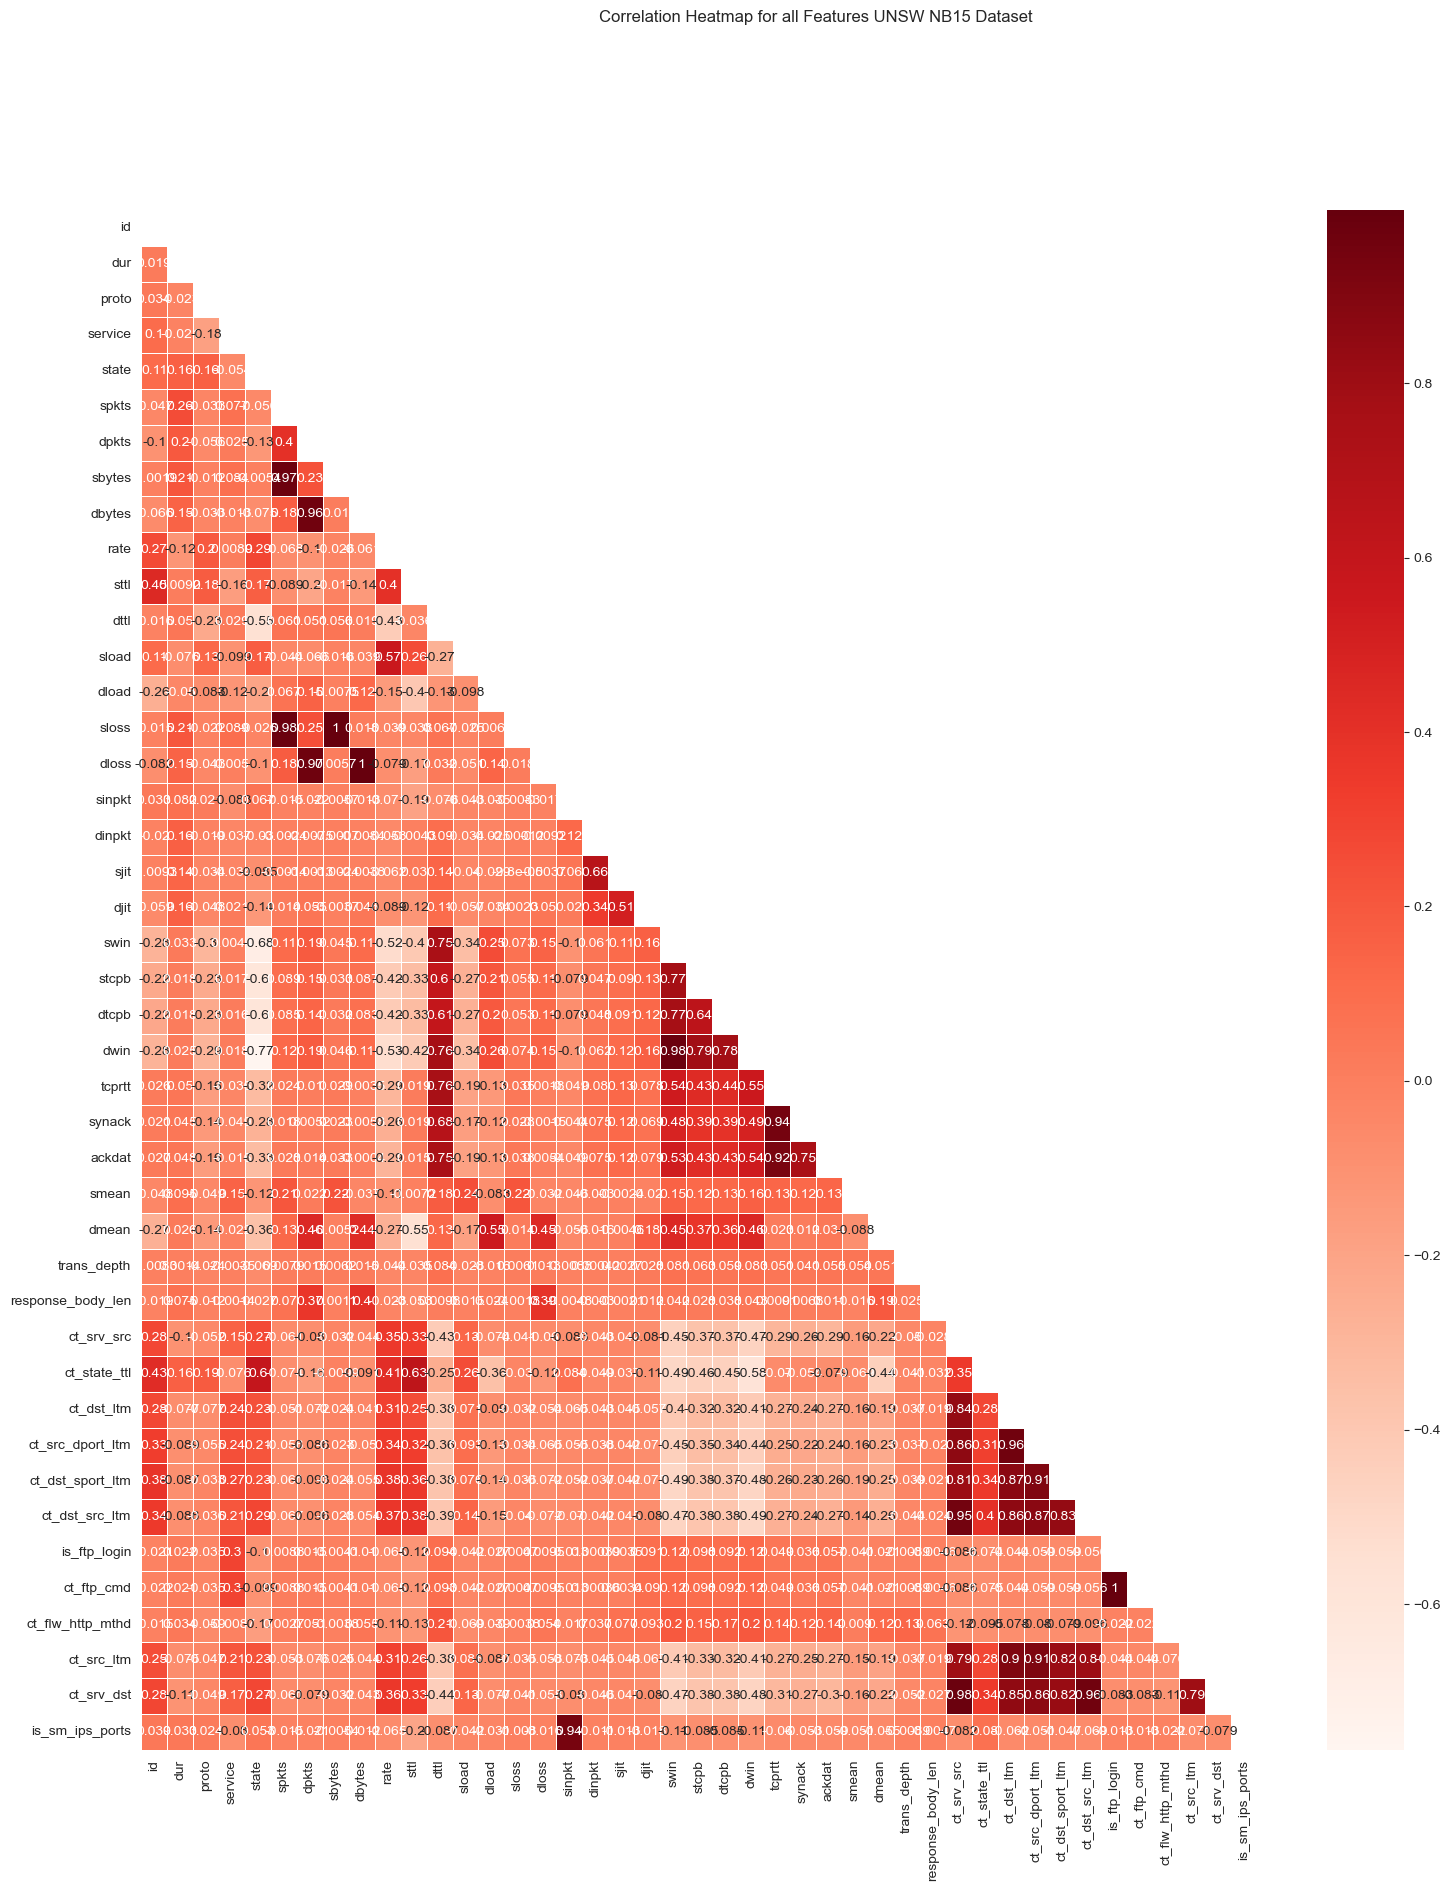

In [105]:
title = "Correlation Heatmap for all Features {} Dataset".format(dataset_label_dict[unswnb15])
show_correlation_heatmap_chart(features_unsw_nb15_df, title)

In [106]:
highly_correlation_kdd_cup_99_features = estimate_correlation_to_select_highly_correlated_features(features_kdd_cup_df, 0.90)




FEATURES WITH HIGH CORRELATION VALUES

srv_count: 0.9437633388573934


serror_rate: 0.9033181134905572


srv_serror_rate: 0.9987380163823391


srv_rerror_rate: 0.9954918046046397


dst_host_srv_count: 0.9077746115217863


dst_host_same_srv_rate: 0.9792369335217115


dst_host_same_src_port_rate: 0.9480936524285137


dst_host_serror_rate: 0.9978180910324319


dst_host_srv_serror_rate: 0.9984505286370885


dst_host_rerror_rate: 0.9852260371208528


dst_host_srv_rerror_rate: 0.9863118652950273









In [107]:
highly_correlation_unswnb15_features = estimate_correlation_to_select_highly_correlated_features(features_unsw_nb15_df, 0.90)




FEATURES WITH HIGH CORRELATION VALUES

sbytes: 0.9727762666709164


dbytes: 0.9602549615425818


sloss: 0.9962557810075825


dloss: 0.9952051841175366


dwin: 0.9805611634860427


synack: 0.9446282840426674


ackdat: 0.9246636919649635


ct_src_dport_ltm: 0.9615257893217745


ct_dst_sport_ltm: 0.9082660986644275


ct_dst_src_ltm: 0.9545582729944125


ct_ftp_cmd: 0.998540315156192


ct_src_ltm: 0.9108541629404708


ct_srv_dst: 0.9610671766921906


is_sm_ips_ports: 0.9365434135978642









In [108]:
highly_correlation_kdd_cup_99_features
features_kdd_cup_df.drop(highly_correlation_kdd_cup_99_features, axis=1,  inplace = True)

['serror_rate',
 'srv_rerror_rate',
 'dst_host_same_src_port_rate',
 'dst_host_serror_rate',
 'dst_host_rerror_rate',
 'srv_serror_rate',
 'dst_host_srv_count',
 'dst_host_srv_serror_rate',
 'dst_host_srv_rerror_rate',
 'srv_count',
 'dst_host_same_srv_rate']

In [109]:
highly_correlation_unswnb15_features
features_unsw_nb15_df.drop(highly_correlation_unswnb15_features, axis=1,  inplace = True)

['ct_src_dport_ltm',
 'ackdat',
 'ct_dst_src_ltm',
 'ct_dst_sport_ltm',
 'is_sm_ips_ports',
 'sloss',
 'ct_ftp_cmd',
 'sbytes',
 'dwin',
 'dloss',
 'dbytes',
 'ct_srv_dst',
 'ct_src_ltm',
 'synack']

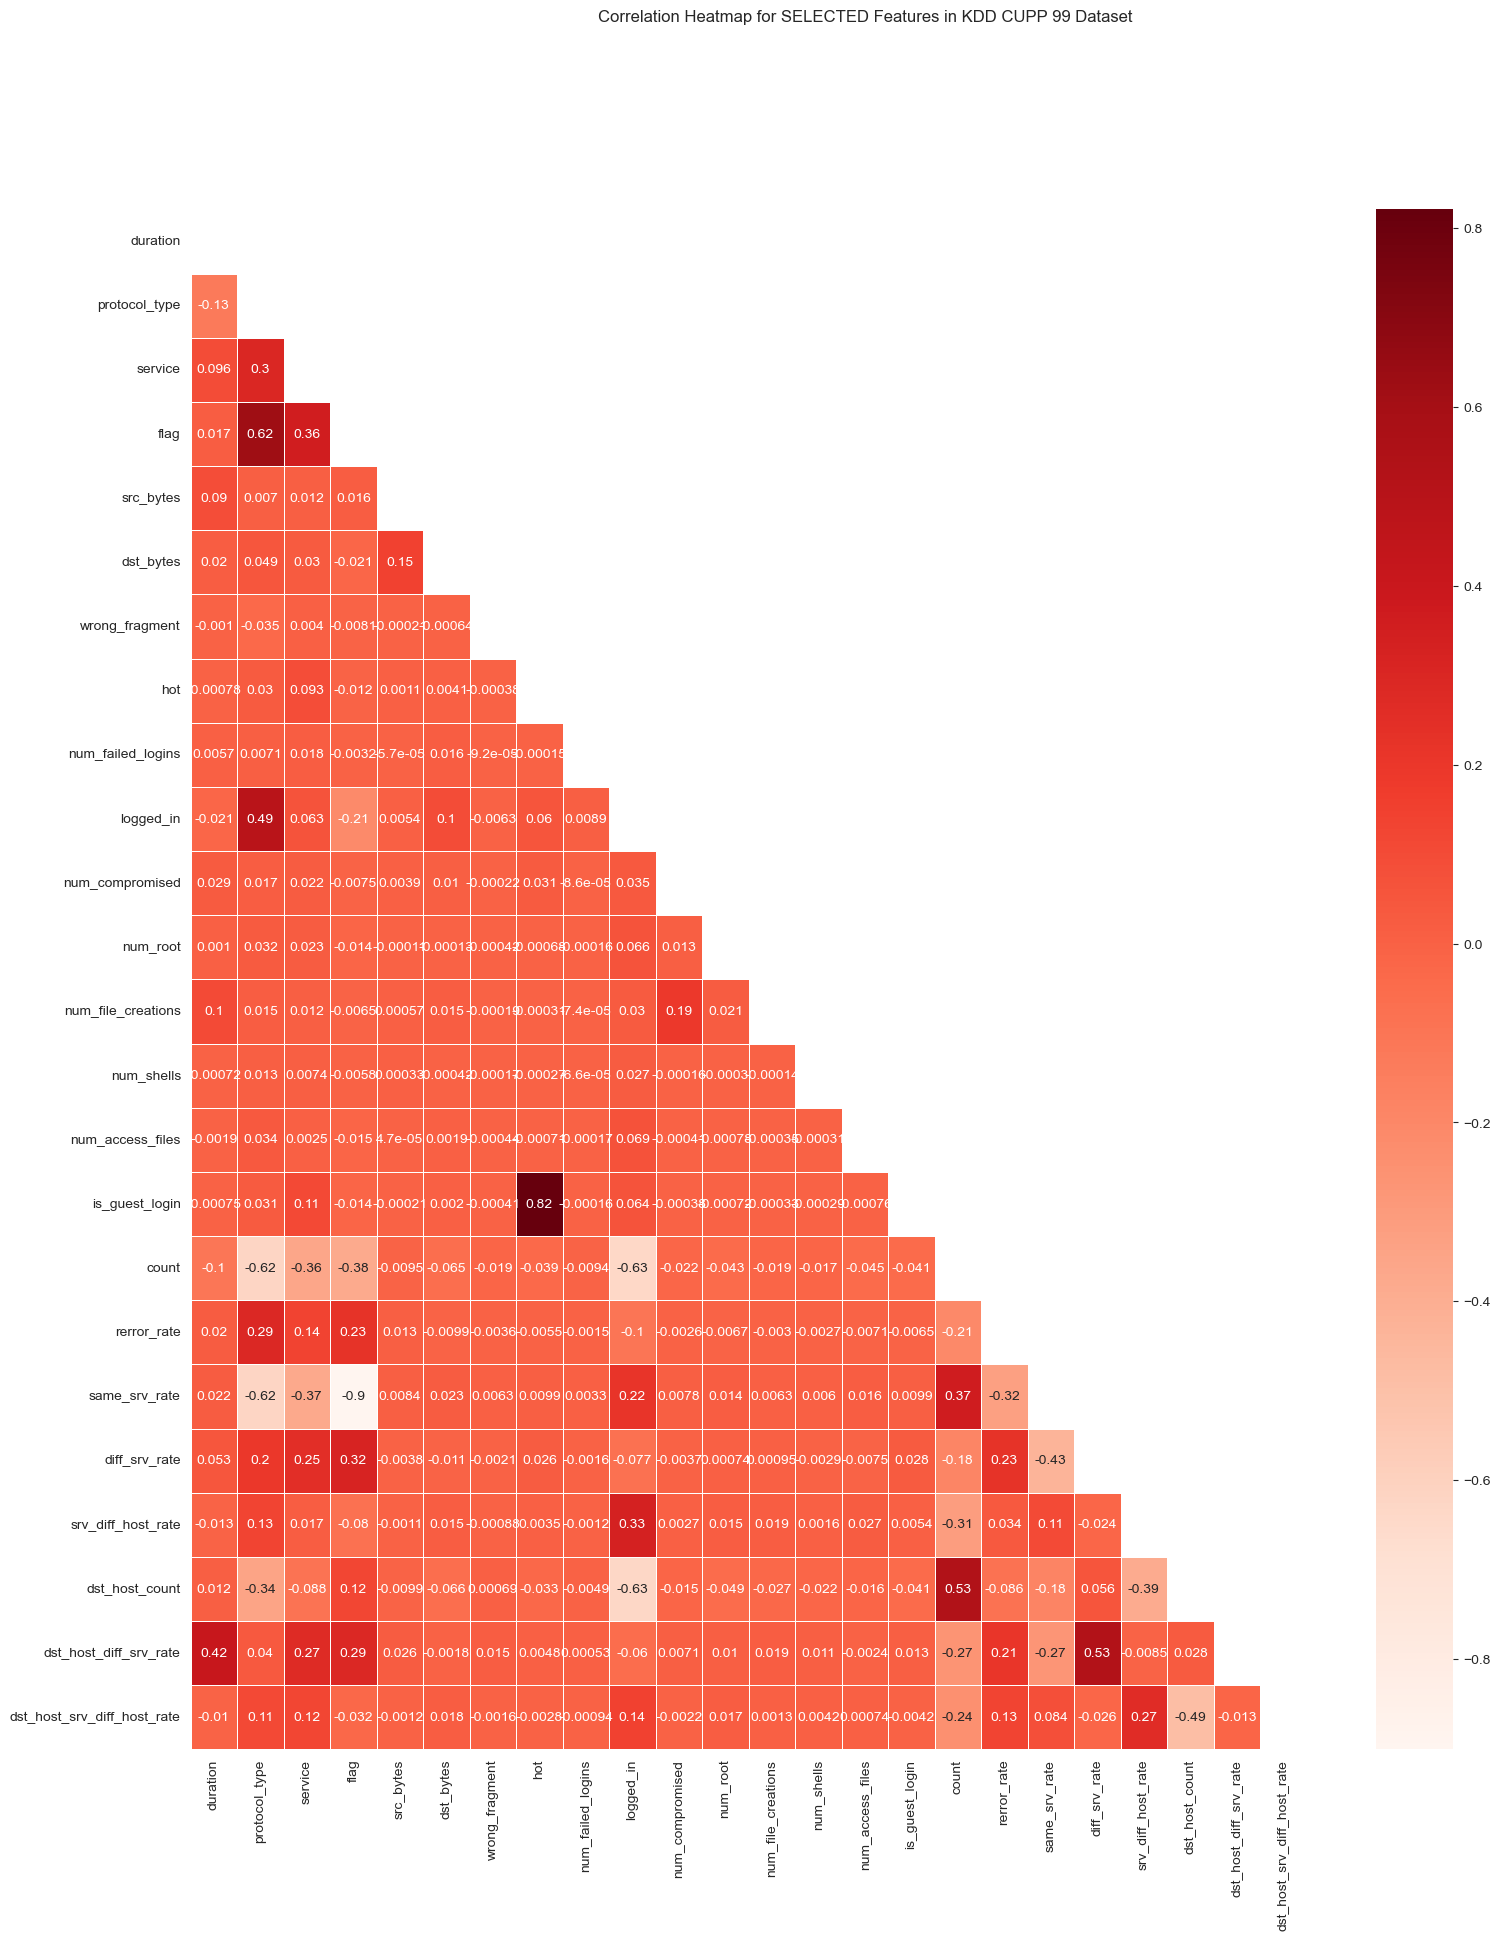

In [110]:
title = "Correlation Heatmap for SELECTED Features in {} Dataset".format(dataset_label_dict[kddcup99])
show_correlation_heatmap_chart(features_kdd_cup_df, title)

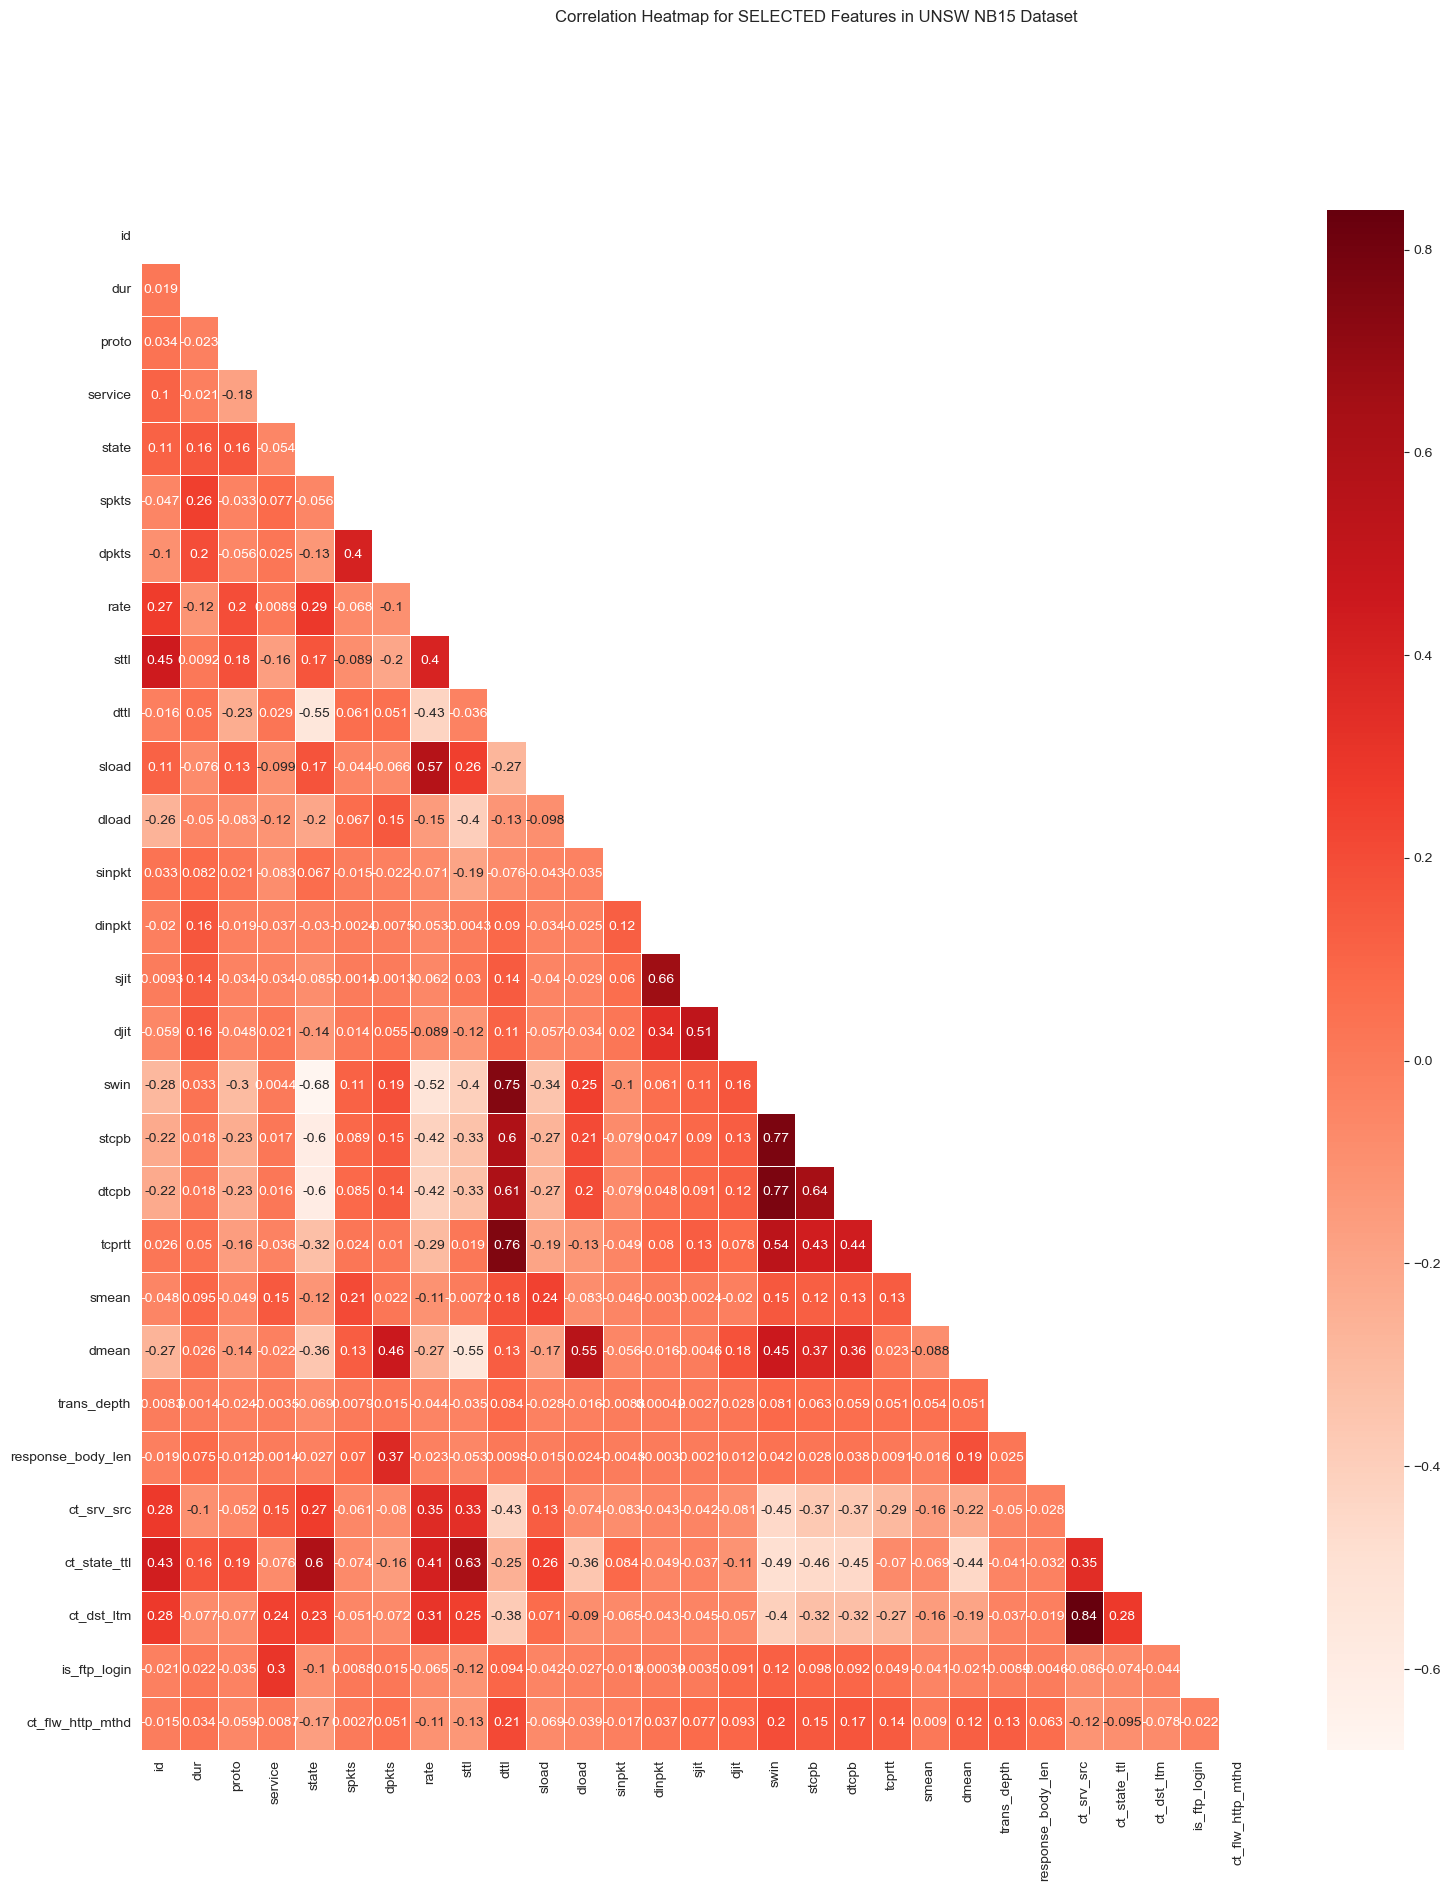

In [111]:
title = "Correlation Heatmap for SELECTED Features in {} Dataset".format(dataset_label_dict[unswnb15])
show_correlation_heatmap_chart(features_unsw_nb15_df, title)

In [112]:
kddcup_X_train, kddcup_X_test, kddcup_y_train, kddcup_y_test = train_test_split(features_kdd_cup_df, target_kdd_cup_df, test_size = 0.2, random_state = 0)

In [113]:
unsw_nb15_X_train, unsw_nb15_X_test, unsw_nb15_y_train, unsw_nb15_y_test = train_test_split(features_unsw_nb15_df, target_unsw_nb15_df, test_size = 0.2, random_state = 0)

In [114]:
sc = MinMaxScaler()

kddcup_X_train = sc.fit_transform(kddcup_X_train)
kddcup_X_test = sc.fit_transform(kddcup_X_test)

unsw_nb15_X_train = sc.fit_transform(unsw_nb15_X_train)
unsw_nb15_X_test = sc.fit_transform(unsw_nb15_X_test)

In [115]:
ros = SMOTE()

kddcup_X_train, kddcup_y_train = ros.fit_resample(kddcup_X_train, kddcup_y_train)

unsw_nb15_X_train, unsw_nb15_y_train = ros.fit_resample(unsw_nb15_X_train, unsw_nb15_y_train)

In [116]:
print(kddcup_y_train.agg(['nunique','count','size']))
print()
print(kddcup_y_train[kddcup_y_train == 0].count())
print()
print(kddcup_y_train[kddcup_y_train == 1].count())

nunique        2
count      64096
size       64096
Name: traffic_type, dtype: int64

32048

32048


In [117]:
print(unsw_nb15_y_train.agg(['nunique','count','size']))
print()
print(unsw_nb15_y_train[unsw_nb15_y_train == 0].count())
print()
print(unsw_nb15_y_train[unsw_nb15_y_train == 1].count())

nunique        2
count      51146
size       51146
Name: traffic_type, dtype: int64

25573

25573


In [118]:
analysis_df_dict[kddcup99] = dict()
analysis_df_dict[kddcup99][x_train_key] = kddcup_X_train
analysis_df_dict[kddcup99][x_test_key] = kddcup_X_test
analysis_df_dict[kddcup99][y_train_key] = kddcup_y_train
analysis_df_dict[kddcup99][y_test_key] = kddcup_y_test 

analysis_df_dict[unswnb15] = dict()
analysis_df_dict[unswnb15][x_train_key] = unsw_nb15_X_train
analysis_df_dict[unswnb15][x_test_key] = unsw_nb15_X_test
analysis_df_dict[unswnb15][y_train_key] = unsw_nb15_y_train
analysis_df_dict[unswnb15][y_test_key] = unsw_nb15_y_test

#### Experiment II

In [ ]:
experiment_type = "EXPERIMENT-TWO"

In [ ]:
hyper_parameter_tuned_NaiveBayes_model_analysis(analysis_df_dict, analysis_results, experiment_type)

In [ ]:
hyper_parameter_tuned_SVM_model_analysis(analysis_df_dict, analysis_results, experiment_type)

In [ ]:
hyper_parameter_tuned_DecisionTree_model_analysis(analysis_df_dict, analysis_results, experiment_type)

In [ ]:
hyper_parameter_tuned_RFC_model_analysis(analysis_df_dict, analysis_results, experiment_type)

In [ ]:
hyper_parameter_tuned_ANN_model_analysis(analysis_df_dict, analysis_results, experiment_type)

#### Summary Table for Experiment II

In [ ]:
KDD_Analysis_Summary_df = pd.DataFrame({
    AUC: [analysis_results[kddcup99][experiment_type][NBC][AUC], analysis_results[kddcup99][experiment_type][SVM][AUC], analysis_results[kddcup99][experiment_type][DTC][AUC], analysis_results[kddcup99][experiment_type][RFC][AUC], analysis_results[kddcup99][experiment_type][ANN][AUC]],
    GMEAN: [analysis_results[kddcup99][experiment_type][NBC][GMEAN], analysis_results[kddcup99][experiment_type][SVM][GMEAN], analysis_results[kddcup99][experiment_type][DTC][GMEAN], analysis_results[kddcup99][experiment_type][RFC][GMEAN], analysis_results[kddcup99][experiment_type][ANN][GMEAN]],
}, index=[NBC, SVM, DTC, RFC, ANN])

In [ ]:
UNSWNB15_Analysis_Summary_df = pd.DataFrame({
    AUC: [analysis_results[unswnb15][experiment_type][NBC][AUC], analysis_results[unswnb15][experiment_type][SVM][AUC], analysis_results[unswnb15][experiment_type][DTC][AUC], analysis_results[unswnb15][experiment_type][RFC][AUC], analysis_results[unswnb15][experiment_type][ANN][AUC]],
    GMEAN: [analysis_results[unswnb15][experiment_type][NBC][GMEAN], analysis_results[unswnb15][experiment_type][SVM][GMEAN], analysis_results[unswnb15][experiment_type][DTC][GMEAN], analysis_results[unswnb15][experiment_type][RFC][GMEAN], analysis_results[unswnb15][experiment_type][ANN][GMEAN]],
}, index=[NBC, SVM, DTC, RFC, ANN])

In [ ]:
KDD_Analysis_Summary_df

In [ ]:
UNSWNB15_Analysis_Summary_df